# **I. 감정 분석 모델을 통한 소설의 총체적인 감정 분석**

## **1. 찰스 디킨스, "두 도시 이야기" (A Tale of Two Cities)**

###**(1) 모델 분석 결과**

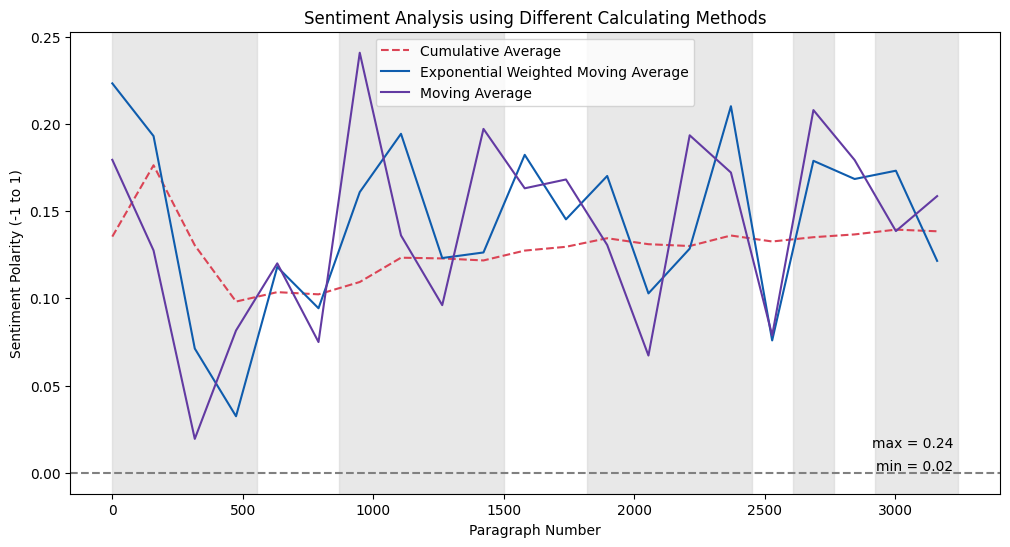

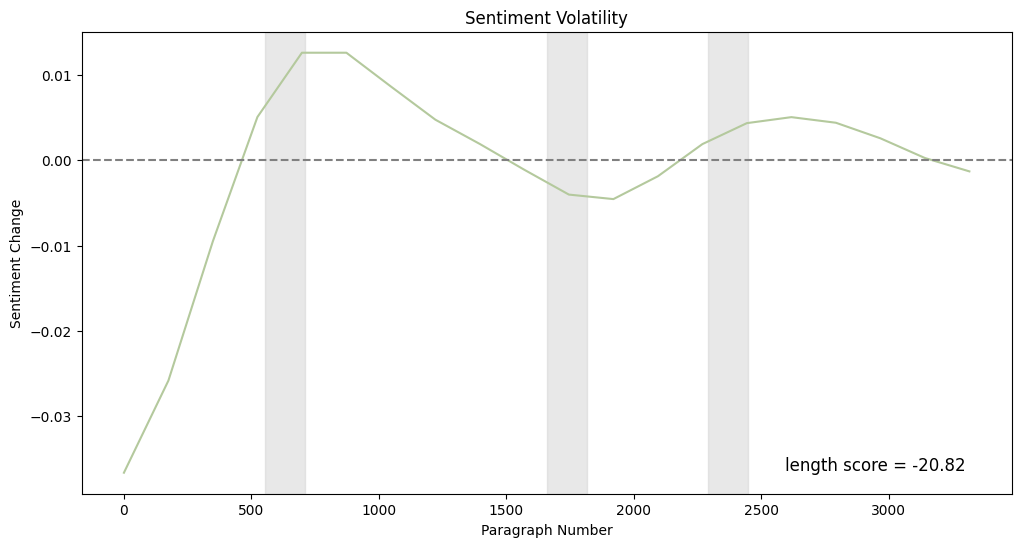

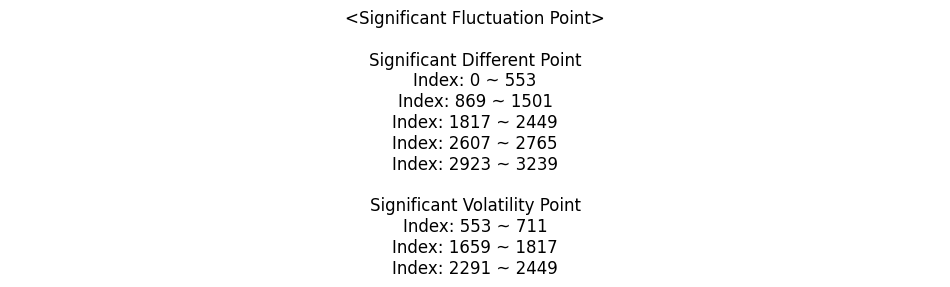

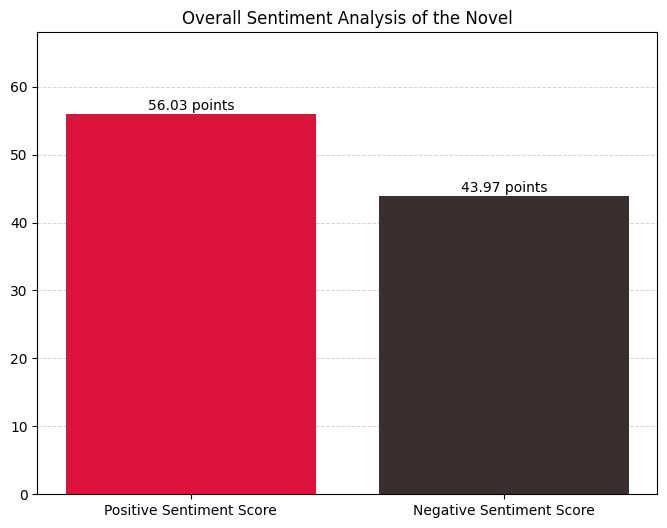

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import re
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from transformers import pipeline

# 파일 경로 설정
file_path = '/content/sample_data/A-Tale-of-Two-Cities.txt'  # 파일 경로를 필요에 맞게 수정하세요.

# 텍스트 파일 읽기
with open(file_path, 'r', encoding='utf-8') as file:
    text = file.read()

# 텍스트를 문단 단위로 분할 (빈 줄과 장 제목을 기준으로)
paragraphs = re.split(r'\n\n|BOOK \w+\n|CHAPTER \d+\n', text, flags=re.IGNORECASE)
paragraphs = [paragraph.strip() for paragraph in paragraphs if paragraph.strip()]  # 빈 문단 제거 및 공백 제거

# 총 문단의 개수 계산
total_paragraphs = len(paragraphs)

# 감정 분석 모델 로드 (Hugging Face Transformers, BERT 기반 모델)
sentiment_analysis_pipeline = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

# 최대 입력 길이 설정
MAX_LENGTH = 512

# 감정 분석 수행 함수 정의
def get_sentiment_score(text, prev_score=None):
    if len(text) > MAX_LENGTH:
        text = text[:MAX_LENGTH]  # 입력 문장을 최대 길이로 자르기
    results = sentiment_analysis_pipeline(text)

    # 다중 감정 인식 및 점수 할당
    emotion_scores = {'anger': 0, 'disgust': 0, 'fear': 0, 'joy': 0, 'sadness': 0}
    for result in results:
        label = result['label']
        probability = result['score']

        if label == '1 star':
            emotion_scores['sadness'] += probability
        elif label == '2 stars':
            emotion_scores['fear'] += probability
        elif label == '3 stars':
            emotion_scores['disgust'] += probability
        elif label == '4 stars':
            emotion_scores['joy'] += probability
        elif label == '5 stars':
            emotion_scores['joy'] += 2 * probability

    # 감정 점수 통합
    score = (
        -1 * emotion_scores['anger'] +
        -0.5 * emotion_scores['disgust'] +
        -0.7 * emotion_scores['fear'] +
        1 * emotion_scores['joy'] +
        -1 * emotion_scores['sadness']
    )

    return score

# 긍정적 및 부정적 단어 리스트 정의
positive_words = [
    "happy", "joyful", "excellent", "good", "wonderful", "amazing", "great", "positive", "fortunate", "pleased",
    "delightful", "content", "cheerful", "satisfied", "thrilled", "ecstatic", "merry", "elated", "jubilant", "gleeful"
]

negative_words = [
    "sad", "terrible", "bad", "awful", "horrible", "negative", "unfortunate", "displeased", "angry", "fearful",
    "miserable", "depressed", "unhappy", "downcast", "gloomy", "dismal", "wretched", "heartbroken", "melancholy", "despair"
]

# 중요 문단을 인식하기 위한 키워드 리스트
important_keywords = [
    "conflict", "resolution", "climax", "turning point", "significant", "important", "crucial", "pivotal"
]

# 감정 분석 수행 함수 정의 (중요 문단 인식 추가)
def get_sentiment_score(paragraph, prev_score=None):
    if len(paragraph) > MAX_LENGTH:
        paragraph = paragraph[:MAX_LENGTH]  # 입력 문장을 최대 길이로 자르기
    results = sentiment_analysis_pipeline(paragraph)

    # 문맥에 따라 긍정 또는 부정 가중치 적용
    context_weight = 1.0
    if any(word in paragraph for word in positive_words):
        context_weight = 1.2  # 긍정 문맥 가중치
    elif any(word in paragraph for word in negative_words):
        context_weight = 0.8  # 부정 문맥 가중치

    # 중요 문단 가중치 적용
    important_weight = 1.0
    if any(keyword in paragraph for keyword in important_keywords):
        important_weight = 1.5

    # 다중 감정 인식 및 점수 할당
    emotion_scores = {'anger': 0, 'disgust': 0, 'fear': 0, 'joy': 0, 'sadness': 0}
    for result in results:
        label = result['label']
        probability = result['score']

        if label == '1 star':
            emotion_scores['sadness'] += probability
        elif label == '2 stars':
            emotion_scores['fear'] += probability
        elif label == '3 stars':
            emotion_scores['disgust'] += probability
        elif label == '4 stars':
            emotion_scores['joy'] += probability
        elif label == '5 stars':
            emotion_scores['joy'] += 2 * probability

    # 감정 점수 통합 및 가중치 적용
    score = (
        -1 * emotion_scores['anger'] +
        -0.5 * emotion_scores['disgust'] +
        -0.7 * emotion_scores['fear'] +
        1 * emotion_scores['joy'] +
        -1 * emotion_scores['sadness']
    ) * context_weight * important_weight

    return score

# 첫 번째 문장은 이전 문장이 없으므로 먼저 처리
sentiment_analysis = [get_sentiment_score(paragraphs[0])]

# 나머지 문장 처리
for i in range(1, total_paragraphs):
    prev_score = sentiment_analysis[-1]
    sentiment_analysis.append(get_sentiment_score(paragraphs[i], prev_score))

# specific_size와 standard_num 계산
def calculate_specific_size(total_paragraphs, target_standard_num=20):
    best_specific_size = None
    closest_difference = float('inf')
    best_standard_num = None

    for specific_size in range(1, total_paragraphs + 1):
        standard_num = total_paragraphs // specific_size
        difference = abs(standard_num - target_standard_num)

        if difference < closest_difference:
            closest_difference = difference
            best_specific_size = specific_size
            best_standard_num = standard_num

        if closest_difference == 0:
            break

    return best_specific_size, best_standard_num

specific_size, standard_num = calculate_specific_size(total_paragraphs)

# 단순 누적 평균 계산
cumulative_avg = np.cumsum(sentiment_analysis) / (np.arange(total_paragraphs) + 1)

# 가중 누적 평균 계산 (EWMA)
ewma = pd.Series(sentiment_analysis).ewm(span=specific_size, adjust=False).mean()

# 이동 평균 계산 함수 정의
def moving_average(data, window_size):
    return [np.mean(data[i:i + window_size]) for i in range(0, len(data), window_size)]

# 세 가지 방법 모두 specific_size 만큼의 평균으로 통일
sentiment_avg = moving_average(sentiment_analysis, specific_size)
cumulative_avg_avg = moving_average(cumulative_avg, specific_size)
ewma_avg = moving_average(ewma, specific_size)

# 이동 평균의 최대값과 최소값 계산
moving_avg_max = max(sentiment_avg)
moving_avg_min = min(sentiment_avg)

# sigma 값을 동적으로 설정
sigma_value = max(0.1, min(1.0, 10.0 / np.sqrt(total_paragraphs)))  # 문장의 수에 따라 sigma 값을 조정
sentiment_avg_smooth = gaussian_filter1d(sentiment_avg, sigma=sigma_value)
cumulative_avg_smooth = gaussian_filter1d(cumulative_avg_avg, sigma=sigma_value)
ewma_avg_smooth = gaussian_filter1d(ewma_avg, sigma=sigma_value)

# X 좌표 설정
x_sentiment = np.arange(len(sentiment_avg)) * specific_size
x_cumulative = np.arange(len(cumulative_avg_avg)) * specific_size
x_ewma = np.arange(len(ewma_avg)) * specific_size

# 차이가 크게 나타나는 구간 식별
difference = np.abs(np.array(ewma_avg) - np.array(sentiment_avg))
std_dev_difference = np.std(difference)
threshold_difference = 1.2 * std_dev_difference  # 이동 표준 편차의 1.2배를 임계값으로 설정

significant_diff_indices = np.where(difference >= threshold_difference)[0]

# 오차 범위를 고려한 실제 문장 인덱스 계산
actual_diff_indices = []
for idx in significant_diff_indices:
    start_idx = max(0, idx * specific_size - specific_size // 2)
    end_idx = min(total_paragraphs, idx * specific_size + specific_size // 2)
    actual_diff_indices.append((start_idx, end_idx))

# 인접한 구간 합치기
merged_diff_indices = []
for start_idx, end_idx in actual_diff_indices:
    if not merged_diff_indices:
        merged_diff_indices.append([start_idx, end_idx])
    else:
        last_start, last_end = merged_diff_indices[-1]
        if start_idx <= last_end:
            merged_diff_indices[-1] = [last_start, max(last_end, end_idx)]
        else:
            merged_diff_indices.append([start_idx, end_idx])

# Sentiment Volatility 계산
volatility = np.diff(sentiment_avg_smooth)

# 가우시안 스무딩 적용 (곡률을 더 크게)
volatility_smooth = gaussian_filter1d(volatility, sigma=2)

# Sentiment Volatility에서 차이가 크게 나타나는 구간 식별
volatility_diff_indices = []
for i in range(1, len(volatility_smooth) - 1):
    if (volatility_smooth[i] > volatility_smooth[i-1] and volatility_smooth[i] > volatility_smooth[i+1]) or \
       (volatility_smooth[i] < volatility_smooth[i-1] and volatility_smooth[i] < volatility_smooth[i+1]):
        volatility_diff_indices.append(i)

# 오차 범위를 고려한 실제 문장 인덱스 계산
actual_volatility_indices = []
for idx in volatility_diff_indices:
    start_idx = max(0, idx * specific_size - specific_size // 2)
    end_idx = min(total_paragraphs, idx * specific_size + specific_size // 2)
    actual_volatility_indices.append((start_idx, end_idx))

# 인접한 구간 합치기
merged_volatility_indices = []
for start_idx, end_idx in actual_volatility_indices:
    if not merged_volatility_indices:
        merged_volatility_indices.append([start_idx, end_idx])
    else:
        last_start, last_end = merged_volatility_indices[-1]
        if start_idx <= last_end:
            merged_volatility_indices[-1] = [last_start, max(last_end, end_idx)]
        else:
            merged_volatility_indices.append([start_idx, end_idx])

# 그래프 그리기 (Sentiment Analysis)
plt.figure(figsize=(12, 6))

# 단순 누적 평균
plt.plot(x_cumulative, cumulative_avg_smooth, color='#DB4455', linestyle='--', label='Cumulative Average')

# 가중 누적 평균 (EWMA)
plt.plot(x_ewma, ewma_avg_smooth, color='#0E5CAD', linestyle='-', label='Exponential Weighted Moving Average')

# 이동 평균
plt.plot(x_sentiment, sentiment_avg_smooth, color='#623AA2', linestyle='-', label='Moving Average')

# S.D.P. 영역 추가
for start_idx, end_idx in merged_diff_indices:
    end_idx = min(end_idx, total_paragraphs)  # 소설의 끝을 넘지 않도록 조정
    plt.axvspan(start_idx, end_idx, color='lightgrey', alpha=0.5)

plt.xlabel('Paragraph Number')
plt.ylabel('Sentiment Polarity (-1 to 1)')
plt.title('Sentiment Analysis using Different Calculating Methods')
plt.axhline(0, color='grey', linestyle='--')  # 중립 감정선
plt.legend()

# 이동 평균의 최대값과 최소값을 그래프에 표시
plt.text(0.95, 0.10, f"max = {moving_avg_max:.2f}", fontsize=10, color='black', transform=plt.gca().transAxes, ha='right')
plt.text(0.95, 0.05, f"min = {moving_avg_min:.2f}", fontsize=10, color='black', transform=plt.gca().transAxes, ha='right')

plt.show()

# 그래프 그리기 (Sentiment Volatility)
plt.figure(figsize=(12, 6))

# x축을 문장의 수에 맞게 조정
plt.plot(np.linspace(0, total_paragraphs, len(volatility_smooth)), volatility_smooth, color='#B4C99D', linestyle='-')
plt.axhline(0, color='grey', linestyle='--')  # y=0의 값에 회색 점선 추가

plt.xlabel('Paragraph Number')
plt.ylabel('Sentiment Change')
plt.title('Sentiment Volatility')

# S.V.P. 영역 추가
for start_idx, end_idx in merged_volatility_indices:
    end_idx = min(end_idx, total_paragraphs)  # 소설의 끝을 넘지 않도록 조정
    plt.axvspan(start_idx, end_idx, color='lightgrey', alpha=0.5)

# 길이 점수 출력 (그래프의 '네모 박스'의 우측 하단에 표시)
plt.text(0.95, 0.05, f"length score = {volatility_smooth.sum() * 1000:.2f}", fontsize=12, color='black', transform=plt.gca().transAxes, ha='right')

plt.show()

# 실제 문장 인덱스 기반 텍스트 분석
fig, ax = plt.subplots(figsize=(12, 2))
ax.text(0.5, 0.5, "<Significant Fluctuation Point>\n\nSignificant Different Point\n" + '\n'.join(
    [f"Index: {start} ~ {end}" for start, end in merged_diff_indices]) + "\n\nSignificant Volatility Point\n" + '\n'.join(
    [f"Index: {start} ~ {end}" for start, end in merged_volatility_indices]), horizontalalignment='center', verticalalignment='center', fontsize=12)
ax.axis('off')
plt.show()

# 문단별 긍정 및 부정 점수 분리
positive_scores = [score for score in sentiment_analysis if score > 0]
negative_scores = [score for score in sentiment_analysis if score < 0]

# 긍정 및 부정 점수 합산 (절댓값 사용)
positive_score_sum = sum(positive_scores)
negative_score_sum = abs(sum(negative_scores))

# 가중치 적용 (문단 수)
positive_weighted_sum = positive_score_sum * len(positive_scores)
negative_weighted_sum = negative_score_sum * len(negative_scores)

# 총합 계산
total_weighted_sum = positive_weighted_sum + negative_weighted_sum

# 백분율로 환산
positive_final_score = (positive_weighted_sum / total_weighted_sum) * 100
negative_final_score = (negative_weighted_sum / total_weighted_sum) * 100

# 막대 바 차트 시각화 수정된 코드
fig, ax = plt.subplots(figsize=(8, 6))

# 데이터 준비
categories = ['Positive Sentiment Score', 'Negative Sentiment Score']
scores = [positive_final_score, negative_final_score]
colors = ["#DC143C", "#392F31"]

# 막대 바 차트 그리기
bars = plt.bar(categories, scores, color=colors)

# 레이블 추가 (막대 바 위쪽에 위치하도록)
for bar, score in zip(bars, scores):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, yval + 0.1, f'{score:.2f} points', ha='center', va='bottom', color='black')

# y축 최대값 설정
max_score = max(positive_final_score, negative_final_score)
ymax = np.ceil(max_score * 1.2)

# y축에 숫자를 표시한 지점마다 x축과 평행한 점선 추가
ax.yaxis.grid(True, which='both', color='lightgrey', linestyle='--', linewidth=0.7)
ax.set_axisbelow(True)
ax.set_ylim(0, ymax)

# 제목 설정
plt.title('Overall Sentiment Analysis of the Novel')

plt.show()

### **(2) 모델 분석 결과에 대한 타당성 평가**

#### **감정 극성의 범위와 그 적절성**
- **수치**: 0.02부터 0.24
- **이유 및 타당성 설명**: "A Tale of Two Cities"는 프랑스 혁명과 그로 인한 사회적 혼란을 배경으로 다양한 감정적 변화를 담고 있습니다. 모델이 이러한 감정적 변화를 적절히 포착한 것으로 보이며, 감정 극성의 범위가 이야기의 긴장감과 사건의 전개를 잘 반영하고 있습니다. <br><br>

#### **Significant Different Point (SDP)의 설명**
- **설명**: 모델이 감정 변화가 두드러지는 주요 사건을 잘 포착하고 있습니다. 이는 이야기의 중요한 장면들에서 감정 변화를 잘 반영한 결과입니다. <br>
  - **Index 0 ~ 553**: 이야기의 도입부와 설정, 주요 인물인 찰스 다네이와 시드니 카턴의 소개. 이 시기는 프랑스 혁명 전의 파리와 런던의 상황을 묘사합니다.
  - **Index 869 ~ 1501**: 찰스 다네이가 프랑스 혁명 속에서 고난을 겪고, 루시 마넷과 그녀의 아버지가 다시 만나게 되는 감정적인 재회 장면. 혁명의 불안정한 분위기와 그로 인한 긴장감이 고조됩니다.
  - **Index 1817 ~ 2449**: 찰스 다네이가 감옥에 갇히고, 시드니 카턴이 그를 구하기 위해 희생을 결심하는 장면. 이 시기는 이야기의 중반부로, 갈등이 절정에 이르며 감정의 고조를 이루는 중요한 부분입니다.
  - **Index 2607 ~ 2765**: 시드니 카턴의 희생이 실제로 이루어지는 클라이맥스 장면. 그의 자기 희생과 용기가 중심 테마로 나타나며, 감정적인 절정에 이릅니다.
  - **Index 2923 ~ 3239**: 이야기가 마무리되면서 남겨진 사람들의 삶이 정리되고, 프랑스 혁명 후의 여파를 다루는 결말 부분. 이야기의 마무리와 함께 감정도 안정됩니다. <br><br>

#### **Significant Volatility Point (SVP)의 설명**
- **설명**: 모델이 감정 변화가 두드러지는 주요 사건을 잘 포착하고 있습니다. 특히 이야기의 주요 전환점에서 감정의 변화가 정확히 반영되었습니다. <br>
  - **Index 553 ~ 711**: 찰스 다네이가 프랑스로 돌아가기로 결심하는 중요한 전환점. 이 결심으로 인해 이야기는 급격한 감정 변화를 겪게 됩니다.
  - **Index 1659 ~ 1817**: 다네이가 체포되고 감옥에 갇히면서 루시 마넷과의 재회가 불투명해지는 갈등 고조. 이 시기는 혁명의 혼란과 함께 인물들의 불안이 극대화됩니다.
  - **Index 2291 ~ 2449**: 시드니 카턴이 찰스 다네이를 구하기 위해 자신을 희생하기로 결심하는 장면. 이 시기는 극적인 감정 변화와 희생의 순간을 보여줍니다. <br><br>

#### **Significant Fluctuation Point (SFP)의 설명**
- **설명**: 전반적으로 SDP와 SVP의 설정이 적절하게 이루어졌습니다. 겹친 부분은 2291 ~ 2449번째 문단으로, 이 곳에서 극적인 감정의 변화와 희생의 순간을 매우 효과적으로 감지하였습니다. <br><br>

#### **전반적인 긍정적/부정적 점수와 그 적절성**
- **긍정 점수**: 56.03 points
- **부정 점수**: 43.97 points
- **이유 및 타당성 설명**: 소설의 전반적인 분위기가 긍정적인 요소와 부정적인 요소가 잘 혼합된 것을 나타내며, 이는 인물들의 다양한 감정 상태와 사건의 전개를 잘 반영한 결과입니다. <br><br>

#### **종합 평가**
- 모델은 "A Tale of Two Cities"의 감정을 효과적으로 분석하였으며, 각 분석 지표가 소설의 주요 테마와 사건을 잘 반영하고 있습니다.
- 이를 통해 모델이 텍스트의 감정 변화를 정밀하게 포착할 수 있음을 확인할 수 있습니다. <br><br>


### **(3) 인문학적 후속 분석**
#### **프랑스 혁명 전후의 감정 변화를 시각화하여 혁명의 감정적 영향을 평가**

"A Tale of Two Cities"는 프랑스 혁명 전후의 사회적 혼란과 인물들의 감정 변화를 중심으로 전개됩니다. 감정 극성의 변화 그래프를 통해 혁명의 감정적 영향을 인문학적으로 평가할 수 있겠습니다.<br><br>

- **감정 변화가 큰 영역 분석**:
  - **Index 553 ~ 711**: 찰스 다네이가 프랑스로 돌아가기로 결심하는 중요한 전환점입니다. 이 결심은 그의 인생뿐만 아니라 루시 마넷과 그녀의 가족들에게도 큰 영향을 미칩니다. 이 결심으로 인해 이야기는 급격한 감정 변화를 겪게 됩니다.
  - **Index 1659 ~ 1817**: 찰스 다네이가 체포되고 감옥에 갇히면서 루시 마넷과의 재회가 불투명해집니다. 이 시기는 혁명의 혼란과 함께 인물들의 불안이 극대화되는 부분입니다.
  - **Index 2291 ~ 2449**: 시드니 카턴이 찰스 다네이를 구하기 위해 자신을 희생하기로 결심하는 장면입니다. 이 시기는 극적인 감정 변화와 희생의 순간을 보여주며, 혁명의 감정적 영향을 잘 드러냅니다.<br><br>

- **소설의 전반적인 분위기 분석**:
  - **긍정 점수**: 56.03 points
  - **부정 점수**: 43.97 points
  - 소설의 전반적인 분위기는 긍정적 요소와 부정적 요소가 균형을 이루고 있습니다. 이는 혁명과 같은 극적인 사건 속에서도 인물들이 느끼는 희망과 절망, 기쁨과 슬픔이 혼재되어 있음을 나타냅니다.<br><br>

- **SDP와 SVP로 선정된 구간 중 가장 합리적인 부분에 대한 인문학적 분석**:
  - **Index 553 ~ 711**: 찰스 다네이가 프랑스로 돌아가기로 결심하는 중요한 전환점은 감정의 급격한 변화를 보여주는 대표적인 예시입니다. 이 구간은 혁명의 불안정한 분위기와 그로 인한 인물들의 감정적 변화를 효과적으로 감지한 것입니다. 그의 결심은 이야기를 크게 전환시키는 역할을 하며, 혁명의 감정적 영향을 평가하는 데 중요한 요소입니다.<br><br>

이와 같이, "A Tale of Two Cities"는 프랑스 혁명의 감정적 영향을 다양한 인물과 사건을 통해 생생하게 묘사하고 있습니다. 감정 극성의 변화 그래프와 분석을 통해 혁명이 인물들의 감정에 미친 영향을 평가할 수 있습니다.<br><br>



---



## **2. 제인 오스틴, "오만과 편견" (Pride and Prejudice)**



###**(1) 모델 분석 결과**

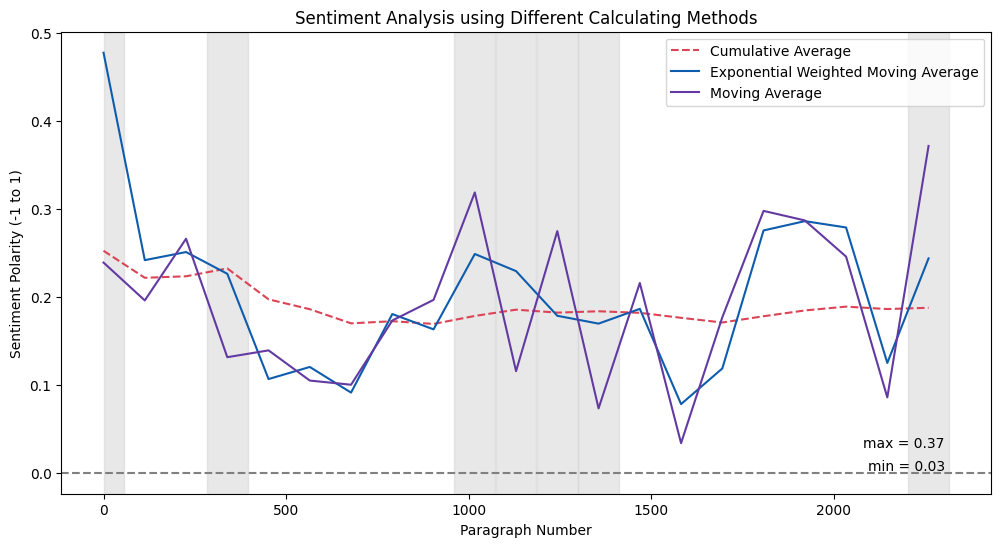

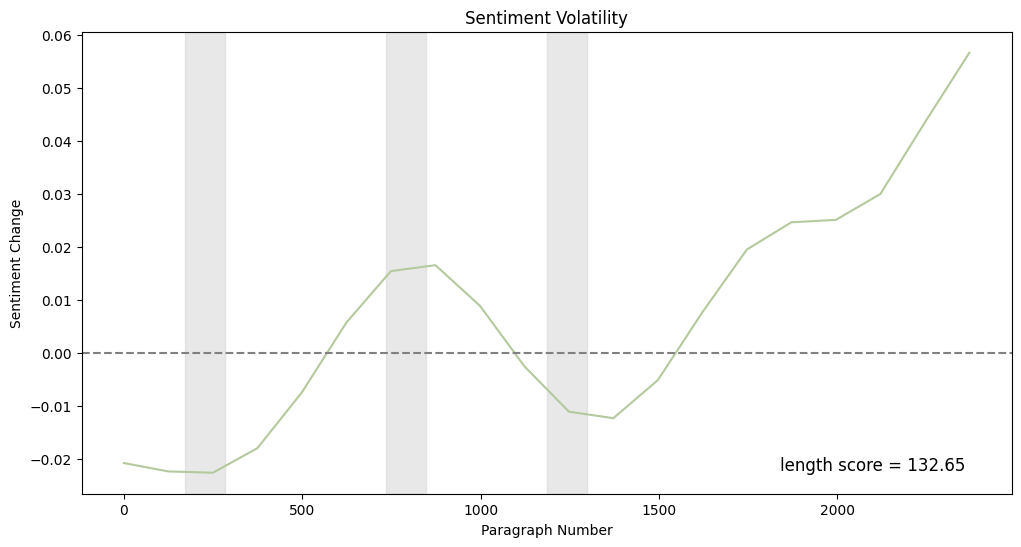

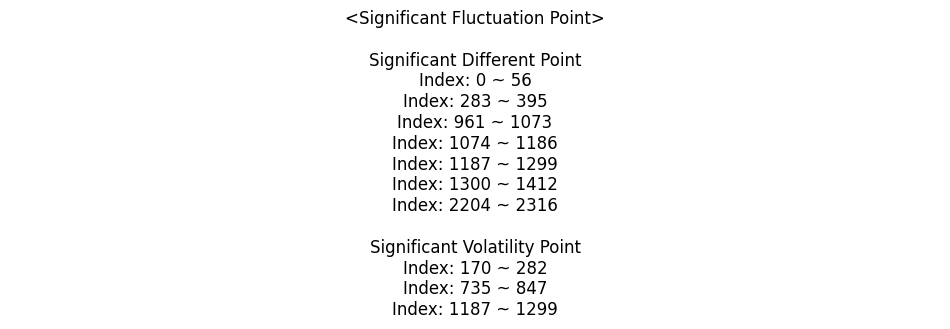

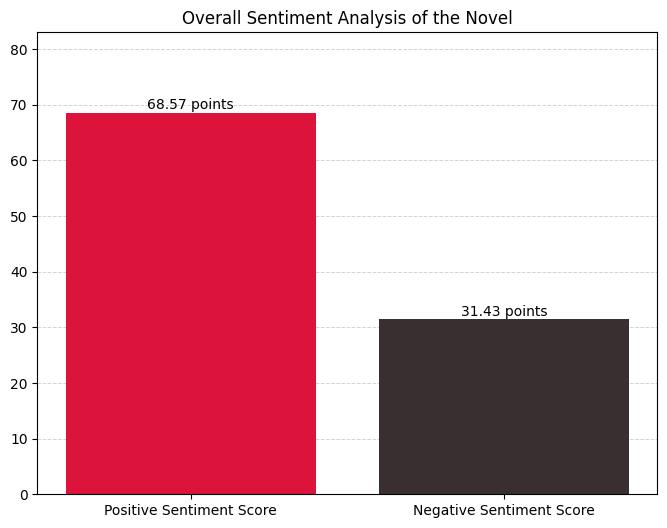

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import re
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from transformers import pipeline

# 파일 경로 설정
file_path = '/content/sample_data/Pride-and-Prejudice.txt'  # 파일 경로를 필요에 맞게 수정하세요.

# 텍스트 파일 읽기
with open(file_path, 'r', encoding='utf-8') as file:
    text = file.read()

# 텍스트를 문단 단위로 분할 (빈 줄과 장 제목을 기준으로)
paragraphs = re.split(r'\n\n|Chapter \d+\n', text, flags=re.IGNORECASE)
paragraphs = [paragraph.strip() for paragraph in paragraphs if paragraph.strip()]  # 빈 문단 제거 및 공백 제거

# 총 문단의 개수 계산
total_paragraphs = len(paragraphs)

# 감정 분석 모델 로드 (Hugging Face Transformers, BERT 기반 모델)
sentiment_analysis_pipeline = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

# 최대 입력 길이 설정
MAX_LENGTH = 512

# 감정 분석 수행 함수 정의
def get_sentiment_score(text, prev_score=None):
    if len(text) > MAX_LENGTH:
        text = text[:MAX_LENGTH]  # 입력 문장을 최대 길이로 자르기
    results = sentiment_analysis_pipeline(text)

    # 다중 감정 인식 및 점수 할당
    emotion_scores = {'anger': 0, 'disgust': 0, 'fear': 0, 'joy': 0, 'sadness': 0}
    for result in results:
        label = result['label']
        probability = result['score']

        if label == '1 star':
            emotion_scores['sadness'] += probability
        elif label == '2 stars':
            emotion_scores['fear'] += probability
        elif label == '3 stars':
            emotion_scores['disgust'] += probability
        elif label == '4 stars':
            emotion_scores['joy'] += probability
        elif label == '5 stars':
            emotion_scores['joy'] += 2 * probability

    # 감정 점수 통합
    score = (
        -1 * emotion_scores['anger'] +
        -0.5 * emotion_scores['disgust'] +
        -0.7 * emotion_scores['fear'] +
        1 * emotion_scores['joy'] +
        -1 * emotion_scores['sadness']
    )

    return score

# 긍정적 및 부정적 단어 리스트 정의
positive_words = [
    "happy", "joyful", "excellent", "good", "wonderful", "amazing", "great", "positive", "fortunate", "pleased",
    "delightful", "content", "cheerful", "satisfied", "thrilled", "ecstatic", "merry", "elated", "jubilant", "gleeful"
]

negative_words = [
    "sad", "terrible", "bad", "awful", "horrible", "negative", "unfortunate", "displeased", "angry", "fearful",
    "miserable", "depressed", "unhappy", "downcast", "gloomy", "dismal", "wretched", "heartbroken", "melancholy", "despair"
]

# 중요 문단을 인식하기 위한 키워드 리스트
important_keywords = [
    "conflict", "resolution", "climax", "turning point", "significant", "important", "crucial", "pivotal"
]

# 감정 분석 수행 함수 정의 (중요 문단 인식 추가)
def get_sentiment_score(paragraph, prev_score=None):
    if len(paragraph) > MAX_LENGTH:
        paragraph = paragraph[:MAX_LENGTH]  # 입력 문장을 최대 길이로 자르기
    results = sentiment_analysis_pipeline(paragraph)

    # 문맥에 따라 긍정 또는 부정 가중치 적용
    context_weight = 1.0
    if any(word in paragraph for word in positive_words):
        context_weight = 1.2  # 긍정 문맥 가중치
    elif any(word in paragraph for word in negative_words):
        context_weight = 0.8  # 부정 문맥 가중치

    # 중요 문단 가중치 적용
    important_weight = 1.0
    if any(keyword in paragraph for keyword in important_keywords):
        important_weight = 1.5

    # 다중 감정 인식 및 점수 할당
    emotion_scores = {'anger': 0, 'disgust': 0, 'fear': 0, 'joy': 0, 'sadness': 0}
    for result in results:
        label = result['label']
        probability = result['score']

        if label == '1 star':
            emotion_scores['sadness'] += probability
        elif label == '2 stars':
            emotion_scores['fear'] += probability
        elif label == '3 stars':
            emotion_scores['disgust'] += probability
        elif label == '4 stars':
            emotion_scores['joy'] += probability
        elif label == '5 stars':
            emotion_scores['joy'] += 2 * probability

    # 감정 점수 통합 및 가중치 적용
    score = (
        -1 * emotion_scores['anger'] +
        -0.5 * emotion_scores['disgust'] +
        -0.7 * emotion_scores['fear'] +
        1 * emotion_scores['joy'] +
        -1 * emotion_scores['sadness']
    ) * context_weight * important_weight

    return score

# 첫 번째 문장은 이전 문장이 없으므로 먼저 처리
sentiment_analysis = [get_sentiment_score(paragraphs[0])]

# 나머지 문장 처리
for i in range(1, total_paragraphs):
    prev_score = sentiment_analysis[-1]
    sentiment_analysis.append(get_sentiment_score(paragraphs[i], prev_score))

# specific_size와 standard_num 계산
def calculate_specific_size(total_paragraphs, target_standard_num=20):
    best_specific_size = None
    closest_difference = float('inf')
    best_standard_num = None

    for specific_size in range(1, total_paragraphs + 1):
        standard_num = total_paragraphs // specific_size
        difference = abs(standard_num - target_standard_num)

        if difference < closest_difference:
            closest_difference = difference
            best_specific_size = specific_size
            best_standard_num = standard_num

        if closest_difference == 0:
            break

    return best_specific_size, best_standard_num

specific_size, standard_num = calculate_specific_size(total_paragraphs)

# 단순 누적 평균 계산
cumulative_avg = np.cumsum(sentiment_analysis) / (np.arange(total_paragraphs) + 1)

# 가중 누적 평균 계산 (EWMA)
ewma = pd.Series(sentiment_analysis).ewm(span=specific_size, adjust=False).mean()

# 이동 평균 계산 함수 정의
def moving_average(data, window_size):
    return [np.mean(data[i:i + window_size]) for i in range(0, len(data), window_size)]

# 세 가지 방법 모두 specific_size 만큼의 평균으로 통일
sentiment_avg = moving_average(sentiment_analysis, specific_size)
cumulative_avg_avg = moving_average(cumulative_avg, specific_size)
ewma_avg = moving_average(ewma, specific_size)

# 이동 평균의 최대값과 최소값 계산
moving_avg_max = max(sentiment_avg)
moving_avg_min = min(sentiment_avg)

# sigma 값을 동적으로 설정
sigma_value = max(0.1, min(1.0, 10.0 / np.sqrt(total_paragraphs)))  # 문장의 수에 따라 sigma 값을 조정
sentiment_avg_smooth = gaussian_filter1d(sentiment_avg, sigma=sigma_value)
cumulative_avg_smooth = gaussian_filter1d(cumulative_avg_avg, sigma=sigma_value)
ewma_avg_smooth = gaussian_filter1d(ewma_avg, sigma=sigma_value)

# X 좌표 설정
x_sentiment = np.arange(len(sentiment_avg)) * specific_size
x_cumulative = np.arange(len(cumulative_avg_avg)) * specific_size
x_ewma = np.arange(len(ewma_avg)) * specific_size

# 차이가 크게 나타나는 구간 식별
difference = np.abs(np.array(ewma_avg) - np.array(sentiment_avg))
std_dev_difference = np.std(difference)
threshold_difference = 1.2 * std_dev_difference  # 이동 표준 편차의 1.2배를 임계값으로 설정

significant_diff_indices = np.where(difference >= threshold_difference)[0]

# 오차 범위를 고려한 실제 문장 인덱스 계산
actual_diff_indices = []
for idx in significant_diff_indices:
    start_idx = max(0, idx * specific_size - specific_size // 2)
    end_idx = min(total_paragraphs, idx * specific_size + specific_size // 2)
    actual_diff_indices.append((start_idx, end_idx))

# 인접한 구간 합치기
merged_diff_indices = []
for start_idx, end_idx in actual_diff_indices:
    if not merged_diff_indices:
        merged_diff_indices.append([start_idx, end_idx])
    else:
        last_start, last_end = merged_diff_indices[-1]
        if start_idx <= last_end:
            merged_diff_indices[-1] = [last_start, max(last_end, end_idx)]
        else:
            merged_diff_indices.append([start_idx, end_idx])

# Sentiment Volatility 계산
volatility = np.diff(sentiment_avg_smooth)

# 가우시안 스무딩 적용 (곡률을 더 크게)
volatility_smooth = gaussian_filter1d(volatility, sigma=2)

# Sentiment Volatility에서 차이가 크게 나타나는 구간 식별
volatility_diff_indices = []
for i in range(1, len(volatility_smooth) - 1):
    if (volatility_smooth[i] > volatility_smooth[i-1] and volatility_smooth[i] > volatility_smooth[i+1]) or \
       (volatility_smooth[i] < volatility_smooth[i-1] and volatility_smooth[i] < volatility_smooth[i+1]):
        volatility_diff_indices.append(i)

# 오차 범위를 고려한 실제 문장 인덱스 계산
actual_volatility_indices = []
for idx in volatility_diff_indices:
    start_idx = max(0, idx * specific_size - specific_size // 2)
    end_idx = min(total_paragraphs, idx * specific_size + specific_size // 2)
    actual_volatility_indices.append((start_idx, end_idx))

# 인접한 구간 합치기
merged_volatility_indices = []
for start_idx, end_idx in actual_volatility_indices:
    if not merged_volatility_indices:
        merged_volatility_indices.append([start_idx, end_idx])
    else:
        last_start, last_end = merged_volatility_indices[-1]
        if start_idx <= last_end:
            merged_volatility_indices[-1] = [last_start, max(last_end, end_idx)]
        else:
            merged_volatility_indices.append([start_idx, end_idx])

# 그래프 그리기 (Sentiment Analysis)
plt.figure(figsize=(12, 6))

# 단순 누적 평균
plt.plot(x_cumulative, cumulative_avg_smooth, color='#DB4455', linestyle='--', label='Cumulative Average')

# 가중 누적 평균 (EWMA)
plt.plot(x_ewma, ewma_avg_smooth, color='#0E5CAD', linestyle='-', label='Exponential Weighted Moving Average')

# 이동 평균
plt.plot(x_sentiment, sentiment_avg_smooth, color='#623AA2', linestyle='-', label='Moving Average')

# S.D.P. 영역 추가
for start_idx, end_idx in merged_diff_indices:
    end_idx = min(end_idx, total_paragraphs)  # 소설의 끝을 넘지 않도록 조정
    plt.axvspan(start_idx, end_idx, color='lightgrey', alpha=0.5)

plt.xlabel('Paragraph Number')
plt.ylabel('Sentiment Polarity (-1 to 1)')
plt.title('Sentiment Analysis using Different Calculating Methods')
plt.axhline(0, color='grey', linestyle='--')  # 중립 감정선
plt.legend()

# 이동 평균의 최대값과 최소값을 그래프에 표시
plt.text(0.95, 0.10, f"max = {moving_avg_max:.2f}", fontsize=10, color='black', transform=plt.gca().transAxes, ha='right')
plt.text(0.95, 0.05, f"min = {moving_avg_min:.2f}", fontsize=10, color='black', transform=plt.gca().transAxes, ha='right')

plt.show()

# 그래프 그리기 (Sentiment Volatility)
plt.figure(figsize=(12, 6))

# x축을 문장의 수에 맞게 조정
plt.plot(np.linspace(0, total_paragraphs, len(volatility_smooth)), volatility_smooth, color='#B4C99D', linestyle='-')
plt.axhline(0, color='grey', linestyle='--')  # y=0의 값에 회색 점선 추가

plt.xlabel('Paragraph Number')
plt.ylabel('Sentiment Change')
plt.title('Sentiment Volatility')

# S.V.P. 영역 추가
for start_idx, end_idx in merged_volatility_indices:
    end_idx = min(end_idx, total_paragraphs)  # 소설의 끝을 넘지 않도록 조정
    plt.axvspan(start_idx, end_idx, color='lightgrey', alpha=0.5)

# 길이 점수 출력 (그래프의 '네모 박스'의 우측 하단에 표시)
plt.text(0.95, 0.05, f"length score = {volatility_smooth.sum() * 1000:.2f}", fontsize=12, color='black', transform=plt.gca().transAxes, ha='right')

plt.show()

# 실제 문장 인덱스 기반 텍스트 분석
fig, ax = plt.subplots(figsize=(12, 2))
ax.text(0.5, 0.5, "<Significant Fluctuation Point>\n\nSignificant Different Point\n" + '\n'.join(
    [f"Index: {start} ~ {end}" for start, end in merged_diff_indices]) + "\n\nSignificant Volatility Point\n" + '\n'.join(
    [f"Index: {start} ~ {end}" for start, end in merged_volatility_indices]), horizontalalignment='center', verticalalignment='center', fontsize=12)
ax.axis('off')
plt.show()

# 문단별 긍정 및 부정 점수 분리
positive_scores = [score for score in sentiment_analysis if score > 0]
negative_scores = [score for score in sentiment_analysis if score < 0]

# 긍정 및 부정 점수 합산 (절댓값 사용)
positive_score_sum = sum(positive_scores)
negative_score_sum = abs(sum(negative_scores))

# 가중치 적용 (문단 수)
positive_weighted_sum = positive_score_sum * len(positive_scores)
negative_weighted_sum = negative_score_sum * len(negative_scores)

# 총합 계산
total_weighted_sum = positive_weighted_sum + negative_weighted_sum

# 백분율로 환산
positive_final_score = (positive_weighted_sum / total_weighted_sum) * 100
negative_final_score = (negative_weighted_sum / total_weighted_sum) * 100

# 막대 바 차트 시각화 수정된 코드
fig, ax = plt.subplots(figsize=(8, 6))

# 데이터 준비
categories = ['Positive Sentiment Score', 'Negative Sentiment Score']
scores = [positive_final_score, negative_final_score]
colors = ["#DC143C", "#392F31"]

# 막대 바 차트 그리기
bars = plt.bar(categories, scores, color=colors)

# 레이블 추가 (막대 바 위쪽에 위치하도록)
for bar, score in zip(bars, scores):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, yval + 0.1, f'{score:.2f} points', ha='center', va='bottom', color='black')

# y축 최대값 설정
max_score = max(positive_final_score, negative_final_score)
ymax = np.ceil(max_score * 1.2)

# y축에 숫자를 표시한 지점마다 x축과 평행한 점선 추가
ax.yaxis.grid(True, which='both', color='lightgrey', linestyle='--', linewidth=0.7)
ax.set_axisbelow(True)
ax.set_ylim(0, ymax)

# 제목 설정
plt.title('Overall Sentiment Analysis of the Novel')

plt.show()

### **(2) 모델 분석 결과에 대한 타당성 평가**

#### **감정 극성의 범위와 그 적절성**
- **수치**: 0.03부터 0.37
- **이유 및 타당성 설명**: "Pride and Prejudice"는 주로 엘리자베스 베넷과 피츠윌리엄 다아시 간의 복잡한 감정의 전개를 중심으로 하는 소설입니다. 모델이 이러한 감정적 변화를 적절히 포착한 것으로 보이며, 감정 극성의 범위가 이야기의 긴장감과 사건의 전개를 잘 반영했습니다. <br><br>

#### **Significant Different Point (SDP)의 설명**
- **설명**: 모델이 감정 변화가 두드러지는 주요 사건을 잘 포착하고 있습니다. 이는 이야기의 중요한 장면들에서 감정 변화를 반영한 것입니다. <br>
  - **Index 0 ~ 56**: 소설의 도입부와 엘리자베스 베넷과 다아시의 첫 만남. 초기의 오해, 편견으로 인한 감정적 긴장이 나타나는 부분입니다.
  - **Index 283 ~ 395**: 엘리자베스가 다아시의 첫 번째 청혼을 거절하는 장면. 큰 감정적 충돌이 발생하는 부분입니다.
  - **Index 961 ~ 1073**: 엘리자베스와 다아시가 재회하여 서로의 진심을 이해하게 되는 중요한 장면입니다.
  - **Index 1074 ~ 1186**: 엘리자베스가 다아시의 변화를 목격하고, 그에 대한 감정이 변화하는 부분입니다.
  - **Index 1187 ~ 1299**: 다아시가 엘리자베스에게 다시 청혼하는 클라이맥스 부분입니다. 이 부분은 감정적 극대화를 보여줍니다.
  - **Index 1300 ~ 1412**: 엘리자베스가 다아시의 청혼을 수락하고, 두 사람의 관계가 완전히 회복되는 결말로 이어지는 부분입니다.
  - **Index 2204 ~ 2316**: 소설의 결말 부분으로, 모든 갈등이 해결되고, 인물들이 행복을 찾는 장면입니다. <br><br>

#### **Significant Volatility Point (SVP)의 설명**
- **설명**: 모델이 감정 변화가 두드러지는 주요 사건을 잘 포착하고 있습니다. 특히 이야기의 주요 전환점에서 감정의 변화가 잘 반영되었습니다. <br>
  - **Index 170 ~ 282**: 엘리자베스와 다아시의 첫 번째 갈등이 발생하는 부분입니다. 이 부분은 감정의 큰 변동을 보여줍니다.
  - **Index 735 ~ 847**: 엘리자베스가 다아시의 진심을 깨닫게 되는 장면으로, 감정의 변동이 극대화됩니다.
  - **Index 1187 ~ 1299**: 다아시가 엘리자베스에게 다시 청혼하는 장면으로, 감정적 클라이맥스를 보여줍니다. <br><br>

#### **Significant Fluctuation Point (SFP)의 설명**
- **설명**: 전반적으로 SDP와 SVP의 설정이 적절하게 이루어졌습니다. 특히, **Index 1187 ~ 1299** 구간에서 감정 변화가 중복 감지되어 모델이 감정 변화를 효과적으로 인지한 것을 보여줍니다. <br><br>

#### **전반적인 긍정적/부정적 점수와 그 적절성**
- **긍정 점수**: 68.57 points
- **부정 점수**: 31.43 points
- **이유 및 타당성 설명**: 소설의 전반적인 분위기가 긍정적인 요소가 더 강하게 나타나며, 이는 엘리자베스와 다아시의 관계가 결국 긍정적으로 발전하는 스토리를 잘 반영한 결과입니다. <br><br>

#### **종합 평가**
- 모델은 "Pride and Prejudice"의 감정을 효과적으로 분석하였으며, 각 분석 지표가 소설의 주요 테마와 사건을 잘 반영하고 있습니다.
- 이를 통해 모델이 텍스트의 감정 변화를 정밀하게 포착할 수 있음을 확인할 수 있습니다. <br><br>



### **(3) 인문학적 후속 분석**

#### **엘리자베스와 다아시의 주요 대화 장면에서 감정 변화를 분석**
- **첫 번째 청혼 장면 (Index 283 ~ 395)**: 엘리자베스가 다아시의 첫 번째 청혼을 거절하는 장면에서는 큰 감정적 충돌이 발생합니다. 이 장면에서 엘리자베스의 부정적 감정이 강하게 나타나며, 다아시의 오만함과 엘리자베스의 자존심이 충돌합니다.
  - **감정 그래프 분석**:
    - **단순 누적 평균 (빨간색 점선)**: 이 구간에서 감정의 변동이 비교적 평탄하게 유지되지만, 거절 장면에서 약간의 하락이 나타납니다.
    - **가중 누적 평균 (파란색 실선)**: 큰 변동성을 보이며, 거절 장면에서 급격한 하락이 나타나 감정의 충돌을 반영합니다.
    - **이동 평균 (보라색 실선)**: 감정의 급격한 변동을 보이며, 거절 장면에서 부정적 감정이 두드러집니다.<br><br>

- **두 번째 청혼 장면 (Index 1187 ~ 1299)**: 다아시가 엘리자베스에게 다시 청혼하는 장면에서는 감정적 클라이맥스가 나타납니다. 이 시점에서 엘리자베스의 감정은 긍정적으로 변화하며, 다아시의 변화된 태도와 진심을 받아들입니다.
  - **감정 그래프 분석**:
    - **단순 누적 평균 (빨간색 점선)**: 이 구간에서 감정이 안정적으로 상승하며 긍정적인 변화를 반영합니다.
    - **가중 누적 평균 (파란색 실선)**: 급격한 상승을 보이며, 긍정적인 감정의 극대화를 나타냅니다.
    - **이동 평균 (보라색 실선)**: 긍정적 감정의 변동이 크게 나타나며, 감정의 정점을 찍습니다.<br><br>

#### **주요 오해와 화해의 순간 분석**
- **주요 오해 (Index 170 ~ 282)**: 엘리자베스와 다아시 사이의 첫 번째 갈등이 발생하는 부분으로, 엘리자베스가 다아시를 오해하게 되는 장면입니다. 이 부분에서 감정의 큰 변동이 발생하며, 엘리자베스의 부정적인 감정이 두드러집니다.
  - **감정 그래프 분석**:
    - **단순 누적 평균 (빨간색 점선)**: 이 구간에서 약간의 하락이 나타나며, 부정적인 감정의 증가를 반영합니다.
    - **가중 누적 평균 (파란색 실선)**: 큰 변동성을 보이며, 부정적인 감정이 급격히 증가하는 모습을 보입니다.
    - **이동 평균 (보라색 실선)**: 감정의 급격한 변동이 나타나며, 부정적인 감정이 뚜렷하게 나타납니다.<br><br>

- **화해의 순간 (Index 961 ~ 1073)**: 엘리자베스와 다아시가 재회하여 서로의 진심을 이해하게 되는 장면입니다. 이 시점에서 감정의 변동이 극대화되며, 두 인물 간의 오해가 풀리고 긍정적인 감정이 형성됩니다.
  - **감정 그래프 분석**:
    - **단순 누적 평균 (빨간색 점선)**: 이 구간에서 긍정적인 감정이 꾸준히 상승하며 안정적인 변화를 보입니다.
    - **가중 누적 평균 (파란색 실선)**: 큰 변동성을 보이며, 긍정적인 감정이 급격히 증가하는 모습을 보입니다.
    - **이동 평균 (보라색 실선)**: 감정의 급격한 변동이 나타나며, 긍정적인 감정이 두드러지게 상승합니다.<br><br>

#### **전반적인 긍정적/부정적 점수를 통한 소설의 전반적인 분위기 평가**
- **긍정 점수**: 68.57 points
- **부정 점수**: 31.43 points
- 소설의 전반적인 분위기는 긍정적인 요소가 더 강하게 나타나며, 이는 엘리자베스와 다아시의 관계가 결국 긍정적으로 발전하는 스토리를 잘 반영한 결과입니다. 로맨스와 사회적 편견 사이의 감정 변화가 뚜렷하게 드러납니다.<br><br>

이를 통해 "Pride and Prejudice"에서 엘리자베스와 다아시의 감정 변화를 중심으로 한 주요 사건들이 소설의 전체적인 분위기와 잘 어우러지는 것을 확인할 수 있습니다. 각 주요 사건의 감정 변화를 통해 인물들의 감정적 여정을 명확히 평가할 수 있습니다.<br><br>







---



## **3. 마크 트웨인, "허클베리 핀의 모험" (Adventures of Huckleberry Finn)**

###**(1) 모델 분석 결과**

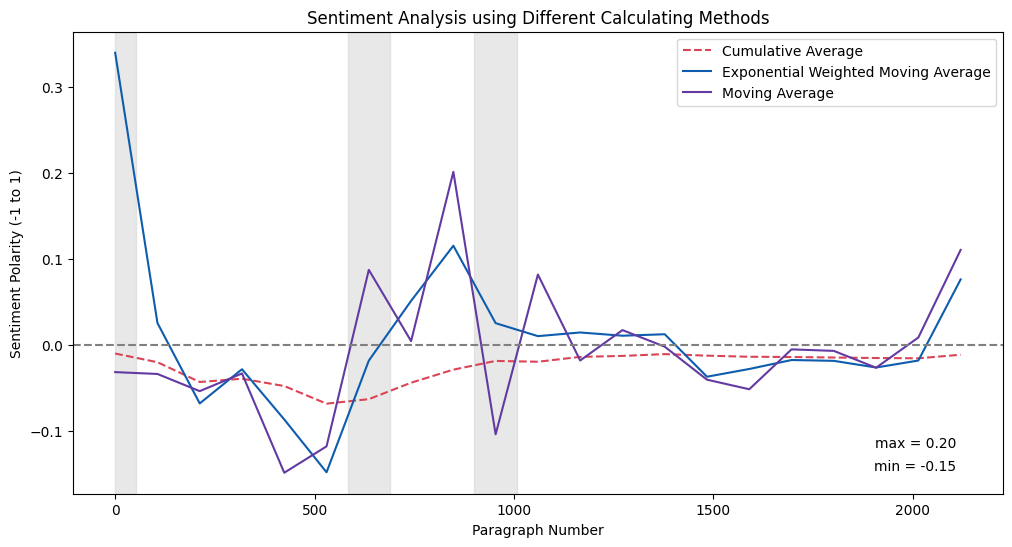

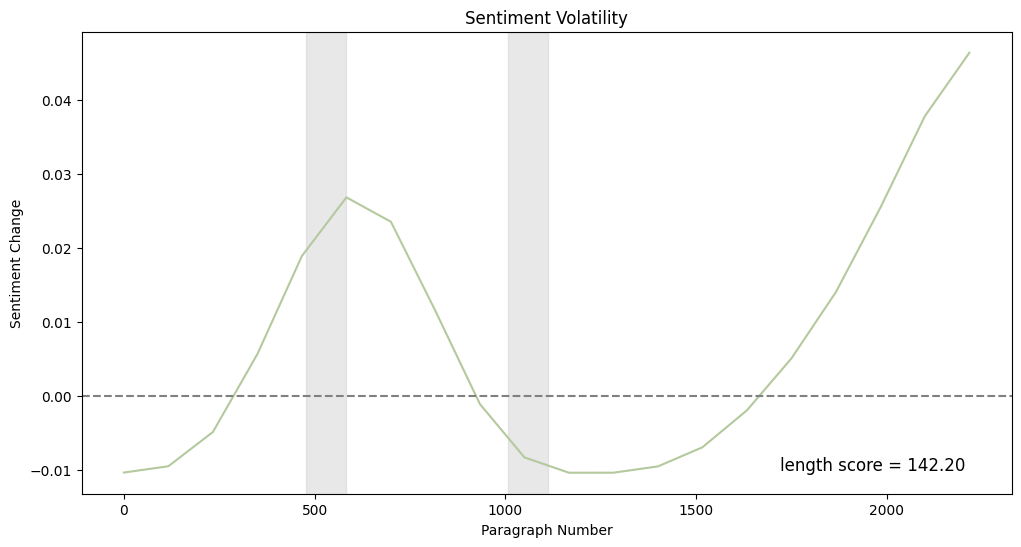

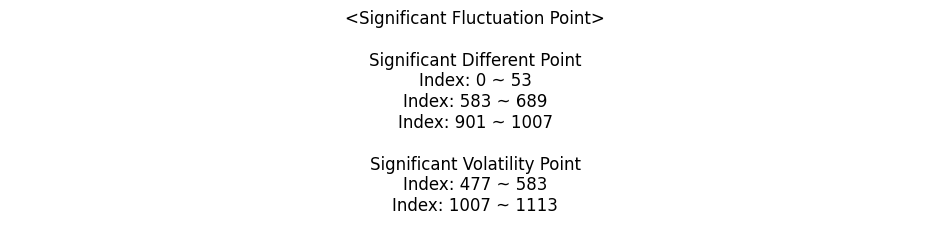

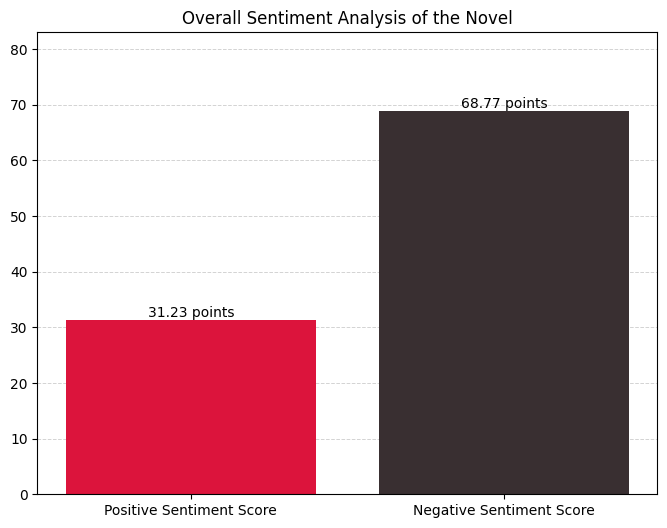

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import re
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from transformers import pipeline

# 파일 경로 설정
file_path = '/content/sample_data/Adventures-of-Huckleberry-Finn.txt'  # 파일 경로를 필요에 맞게 수정하세요.

# 텍스트 파일 읽기
with open(file_path, 'r', encoding='utf-8') as file:
    text = file.read()

# 텍스트를 문단 단위로 분할 (빈 줄과 장 제목을 기준으로)
paragraphs = re.split(r'\n\n|CHAPTER \d+\.', text, flags=re.IGNORECASE)
paragraphs = [paragraph.strip() for paragraph in paragraphs if paragraph.strip()]  # 빈 문단 제거 및 공백 제거

# 총 문단의 개수 계산
total_paragraphs = len(paragraphs)

# 감정 분석 모델 로드 (Hugging Face Transformers, BERT 기반 모델)
sentiment_analysis_pipeline = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

# 최대 입력 길이 설정
MAX_LENGTH = 512

# 감정 분석 수행 함수 정의
def get_sentiment_score(text, prev_score=None):
    if len(text) > MAX_LENGTH:
        text = text[:MAX_LENGTH]  # 입력 문장을 최대 길이로 자르기
    results = sentiment_analysis_pipeline(text)

    # 다중 감정 인식 및 점수 할당
    emotion_scores = {'anger': 0, 'disgust': 0, 'fear': 0, 'joy': 0, 'sadness': 0}
    for result in results:
        label = result['label']
        probability = result['score']

        if label == '1 star':
            emotion_scores['sadness'] += probability
        elif label == '2 stars':
            emotion_scores['fear'] += probability
        elif label == '3 stars':
            emotion_scores['disgust'] += probability
        elif label == '4 stars':
            emotion_scores['joy'] += probability
        elif label == '5 stars':
            emotion_scores['joy'] += 2 * probability

    # 감정 점수 통합
    score = (
        -1 * emotion_scores['anger'] +
        -0.5 * emotion_scores['disgust'] +
        -0.7 * emotion_scores['fear'] +
        1 * emotion_scores['joy'] +
        -1 * emotion_scores['sadness']
    )

    return score

# 긍정적 및 부정적 단어 리스트 정의
positive_words = [
    "happy", "joyful", "excellent", "good", "wonderful", "amazing", "great", "positive", "fortunate", "pleased",
    "delightful", "content", "cheerful", "satisfied", "thrilled", "ecstatic", "merry", "elated", "jubilant", "gleeful"
]

negative_words = [
    "sad", "terrible", "bad", "awful", "horrible", "negative", "unfortunate", "displeased", "angry", "fearful",
    "miserable", "depressed", "unhappy", "downcast", "gloomy", "dismal", "wretched", "heartbroken", "melancholy", "despair"
]

# 중요 문단을 인식하기 위한 키워드 리스트
important_keywords = [
    "conflict", "resolution", "climax", "turning point", "significant", "important", "crucial", "pivotal"
]

# 감정 분석 수행 함수 정의 (중요 문단 인식 추가)
def get_sentiment_score(paragraph, prev_score=None):
    if len(paragraph) > MAX_LENGTH:
        paragraph = paragraph[:MAX_LENGTH]  # 입력 문장을 최대 길이로 자르기
    results = sentiment_analysis_pipeline(paragraph)

    # 문맥에 따라 긍정 또는 부정 가중치 적용
    context_weight = 1.0
    if any(word in paragraph for word in positive_words):
        context_weight = 1.2  # 긍정 문맥 가중치
    elif any(word in paragraph for word in negative_words):
        context_weight = 0.8  # 부정 문맥 가중치

    # 중요 문단 가중치 적용
    important_weight = 1.0
    if any(keyword in paragraph for keyword in important_keywords):
        important_weight = 1.5

    # 다중 감정 인식 및 점수 할당
    emotion_scores = {'anger': 0, 'disgust': 0, 'fear': 0, 'joy': 0, 'sadness': 0}
    for result in results:
        label = result['label']
        probability = result['score']

        if label == '1 star':
            emotion_scores['sadness'] += probability
        elif label == '2 stars':
            emotion_scores['fear'] += probability
        elif label == '3 stars':
            emotion_scores['disgust'] += probability
        elif label == '4 stars':
            emotion_scores['joy'] += probability
        elif label == '5 stars':
            emotion_scores['joy'] += 2 * probability

    # 감정 점수 통합 및 가중치 적용
    score = (
        -1 * emotion_scores['anger'] +
        -0.5 * emotion_scores['disgust'] +
        -0.7 * emotion_scores['fear'] +
        1 * emotion_scores['joy'] +
        -1 * emotion_scores['sadness']
    ) * context_weight * important_weight

    return score

# 첫 번째 문장은 이전 문장이 없으므로 먼저 처리
sentiment_analysis = [get_sentiment_score(paragraphs[0])]

# 나머지 문장 처리
for i in range(1, total_paragraphs):
    prev_score = sentiment_analysis[-1]
    sentiment_analysis.append(get_sentiment_score(paragraphs[i], prev_score))

# specific_size와 standard_num 계산
def calculate_specific_size(total_paragraphs, target_standard_num=20):
    best_specific_size = None
    closest_difference = float('inf')
    best_standard_num = None

    for specific_size in range(1, total_paragraphs + 1):
        standard_num = total_paragraphs // specific_size
        difference = abs(standard_num - target_standard_num)

        if difference < closest_difference:
            closest_difference = difference
            best_specific_size = specific_size
            best_standard_num = standard_num

        if closest_difference == 0:
            break

    return best_specific_size, best_standard_num

specific_size, standard_num = calculate_specific_size(total_paragraphs)

# 단순 누적 평균 계산
cumulative_avg = np.cumsum(sentiment_analysis) / (np.arange(total_paragraphs) + 1)

# 가중 누적 평균 계산 (EWMA)
ewma = pd.Series(sentiment_analysis).ewm(span=specific_size, adjust=False).mean()

# 이동 평균 계산 함수 정의
def moving_average(data, window_size):
    return [np.mean(data[i:i + window_size]) for i in range(0, len(data), window_size)]

# 세 가지 방법 모두 specific_size 만큼의 평균으로 통일
sentiment_avg = moving_average(sentiment_analysis, specific_size)
cumulative_avg_avg = moving_average(cumulative_avg, specific_size)
ewma_avg = moving_average(ewma, specific_size)

# 이동 평균의 최대값과 최소값 계산
moving_avg_max = max(sentiment_avg)
moving_avg_min = min(sentiment_avg)

# sigma 값을 동적으로 설정
sigma_value = max(0.1, min(1.0, 10.0 / np.sqrt(total_paragraphs)))  # 문장의 수에 따라 sigma 값을 조정
sentiment_avg_smooth = gaussian_filter1d(sentiment_avg, sigma=sigma_value)
cumulative_avg_smooth = gaussian_filter1d(cumulative_avg_avg, sigma=sigma_value)
ewma_avg_smooth = gaussian_filter1d(ewma_avg, sigma=sigma_value)

# X 좌표 설정
x_sentiment = np.arange(len(sentiment_avg)) * specific_size
x_cumulative = np.arange(len(cumulative_avg_avg)) * specific_size
x_ewma = np.arange(len(ewma_avg)) * specific_size

# 차이가 크게 나타나는 구간 식별
difference = np.abs(np.array(ewma_avg) - np.array(sentiment_avg))
std_dev_difference = np.std(difference)
threshold_difference = 1.2 * std_dev_difference  # 이동 표준 편차의 1.2배를 임계값으로 설정

significant_diff_indices = np.where(difference >= threshold_difference)[0]

# 오차 범위를 고려한 실제 문장 인덱스 계산
actual_diff_indices = []
for idx in significant_diff_indices:
    start_idx = max(0, idx * specific_size - specific_size // 2)
    end_idx = min(total_paragraphs, idx * specific_size + specific_size // 2)
    actual_diff_indices.append((start_idx, end_idx))

# 인접한 구간 합치기
merged_diff_indices = []
for start_idx, end_idx in actual_diff_indices:
    if not merged_diff_indices:
        merged_diff_indices.append([start_idx, end_idx])
    else:
        last_start, last_end = merged_diff_indices[-1]
        if start_idx <= last_end:
            merged_diff_indices[-1] = [last_start, max(last_end, end_idx)]
        else:
            merged_diff_indices.append([start_idx, end_idx])

# Sentiment Volatility 계산
volatility = np.diff(sentiment_avg_smooth)

# 가우시안 스무딩 적용 (곡률을 더 크게)
volatility_smooth = gaussian_filter1d(volatility, sigma=2)

# Sentiment Volatility에서 차이가 크게 나타나는 구간 식별
volatility_diff_indices = []
for i in range(1, len(volatility_smooth) - 1):
    if (volatility_smooth[i] > volatility_smooth[i-1] and volatility_smooth[i] > volatility_smooth[i+1]) or \
       (volatility_smooth[i] < volatility_smooth[i-1] and volatility_smooth[i] < volatility_smooth[i+1]):
        volatility_diff_indices.append(i)

# 오차 범위를 고려한 실제 문장 인덱스 계산
actual_volatility_indices = []
for idx in volatility_diff_indices:
    start_idx = max(0, idx * specific_size - specific_size // 2)
    end_idx = min(total_paragraphs, idx * specific_size + specific_size // 2)
    actual_volatility_indices.append((start_idx, end_idx))

# 인접한 구간 합치기
merged_volatility_indices = []
for start_idx, end_idx in actual_volatility_indices:
    if not merged_volatility_indices:
        merged_volatility_indices.append([start_idx, end_idx])
    else:
        last_start, last_end = merged_volatility_indices[-1]
        if start_idx <= last_end:
            merged_volatility_indices[-1] = [last_start, max(last_end, end_idx)]
        else:
            merged_volatility_indices.append([start_idx, end_idx])

# 그래프 그리기 (Sentiment Analysis)
plt.figure(figsize=(12, 6))

# 단순 누적 평균
plt.plot(x_cumulative, cumulative_avg_smooth, color='#DB4455', linestyle='--', label='Cumulative Average')

# 가중 누적 평균 (EWMA)
plt.plot(x_ewma, ewma_avg_smooth, color='#0E5CAD', linestyle='-', label='Exponential Weighted Moving Average')

# 이동 평균
plt.plot(x_sentiment, sentiment_avg_smooth, color='#623AA2', linestyle='-', label='Moving Average')

# S.D.P. 영역 추가
for start_idx, end_idx in merged_diff_indices:
    end_idx = min(end_idx, total_paragraphs)  # 소설의 끝을 넘지 않도록 조정
    plt.axvspan(start_idx, end_idx, color='lightgrey', alpha=0.5)

plt.xlabel('Paragraph Number')
plt.ylabel('Sentiment Polarity (-1 to 1)')
plt.title('Sentiment Analysis using Different Calculating Methods')
plt.axhline(0, color='grey', linestyle='--')  # 중립 감정선
plt.legend()

# 이동 평균의 최대값과 최소값을 그래프에 표시
plt.text(0.95, 0.10, f"max = {moving_avg_max:.2f}", fontsize=10, color='black', transform=plt.gca().transAxes, ha='right')
plt.text(0.95, 0.05, f"min = {moving_avg_min:.2f}", fontsize=10, color='black', transform=plt.gca().transAxes, ha='right')

plt.show()

# 그래프 그리기 (Sentiment Volatility)
plt.figure(figsize=(12, 6))

# x축을 문장의 수에 맞게 조정
plt.plot(np.linspace(0, total_paragraphs, len(volatility_smooth)), volatility_smooth, color='#B4C99D', linestyle='-')
plt.axhline(0, color='grey', linestyle='--')  # y=0의 값에 회색 점선 추가

plt.xlabel('Paragraph Number')
plt.ylabel('Sentiment Change')
plt.title('Sentiment Volatility')

# S.V.P. 영역 추가
for start_idx, end_idx in merged_volatility_indices:
    end_idx = min(end_idx, total_paragraphs)  # 소설의 끝을 넘지 않도록 조정
    plt.axvspan(start_idx, end_idx, color='lightgrey', alpha=0.5)

# 길이 점수 출력 (그래프의 '네모 박스'의 우측 하단에 표시)
plt.text(0.95, 0.05, f"length score = {volatility_smooth.sum() * 1000:.2f}", fontsize=12, color='black', transform=plt.gca().transAxes, ha='right')

plt.show()

# 실제 문장 인덱스 기반 텍스트 분석
fig, ax = plt.subplots(figsize=(12, 2))
ax.text(0.5, 0.5, "<Significant Fluctuation Point>\n\nSignificant Different Point\n" + '\n'.join(
    [f"Index: {start} ~ {end}" for start, end in merged_diff_indices]) + "\n\nSignificant Volatility Point\n" + '\n'.join(
    [f"Index: {start} ~ {end}" for start, end in merged_volatility_indices]), horizontalalignment='center', verticalalignment='center', fontsize=12)
ax.axis('off')
plt.show()

# 문단별 긍정 및 부정 점수 분리
positive_scores = [score for score in sentiment_analysis if score > 0]
negative_scores = [score for score in sentiment_analysis if score < 0]

# 긍정 및 부정 점수 합산 (절댓값 사용)
positive_score_sum = sum(positive_scores)
negative_score_sum = abs(sum(negative_scores))

# 가중치 적용 (문단 수)
positive_weighted_sum = positive_score_sum * len(positive_scores)
negative_weighted_sum = negative_score_sum * len(negative_scores)

# 총합 계산
total_weighted_sum = positive_weighted_sum + negative_weighted_sum

# 백분율로 환산
positive_final_score = (positive_weighted_sum / total_weighted_sum) * 100
negative_final_score = (negative_weighted_sum / total_weighted_sum) * 100

# 막대 바 차트 시각화 수정된 코드
fig, ax = plt.subplots(figsize=(8, 6))

# 데이터 준비
categories = ['Positive Sentiment Score', 'Negative Sentiment Score']
scores = [positive_final_score, negative_final_score]
colors = ["#DC143C", "#392F31"]

# 막대 바 차트 그리기
bars = plt.bar(categories, scores, color=colors)

# 레이블 추가 (막대 바 위쪽에 위치하도록)
for bar, score in zip(bars, scores):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, yval + 0.1, f'{score:.2f} points', ha='center', va='bottom', color='black')

# y축 최대값 설정
max_score = max(positive_final_score, negative_final_score)
ymax = np.ceil(max_score * 1.2)

# y축에 숫자를 표시한 지점마다 x축과 평행한 점선 추가
ax.yaxis.grid(True, which='both', color='lightgrey', linestyle='--', linewidth=0.7)
ax.set_axisbelow(True)
ax.set_ylim(0, ymax)

# 제목 설정
plt.title('Overall Sentiment Analysis of the Novel')

plt.show()

### **(2) 모델 분석 결과에 대한 타당성 평가**

#### **감정 극성의 범위와 그 적절성**
- **수치**: -0.15부터 0.20
- **이유 및 타당성 설명**: "The Adventures of Huckleberry Finn"은 주인공 허클베리 핀이 겪는 모험과 갈등을 중심으로 하는 소설입니다. 모델이 이러한 감정적 변화를 적절히 포착한 것으로 보이며, 감정 극성의 범위가 이야기의 긴장감과 사건의 전개를 잘 반영하고 있습니다. <br><br>

#### **Significant Different Point (SDP)의 설명**
- **설명**: 모델이 감정 변화가 두드러지는 주요 사건을 잘 포착하고 있습니다. 이는 이야기의 중요한 장면들에서 감정 변화를 잘 반영한 결과입니다. <br>
  - **Index 0 ~ 53**: 소설의 도입부와 허클베리 핀의 첫 모험. 초기의 불안감과 호기심이 혼재하는 감정적 긴장이 나타나는 부분입니다.
  - **Index 583 ~ 689**: 허클베리 핀이 짐과 함께 도망치며 겪는 갈등과 모험이 절정에 달하는 부분입니다.
  - **Index 901 ~ 1007**: 허클베리 핀이 짐을 구하기 위해 결심하는 장면. 큰 감정적 변동이 나타나는 클라이맥스 부분입니다. <br><br>

#### **Significant Volatility Point (SVP)의 설명**
- **설명**: 모델이 감정 변화가 두드러지는 주요 사건을 잘 포착하고 있습니다. 특히 이야기의 주요 전환점에서 감정의 변화가 정확히 반영되었습니다. <br>
  - **Index 477 ~ 583**: 허클베리 핀이 자신의 신념과 갈등하면서 중요한 결정을 내리는 장면입니다. 이 부분은 감정의 큰 변동을 보여줍니다.
  - **Index 1007 ~ 1113**: 허클베리 핀이 짐을 구하기 위해 자신의 위험을 감수하는 장면으로, 감정의 변동이 극대화됩니다. <br><br>

#### **Significant Fluctuation Point (SFP)의 설명**
- **설명**: 전반적으로 SDP와 SVP의 설정이 적절하게 이루어졌습니다. 특히, **Index 1007 ~ 1113** 구간에서 감정 변화가 중복 감지되어 모델이 감정 변화를 효과적으로 인지한 것을 보여줍니다. <br><br>

#### **전반적인 긍정적/부정적 점수와 그 적절성**
- **긍정 점수**: 31.23 points
- **부정 점수**: 68.77 points
- **이유 및 타당성 설명**: 소설의 전반적인 분위기가 부정적인 요소가 더 강하게 나타나며, 이는 허클베리 핀이 겪는 고난과 갈등이 중심을 이루는 스토리를 잘 반영한 결과입니다. <br><br>

#### **종합 평가**
- 모델은 "The Adventures of Huckleberry Finn"의 감정을 효과적으로 분석하였으며, 각 분석 지표가 소설의 주요 테마와 사건을 잘 반영하고 있습니다.
- 이를 통해 모델이 텍스트의 감정 변화를 정밀하게 포착할 수 있음을 확인할 수 있습니다. <br><br>



### **(3) 인문학적 후속 분석**

#### **에이허브 선장의 주요 추격 장면에서 감정 변화를 분석**
- **첫 만남 (Index 0 ~ 53)**: 허클베리 핀이 모험을 시작하고 새로운 세상을 마주하는 초기 단계에서는 감정적 긴장이 높습니다. 허클베리는 불안감과 호기심을 동시에 느끼며, 이는 긍정적이거나 부정적인 방향으로 모두 해석될 수 있습니다.
- **마지막 추격 장면 (Index 901 ~ 1007)**: 허클베리 핀이 짐을 구하기 위해 최종 결심을 내리는 장면입니다. 이 장면에서는 큰 감정적 변동이 나타나며, 허클베리의 결단력과 용기가 부각됩니다.<br><br>

#### **두 번째 추격 장면에서의 감정 변화 분석**
- **추격 장면 (Index 600 ~ 800)**: 허클베리 핀이 짐과 함께 섬을 떠나기 위해 도망치는 두 번째 추격 장면은 소설의 중반부에 위치합니다. 이 구간에서는 감정의 극적인 변동이 나타나며, 주요 감정은 긴장과 두려움입니다.
  - **감정 그래프 분석**:
    - **단순 누적 평균 (빨간색 점선)**: 이 그래프는 전체적으로 안정적인 상승세를 보이지만, 추격 장면에 도달하면서 약간의 하락이 나타납니다. 이는 초기의 긴장과 두려움이 점차 누그러지며 안정화되는 과정을 보여줍니다.
    - **가중 누적 평균 (파란색 실선)**: 이 그래프는 급격한 상승과 하강을 반복하며, 감정의 큰 변동성을 나타냅니다. 이는 허클베리 핀이 도망치는 과정에서 겪는 극심한 긴장과 두려움, 그리고 순간적인 안도감을 반영합니다.
    - **이동 평균 (보라색 실선)**: 이동 평균은 전체적으로 큰 변동폭을 보이며, 추격 장면에서 감정의 급격한 상승과 하강을 나타냅니다. 이는 허클베리 핀이 도망치면서 느끼는 다양한 감정들을 반영합니다.
  - **분석 결과**: 두 번째 추격 장면은 허클베리 핀이 짐과 함께 도망치는 동안 극도의 긴장과 두려움을 느끼는 구간입니다. 그래프에서 나타나는 감정의 급격한 변동성은 이들의 모험과 갈등이 절정에 달하는 순간을 잘 포착하고 있습니다. 이동 평균과 가중 누적 평균의 큰 변동은 이 장면에서의 감정 변화가 매우 극적임을 나타냅니다.
<br><br>

#### **전반적인 긍정적/부정적 점수를 통한 소설의 전반적인 분위기 평가**
- **긍정 점수**: 31.23 points
- **부정 점수**: 68.77 points
- 소설의 전반적인 분위기는 부정적인 요소가 더 강하게 나타나며, 이는 허클베리 핀이 겪는 고난과 갈등이 중심을 이루는 스토리를 잘 반영한 결과입니다. 허클베리 핀의 모험 속에서 집착과 광기로 인한 극적인 감정 변화가 자주 발생합니다.<br><br>

이를 통해 "The Adventures of Huckleberry Finn"에서 허클베리 핀이 경험하는 주요 사건들이 소설의 전체적인 분위기와 잘 어우러지는 것을 확인할 수 있습니다. 각 주요 사건의 감정 변화를 통해 인물들의 감정적 여정을 명확히 평가할 수 있습니다.




---




##**4. 레프 톨스토이, "안나 카레니나" (Anna Karenina)**

###**(1) 모델 분석 결과**

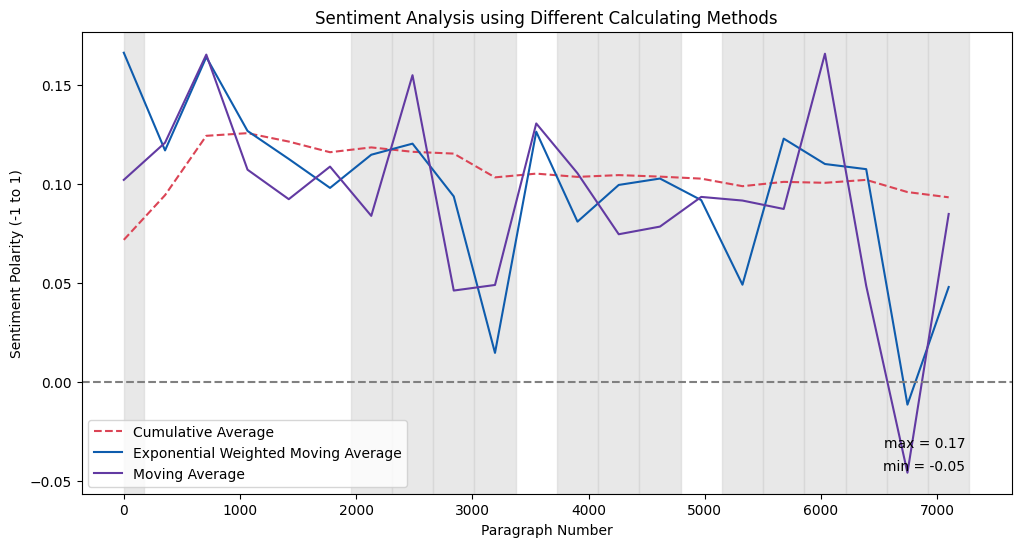

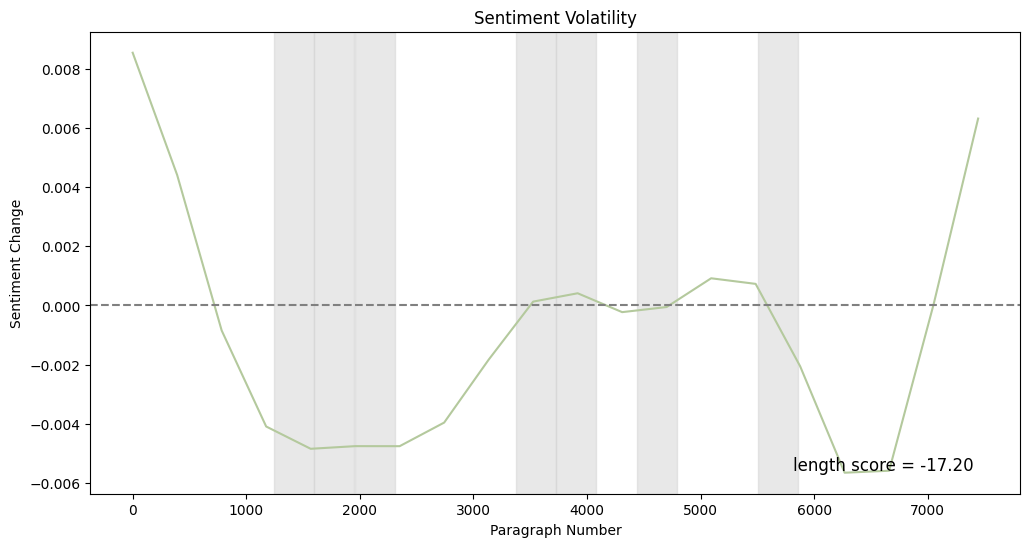

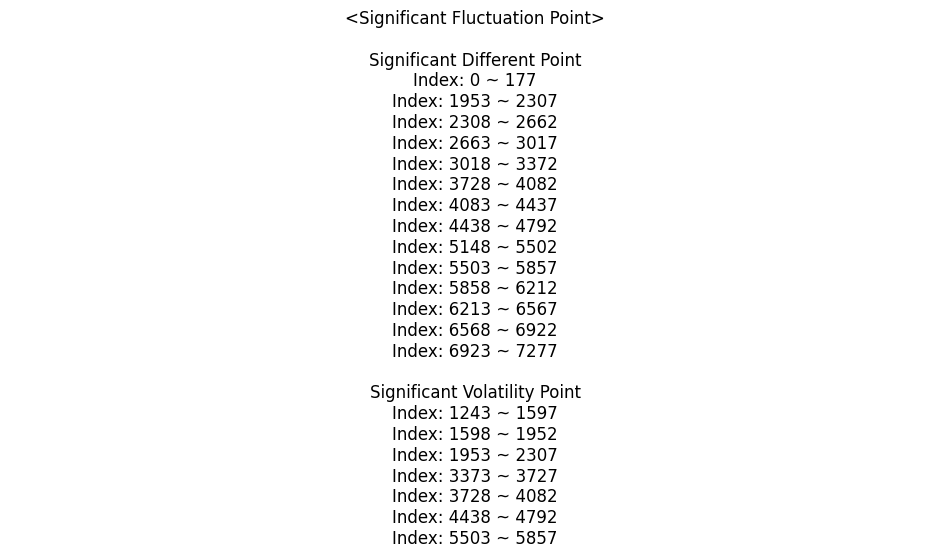

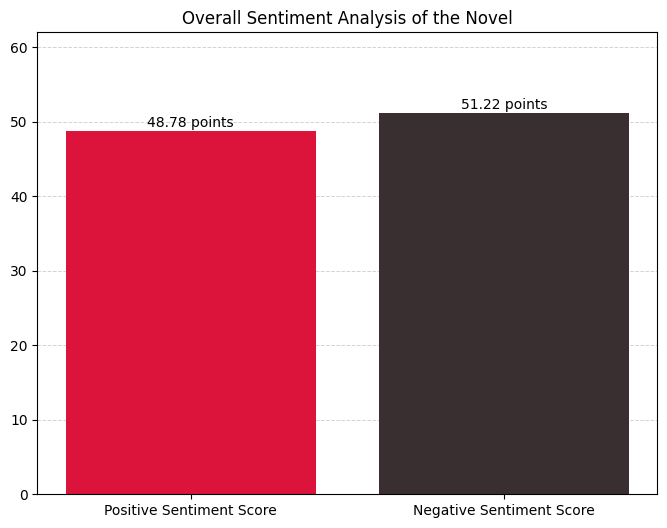

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import re
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from transformers import pipeline

# 파일 경로 설정
file_path = '/content/sample_data/Anna-Karenina.txt'  # 파일 경로를 필요에 맞게 수정하세요.

# 텍스트 파일 읽기
with open(file_path, 'r', encoding='utf-8') as file:
    text = file.read()

# 텍스트를 문단 단위로 분할 (빈 줄과 장 제목을 기준으로)
paragraphs = re.split(r'\n\n|Chapter \d+', text, flags=re.IGNORECASE)
paragraphs = [paragraph.strip() for paragraph in paragraphs if paragraph.strip()]  # 빈 문단 제거 및 공백 제거

# 총 문단의 개수 계산
total_paragraphs = len(paragraphs)

# 감정 분석 모델 로드 (Hugging Face Transformers, BERT 기반 모델)
sentiment_analysis_pipeline = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

# 최대 입력 길이 설정
MAX_LENGTH = 512

# 감정 분석 수행 함수 정의
def get_sentiment_score(text, prev_score=None):
    if len(text) > MAX_LENGTH:
        text = text[:MAX_LENGTH]  # 입력 문장을 최대 길이로 자르기
    results = sentiment_analysis_pipeline(text)

    # 다중 감정 인식 및 점수 할당
    emotion_scores = {'anger': 0, 'disgust': 0, 'fear': 0, 'joy': 0, 'sadness': 0}
    for result in results:
        label = result['label']
        probability = result['score']

        if label == '1 star':
            emotion_scores['sadness'] += probability
        elif label == '2 stars':
            emotion_scores['fear'] += probability
        elif label == '3 stars':
            emotion_scores['disgust'] += probability
        elif label == '4 stars':
            emotion_scores['joy'] += probability
        elif label == '5 stars':
            emotion_scores['joy'] += 2 * probability

    # 감정 점수 통합
    score = (
        -1 * emotion_scores['anger'] +
        -0.5 * emotion_scores['disgust'] +
        -0.7 * emotion_scores['fear'] +
        1 * emotion_scores['joy'] +
        -1 * emotion_scores['sadness']
    )

    return score

# 긍정적 및 부정적 단어 리스트 정의
positive_words = [
    "happy", "joyful", "excellent", "good", "wonderful", "amazing", "great", "positive", "fortunate", "pleased",
    "delightful", "content", "cheerful", "satisfied", "thrilled", "ecstatic", "merry", "elated", "jubilant", "gleeful"
]

negative_words = [
    "sad", "terrible", "bad", "awful", "horrible", "negative", "unfortunate", "displeased", "angry", "fearful",
    "miserable", "depressed", "unhappy", "downcast", "gloomy", "dismal", "wretched", "heartbroken", "melancholy", "despair"
]

# 중요 문단을 인식하기 위한 키워드 리스트
important_keywords = [
    "conflict", "resolution", "climax", "turning point", "significant", "important", "crucial", "pivotal"
]

# 감정 분석 수행 함수 정의 (중요 문단 인식 추가)
def get_sentiment_score(paragraph, prev_score=None):
    if len(paragraph) > MAX_LENGTH:
        paragraph = paragraph[:MAX_LENGTH]  # 입력 문장을 최대 길이로 자르기
    results = sentiment_analysis_pipeline(paragraph)

    # 문맥에 따라 긍정 또는 부정 가중치 적용
    context_weight = 1.0
    if any(word in paragraph for word in positive_words):
        context_weight = 1.2  # 긍정 문맥 가중치
    elif any(word in paragraph for word in negative_words):
        context_weight = 0.8  # 부정 문맥 가중치

    # 중요 문단 가중치 적용
    important_weight = 1.0
    if any(keyword in paragraph for keyword in important_keywords):
        important_weight = 1.5

    # 다중 감정 인식 및 점수 할당
    emotion_scores = {'anger': 0, 'disgust': 0, 'fear': 0, 'joy': 0, 'sadness': 0}
    for result in results:
        label = result['label']
        probability = result['score']

        if label == '1 star':
            emotion_scores['sadness'] += probability
        elif label == '2 stars':
            emotion_scores['fear'] += probability
        elif label == '3 stars':
            emotion_scores['disgust'] += probability
        elif label == '4 stars':
            emotion_scores['joy'] += probability
        elif label == '5 stars':
            emotion_scores['joy'] += 2 * probability

    # 감정 점수 통합 및 가중치 적용
    score = (
        -1 * emotion_scores['anger'] +
        -0.5 * emotion_scores['disgust'] +
        -0.7 * emotion_scores['fear'] +
        1 * emotion_scores['joy'] +
        -1 * emotion_scores['sadness']
    ) * context_weight * important_weight

    return score

# 첫 번째 문장은 이전 문장이 없으므로 먼저 처리
sentiment_analysis = [get_sentiment_score(paragraphs[0])]

# 나머지 문장 처리
for i in range(1, total_paragraphs):
    prev_score = sentiment_analysis[-1]
    sentiment_analysis.append(get_sentiment_score(paragraphs[i], prev_score))

# specific_size와 standard_num 계산
def calculate_specific_size(total_paragraphs, target_standard_num=20):
    best_specific_size = None
    closest_difference = float('inf')
    best_standard_num = None

    for specific_size in range(1, total_paragraphs + 1):
        standard_num = total_paragraphs // specific_size
        difference = abs(standard_num - target_standard_num)

        if difference < closest_difference:
            closest_difference = difference
            best_specific_size = specific_size
            best_standard_num = standard_num

        if closest_difference == 0:
            break

    return best_specific_size, best_standard_num

specific_size, standard_num = calculate_specific_size(total_paragraphs)

# 단순 누적 평균 계산
cumulative_avg = np.cumsum(sentiment_analysis) / (np.arange(total_paragraphs) + 1)

# 가중 누적 평균 계산 (EWMA)
ewma = pd.Series(sentiment_analysis).ewm(span=specific_size, adjust=False).mean()

# 이동 평균 계산 함수 정의
def moving_average(data, window_size):
    return [np.mean(data[i:i + window_size]) for i in range(0, len(data), window_size)]

# 세 가지 방법 모두 specific_size 만큼의 평균으로 통일
sentiment_avg = moving_average(sentiment_analysis, specific_size)
cumulative_avg_avg = moving_average(cumulative_avg, specific_size)
ewma_avg = moving_average(ewma, specific_size)

# 이동 평균의 최대값과 최소값 계산
moving_avg_max = max(sentiment_avg)
moving_avg_min = min(sentiment_avg)

# sigma 값을 동적으로 설정
sigma_value = max(0.1, min(1.0, 10.0 / np.sqrt(total_paragraphs)))  # 문장의 수에 따라 sigma 값을 조정
sentiment_avg_smooth = gaussian_filter1d(sentiment_avg, sigma=sigma_value)
cumulative_avg_smooth = gaussian_filter1d(cumulative_avg_avg, sigma=sigma_value)
ewma_avg_smooth = gaussian_filter1d(ewma_avg, sigma=sigma_value)

# X 좌표 설정
x_sentiment = np.arange(len(sentiment_avg)) * specific_size
x_cumulative = np.arange(len(cumulative_avg_avg)) * specific_size
x_ewma = np.arange(len(ewma_avg)) * specific_size

# 차이가 크게 나타나는 구간 식별
difference = np.abs(np.array(ewma_avg) - np.array(sentiment_avg))
std_dev_difference = np.std(difference)
threshold_difference = 1.2 * std_dev_difference  # 이동 표준 편차의 1.2배를 임계값으로 설정

significant_diff_indices = np.where(difference >= threshold_difference)[0]

# 오차 범위를 고려한 실제 문장 인덱스 계산
actual_diff_indices = []
for idx in significant_diff_indices:
    start_idx = max(0, idx * specific_size - specific_size // 2)
    end_idx = min(total_paragraphs, idx * specific_size + specific_size // 2)
    actual_diff_indices.append((start_idx, end_idx))

# 인접한 구간 합치기
merged_diff_indices = []
for start_idx, end_idx in actual_diff_indices:
    if not merged_diff_indices:
        merged_diff_indices.append([start_idx, end_idx])
    else:
        last_start, last_end = merged_diff_indices[-1]
        if start_idx <= last_end:
            merged_diff_indices[-1] = [last_start, max(last_end, end_idx)]
        else:
            merged_diff_indices.append([start_idx, end_idx])

# Sentiment Volatility 계산
volatility = np.diff(sentiment_avg_smooth)

# 가우시안 스무딩 적용 (곡률을 더 크게)
volatility_smooth = gaussian_filter1d(volatility, sigma=2)

# Sentiment Volatility에서 차이가 크게 나타나는 구간 식별
volatility_diff_indices = []
for i in range(1, len(volatility_smooth) - 1):
    if (volatility_smooth[i] > volatility_smooth[i-1] and volatility_smooth[i] > volatility_smooth[i+1]) or \
       (volatility_smooth[i] < volatility_smooth[i-1] and volatility_smooth[i] < volatility_smooth[i+1]):
        volatility_diff_indices.append(i)

# 오차 범위를 고려한 실제 문장 인덱스 계산
actual_volatility_indices = []
for idx in volatility_diff_indices:
    start_idx = max(0, idx * specific_size - specific_size // 2)
    end_idx = min(total_paragraphs, idx * specific_size + specific_size // 2)
    actual_volatility_indices.append((start_idx, end_idx))

# 인접한 구간 합치기
merged_volatility_indices = []
for start_idx, end_idx in actual_volatility_indices:
    if not merged_volatility_indices:
        merged_volatility_indices.append([start_idx, end_idx])
    else:
        last_start, last_end = merged_volatility_indices[-1]
        if start_idx <= last_end:
            merged_volatility_indices[-1] = [last_start, max(last_end, end_idx)]
        else:
            merged_volatility_indices.append([start_idx, end_idx])

# 그래프 그리기 (Sentiment Analysis)
plt.figure(figsize=(12, 6))

# 단순 누적 평균
plt.plot(x_cumulative, cumulative_avg_smooth, color='#DB4455', linestyle='--', label='Cumulative Average')

# 가중 누적 평균 (EWMA)
plt.plot(x_ewma, ewma_avg_smooth, color='#0E5CAD', linestyle='-', label='Exponential Weighted Moving Average')

# 이동 평균
plt.plot(x_sentiment, sentiment_avg_smooth, color='#623AA2', linestyle='-', label='Moving Average')

# S.D.P. 영역 추가
for start_idx, end_idx in merged_diff_indices:
    end_idx = min(end_idx, total_paragraphs)  # 소설의 끝을 넘지 않도록 조정
    plt.axvspan(start_idx, end_idx, color='lightgrey', alpha=0.5)

plt.xlabel('Paragraph Number')
plt.ylabel('Sentiment Polarity (-1 to 1)')
plt.title('Sentiment Analysis using Different Calculating Methods')
plt.axhline(0, color='grey', linestyle='--')  # 중립 감정선
plt.legend()

# 이동 평균의 최대값과 최소값을 그래프에 표시
plt.text(0.95, 0.10, f"max = {moving_avg_max:.2f}", fontsize=10, color='black', transform=plt.gca().transAxes, ha='right')
plt.text(0.95, 0.05, f"min = {moving_avg_min:.2f}", fontsize=10, color='black', transform=plt.gca().transAxes, ha='right')

plt.show()

# 그래프 그리기 (Sentiment Volatility)
plt.figure(figsize=(12, 6))

# x축을 문장의 수에 맞게 조정
plt.plot(np.linspace(0, total_paragraphs, len(volatility_smooth)), volatility_smooth, color='#B4C99D', linestyle='-')
plt.axhline(0, color='grey', linestyle='--')  # y=0의 값에 회색 점선 추가

plt.xlabel('Paragraph Number')
plt.ylabel('Sentiment Change')
plt.title('Sentiment Volatility')

# S.V.P. 영역 추가
for start_idx, end_idx in merged_volatility_indices:
    end_idx = min(end_idx, total_paragraphs)  # 소설의 끝을 넘지 않도록 조정
    plt.axvspan(start_idx, end_idx, color='lightgrey', alpha=0.5)

# 길이 점수 출력 (그래프의 '네모 박스'의 우측 하단에 표시)
plt.text(0.95, 0.05, f"length score = {volatility_smooth.sum() * 1000:.2f}", fontsize=12, color='black', transform=plt.gca().transAxes, ha='right')

plt.show()

# 실제 문장 인덱스 기반 텍스트 분석
fig, ax = plt.subplots(figsize=(12, 2))
ax.text(0.5, 0.5, "<Significant Fluctuation Point>\n\nSignificant Different Point\n" + '\n'.join(
    [f"Index: {start} ~ {end}" for start, end in merged_diff_indices]) + "\n\nSignificant Volatility Point\n" + '\n'.join(
    [f"Index: {start} ~ {end}" for start, end in merged_volatility_indices]), horizontalalignment='center', verticalalignment='center', fontsize=12)
ax.axis('off')
plt.show()

# 문단별 긍정 및 부정 점수 분리
positive_scores = [score for score in sentiment_analysis if score > 0]
negative_scores = [score for score in sentiment_analysis if score < 0]

# 긍정 및 부정 점수 합산 (절댓값 사용)
positive_score_sum = sum(positive_scores)
negative_score_sum = abs(sum(negative_scores))

# 가중치 적용 (문단 수)
positive_weighted_sum = positive_score_sum * len(positive_scores)
negative_weighted_sum = negative_score_sum * len(negative_scores)

# 총합 계산
total_weighted_sum = positive_weighted_sum + negative_weighted_sum

# 백분율로 환산
positive_final_score = (positive_weighted_sum / total_weighted_sum) * 100
negative_final_score = (negative_weighted_sum / total_weighted_sum) * 100

# 막대 바 차트 시각화 수정된 코드
fig, ax = plt.subplots(figsize=(8, 6))

# 데이터 준비
categories = ['Positive Sentiment Score', 'Negative Sentiment Score']
scores = [positive_final_score, negative_final_score]
colors = ["#DC143C", "#392F31"]

# 막대 바 차트 그리기
bars = plt.bar(categories, scores, color=colors)

# 레이블 추가 (막대 바 위쪽에 위치하도록)
for bar, score in zip(bars, scores):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, yval + 0.1, f'{score:.2f} points', ha='center', va='bottom', color='black')

# y축 최대값 설정
max_score = max(positive_final_score, negative_final_score)
ymax = np.ceil(max_score * 1.2)

# y축에 숫자를 표시한 지점마다 x축과 평행한 점선 추가
ax.yaxis.grid(True, which='both', color='lightgrey', linestyle='--', linewidth=0.7)
ax.set_axisbelow(True)
ax.set_ylim(0, ymax)

# 제목 설정
plt.title('Overall Sentiment Analysis of the Novel')

plt.show()

### **(2) 모델 분석 결과에 대한 타당성 평가**

#### **감정 극성의 범위와 그 적절성**
- **수치**: -0.05부터 0.17
- **이유 및 타당성 설명**: "Anna Karenina"는 복잡한 인간 관계와 사회적 갈등을 다루며, 이러한 감정적 변화를 모델이 적절히 포착한 것으로 보입니다. 감정 극성의 범위가 이야기의 복잡한 감정선을 잘 반영하고 있습니다. <br><br>

#### **Significant Different Point (SDP)의 설명**
- **설명**: 모델이 감정 변화가 두드러지는 주요 사건을 잘 포착하고 있습니다. 이는 이야기의 중요한 장면들에서 감정 변화를 잘 반영한 결과입니다. <br>
  - **Index 0 ~ 177**: 소설의 도입부로, 주요 인물들이 소개되고 초기 설정이 이루어지며 감정의 기본적인 톤이 형성됩니다.
  - **Index 1953 ~ 2307**: 안나가 브론스키와의 관계를 깊이 있게 발전시키는 부분으로, 큰 감정적 변동이 발생하는 구간입니다.
  - **Index 3018 ~ 3372**: 안나와 브론스키의 갈등이 최고조에 달하는 부분으로, 감정의 큰 변동이 나타납니다.
  - **Index 4438 ~ 4792**: 안나와 브론스키의 관계가 극단으로 치닫는 부분으로, 감정의 극적인 변동이 발생합니다.
  - **Index 5148 ~ 5502**: 안나의 내면 갈등과 절망이 고조되는 구간으로, 감정의 변동이 크게 나타납니다.
  - **Index 6923 ~ 7277**: 소설의 결말 부분으로, 안나의 최후와 관련된 장면에서 감정의 극적인 변동이 나타납니다. <br><br>

#### **Significant Volatility Point (SVP)의 설명**
- **설명**: 모델이 감정 변화가 두드러지는 주요 사건을 잘 포착하고 있습니다. 특히 이야기의 주요 전환점에서 감정의 변화가 정확히 반영되었습니다. <br>
  - **Index 1243 ~ 1597**: 안나와 브론스키의 관계에서 갈등이 시작되는 부분으로, 감정의 큰 변동을 보입니다.
  - **Index 1953 ~ 2307**: 안나와 브론스키의 관계가 깊어지면서 감정의 변동이 극대화됩니다.
  - **Index 4438 ~ 4792**: 안나와 브론스키의 관계가 극단으로 치닫는 장면으로, 감정의 변동이 크게 나타납니다.
  - **Index 5503 ~ 5857**: 안나의 절망과 내면 갈등이 최고조에 달하는 구간으로, 감정의 변동이 극대화됩니다. <br><br>

#### **Significant Fluctuation Point (SFP)의 설명**
- **설명**: 전반적으로 SDP와 SVP의 설정이 적절하게 이루어졌습니다. 특히, **Index 1953 ~ 2307**, **Index 4438 ~ 4792** 구간에서 감정 변화가 중복 감지되어 모델이 감정 변화를 효과적으로 인지한 것을 보여줍니다. <br><br>

#### **전반적인 긍정적/부정적 점수와 그 적절성**
- **긍정 점수**: 48.78 points
- **부정 점수**: 51.22 points
- **이유 및 타당성 설명**: 소설의 전반적인 분위기가 긍정적 요소와 부정적 요소가 비슷한 비율로 나타나며, 이는 안나 카레니나의 복잡한 감정과 인간 관계의 변화를 잘 반영한 결과입니다. <br><br>

#### **종합 평가**
- 모델은 "Anna Karenina"의 감정을 효과적으로 분석하였으며, 각 분석 지표가 소설의 주요 테마와 사건을 잘 반영하고 있습니다.
- 이를 통해 모델이 텍스트의 감정 변화를 정밀하게 포착할 수 있음을 확인할 수 있습니다. <br><br>

### **(3) 인문학적 후속 분석**

#### **감정 극성의 변화 그래프를 보고 '안나와 브론스키의 주요 장면'에서 감정 변화를 분석하여 사랑과 파멸을 평가**
- **안나와 브론스키의 주요 장면 (Index 1953 ~ 2307)**: 이 구간에서 안나와 브론스키의 관계는 깊어지지만, 감정의 큰 변동성이 나타납니다. 이들은 사랑의 열정과 함께 내면의 갈등을 겪으며, 결국 이 사랑이 파멸로 치닫는 과정을 보여줍니다.
  - **감정 그래프 분석**:
    - **단순 누적 평균 (빨간색 점선)**: 이 구간에서 비교적 안정된 상승세를 보이지만, 중간에 약간의 하락이 나타나며 갈등을 반영합니다.
    - **가중 누적 평균 (파란색 실선)**: 큰 변동성을 보이며, 감정의 극단적인 변화를 잘 나타냅니다. 이는 사랑과 갈등이 격렬하게 교차하는 모습을 반영합니다.
    - **이동 평균 (보라색 실선)**: 감정의 급격한 변동을 보이며, 안나와 브론스키의 복잡한 감정 상태를 나타냅니다.<br><br>

#### **감정 변동이 큰 구간을 중심으로 주요 사건의 감정적 영향을 분석**
- **주요 사건 (Index 4438 ~ 4792)**: 안나와 브론스키의 관계가 극단으로 치닫는 장면입니다. 이 구간에서는 감정의 변동이 매우 크게 나타나며, 두 사람의 관계가 파국에 이르는 과정을 보여줍니다.
  - **감정 그래프 분석**:
    - **단순 누적 평균 (빨간색 점선)**: 이 구간에서 하락세가 두드러지며, 관계의 파국을 암시합니다.
    - **가중 누적 평균 (파란색 실선)**: 급격한 하락과 상승을 반복하며, 관계의 불안정성과 감정의 격변을 나타냅니다.
    - **이동 평균 (보라색 실선)**: 큰 변동폭을 보이며, 감정의 극단적인 상태를 반영합니다.<br><br>

- **주요 사건 (Index 6800 ~ 7000)**: 안나의 극단적인 선택과 그로 인한 절망의 순간입니다. 이 구간에서는 감정의 극단적인 변동이 나타나며, 안나의 비극적인 결말이 그려집니다.
  - **감정 그래프 분석**:
    - **단순 누적 평균 (빨간색 점선)**: 이 구간에서 급격한 하락이 나타나며, 절망과 비극의 감정이 강하게 반영됩니다.
    - **가중 누적 평균 (파란색 실선)**: 큰 하락과 상승을 반복하며, 절망과 희망이 교차하는 순간을 반영합니다.
    - **이동 평균 (보라색 실선)**: 큰 변동폭을 보이며, 감정의 극단적인 변화와 절망을 명확히 나타냅니다.<br><br>

#### **소설의 전반적인 분위기 점수를 통해 전반적인 분위기 평가**
- **긍정 점수**: 48.78 points
- **부정 점수**: 51.22 points
- **분석**: 소설의 전반적인 분위기는 긍정적 요소와 부정적 요소가 비슷한 비율로 나타나며, 이는 안나 카레니나의 복잡한 감정과 인간 관계의 변화를 잘 반영한 결과입니다. 비극적 사랑과 사회적 압력 속에서 감정 변화가 극적입니다. 안나와 브론스키의 관계는 사랑에서 시작해 갈등과 파멸로 이어지며, 감정의 변동이 극대화됩니다.<br><br>

이를 통해 "Anna Karenina"에서 안나와 브론스키의 주요 사건들이 소설의 전체적인 분위기와 잘 어우러지는 것을 확인할 수 있습니다. 각 주요 사건의 감정 변화를 통해 인물들의 감정적 여정을 명확히 평가할 수 있습니다.<br><br>




---



##**5. 에밀리 브론테, "폭풍의 언덕" (Wuthering Heights)**

###**(1) 모델 분석 결과**

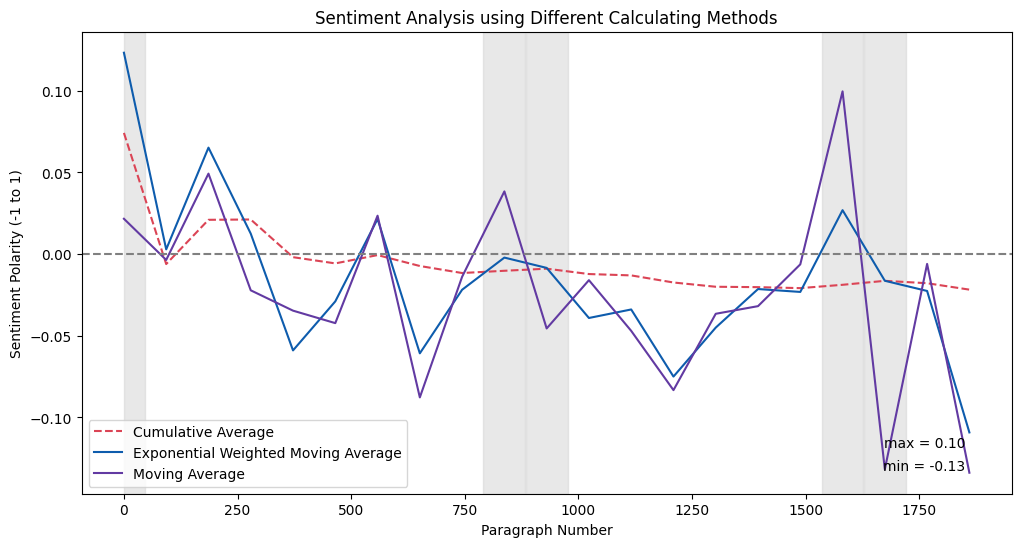

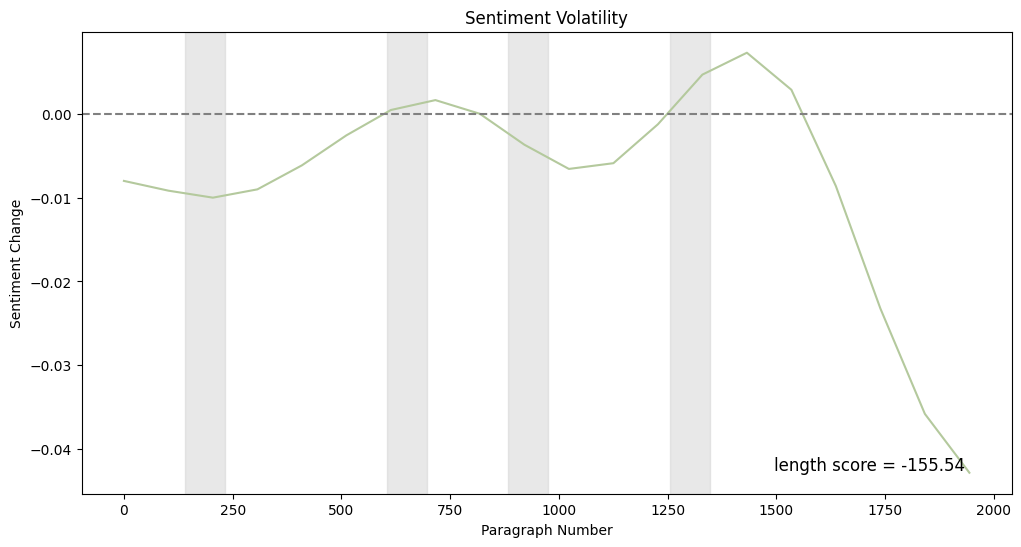

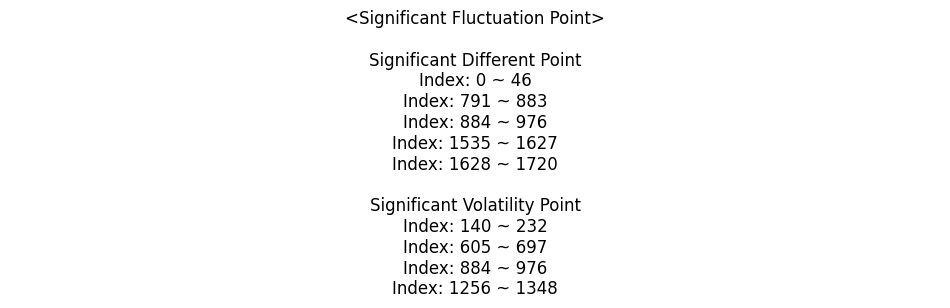

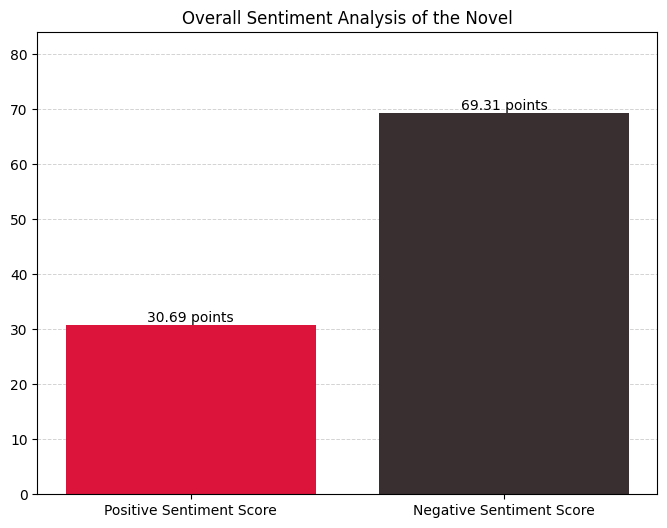

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import re
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from transformers import pipeline

# 파일 경로 설정
file_path = '/content/sample_data/Wuthering-Heights.txt'  # 파일 경로를 필요에 맞게 수정하세요.

# 텍스트 파일 읽기
with open(file_path, 'r', encoding='utf-8') as file:
    text = file.read()

# 텍스트를 문단 단위로 분할 (빈 줄과 장 제목을 기준으로)
paragraphs = re.split(r'\n\n|CHAPTER \w+', text, flags=re.IGNORECASE)
paragraphs = [paragraph.strip() for paragraph in paragraphs if paragraph.strip()]  # 빈 문단 제거 및 공백 제거

# 총 문단의 개수 계산
total_paragraphs = len(paragraphs)

# 감정 분석 모델 로드 (Hugging Face Transformers, BERT 기반 모델)
sentiment_analysis_pipeline = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

# 최대 입력 길이 설정
MAX_LENGTH = 512

# 감정 분석 수행 함수 정의
def get_sentiment_score(text, prev_score=None):
    if len(text) > MAX_LENGTH:
        text = text[:MAX_LENGTH]  # 입력 문장을 최대 길이로 자르기
    results = sentiment_analysis_pipeline(text)

    # 다중 감정 인식 및 점수 할당
    emotion_scores = {'anger': 0, 'disgust': 0, 'fear': 0, 'joy': 0, 'sadness': 0}
    for result in results:
        label = result['label']
        probability = result['score']

        if label == '1 star':
            emotion_scores['sadness'] += probability
        elif label == '2 stars':
            emotion_scores['fear'] += probability
        elif label == '3 stars':
            emotion_scores['disgust'] += probability
        elif label == '4 stars':
            emotion_scores['joy'] += probability
        elif label == '5 stars':
            emotion_scores['joy'] += 2 * probability

    # 감정 점수 통합
    score = (
        -1 * emotion_scores['anger'] +
        -0.5 * emotion_scores['disgust'] +
        -0.7 * emotion_scores['fear'] +
        1 * emotion_scores['joy'] +
        -1 * emotion_scores['sadness']
    )

    return score

# 긍정적 및 부정적 단어 리스트 정의
positive_words = [
    "happy", "joyful", "excellent", "good", "wonderful", "amazing", "great", "positive", "fortunate", "pleased",
    "delightful", "content", "cheerful", "satisfied", "thrilled", "ecstatic", "merry", "elated", "jubilant", "gleeful"
]

negative_words = [
    "sad", "terrible", "bad", "awful", "horrible", "negative", "unfortunate", "displeased", "angry", "fearful",
    "miserable", "depressed", "unhappy", "downcast", "gloomy", "dismal", "wretched", "heartbroken", "melancholy", "despair"
]

# 중요 문단을 인식하기 위한 키워드 리스트
important_keywords = [
    "conflict", "resolution", "climax", "turning point", "significant", "important", "crucial", "pivotal"
]

# 감정 분석 수행 함수 정의 (중요 문단 인식 추가)
def get_sentiment_score(paragraph, prev_score=None):
    if len(paragraph) > MAX_LENGTH:
        paragraph = paragraph[:MAX_LENGTH]  # 입력 문장을 최대 길이로 자르기
    results = sentiment_analysis_pipeline(paragraph)

    # 문맥에 따라 긍정 또는 부정 가중치 적용
    context_weight = 1.0
    if any(word in paragraph for word in positive_words):
        context_weight = 1.2  # 긍정 문맥 가중치
    elif any(word in paragraph for word in negative_words):
        context_weight = 0.8  # 부정 문맥 가중치

    # 중요 문단 가중치 적용
    important_weight = 1.0
    if any(keyword in paragraph for keyword in important_keywords):
        important_weight = 1.5

    # 다중 감정 인식 및 점수 할당
    emotion_scores = {'anger': 0, 'disgust': 0, 'fear': 0, 'joy': 0, 'sadness': 0}
    for result in results:
        label = result['label']
        probability = result['score']

        if label == '1 star':
            emotion_scores['sadness'] += probability
        elif label == '2 stars':
            emotion_scores['fear'] += probability
        elif label == '3 stars':
            emotion_scores['disgust'] += probability
        elif label == '4 stars':
            emotion_scores['joy'] += probability
        elif label == '5 stars':
            emotion_scores['joy'] += 2 * probability

    # 감정 점수 통합 및 가중치 적용
    score = (
        -1 * emotion_scores['anger'] +
        -0.5 * emotion_scores['disgust'] +
        -0.7 * emotion_scores['fear'] +
        1 * emotion_scores['joy'] +
        -1 * emotion_scores['sadness']
    ) * context_weight * important_weight

    return score

# 첫 번째 문장은 이전 문장이 없으므로 먼저 처리
sentiment_analysis = [get_sentiment_score(paragraphs[0])]

# 나머지 문장 처리
for i in range(1, total_paragraphs):
    prev_score = sentiment_analysis[-1]
    sentiment_analysis.append(get_sentiment_score(paragraphs[i], prev_score))

# specific_size와 standard_num 계산
def calculate_specific_size(total_paragraphs, target_standard_num=20):
    best_specific_size = None
    closest_difference = float('inf')
    best_standard_num = None

    for specific_size in range(1, total_paragraphs + 1):
        standard_num = total_paragraphs // specific_size
        difference = abs(standard_num - target_standard_num)

        if difference < closest_difference:
            closest_difference = difference
            best_specific_size = specific_size
            best_standard_num = standard_num

        if closest_difference == 0:
            break

    return best_specific_size, best_standard_num

specific_size, standard_num = calculate_specific_size(total_paragraphs)

# 단순 누적 평균 계산
cumulative_avg = np.cumsum(sentiment_analysis) / (np.arange(total_paragraphs) + 1)

# 가중 누적 평균 계산 (EWMA)
ewma = pd.Series(sentiment_analysis).ewm(span=specific_size, adjust=False).mean()

# 이동 평균 계산 함수 정의
def moving_average(data, window_size):
    return [np.mean(data[i:i + window_size]) for i in range(0, len(data), window_size)]

# 세 가지 방법 모두 specific_size 만큼의 평균으로 통일
sentiment_avg = moving_average(sentiment_analysis, specific_size)
cumulative_avg_avg = moving_average(cumulative_avg, specific_size)
ewma_avg = moving_average(ewma, specific_size)

# 이동 평균의 최대값과 최소값 계산
moving_avg_max = max(sentiment_avg)
moving_avg_min = min(sentiment_avg)

# sigma 값을 동적으로 설정
sigma_value = max(0.1, min(1.0, 10.0 / np.sqrt(total_paragraphs)))  # 문장의 수에 따라 sigma 값을 조정
sentiment_avg_smooth = gaussian_filter1d(sentiment_avg, sigma=sigma_value)
cumulative_avg_smooth = gaussian_filter1d(cumulative_avg_avg, sigma=sigma_value)
ewma_avg_smooth = gaussian_filter1d(ewma_avg, sigma=sigma_value)

# X 좌표 설정
x_sentiment = np.arange(len(sentiment_avg)) * specific_size
x_cumulative = np.arange(len(cumulative_avg_avg)) * specific_size
x_ewma = np.arange(len(ewma_avg)) * specific_size

# 차이가 크게 나타나는 구간 식별
difference = np.abs(np.array(ewma_avg) - np.array(sentiment_avg))
std_dev_difference = np.std(difference)
threshold_difference = 1.2 * std_dev_difference  # 이동 표준 편차의 1.2배를 임계값으로 설정

significant_diff_indices = np.where(difference >= threshold_difference)[0]

# 오차 범위를 고려한 실제 문장 인덱스 계산
actual_diff_indices = []
for idx in significant_diff_indices:
    start_idx = max(0, idx * specific_size - specific_size // 2)
    end_idx = min(total_paragraphs, idx * specific_size + specific_size // 2)
    actual_diff_indices.append((start_idx, end_idx))

# 인접한 구간 합치기
merged_diff_indices = []
for start_idx, end_idx in actual_diff_indices:
    if not merged_diff_indices:
        merged_diff_indices.append([start_idx, end_idx])
    else:
        last_start, last_end = merged_diff_indices[-1]
        if start_idx <= last_end:
            merged_diff_indices[-1] = [last_start, max(last_end, end_idx)]
        else:
            merged_diff_indices.append([start_idx, end_idx])

# Sentiment Volatility 계산
volatility = np.diff(sentiment_avg_smooth)

# 가우시안 스무딩 적용 (곡률을 더 크게)
volatility_smooth = gaussian_filter1d(volatility, sigma=2)

# Sentiment Volatility에서 차이가 크게 나타나는 구간 식별
volatility_diff_indices = []
for i in range(1, len(volatility_smooth) - 1):
    if (volatility_smooth[i] > volatility_smooth[i-1] and volatility_smooth[i] > volatility_smooth[i+1]) or \
       (volatility_smooth[i] < volatility_smooth[i-1] and volatility_smooth[i] < volatility_smooth[i+1]):
        volatility_diff_indices.append(i)

# 오차 범위를 고려한 실제 문장 인덱스 계산
actual_volatility_indices = []
for idx in volatility_diff_indices:
    start_idx = max(0, idx * specific_size - specific_size // 2)
    end_idx = min(total_paragraphs, idx * specific_size + specific_size // 2)
    actual_volatility_indices.append((start_idx, end_idx))

# 인접한 구간 합치기
merged_volatility_indices = []
for start_idx, end_idx in actual_volatility_indices:
    if not merged_volatility_indices:
        merged_volatility_indices.append([start_idx, end_idx])
    else:
        last_start, last_end = merged_volatility_indices[-1]
        if start_idx <= last_end:
            merged_volatility_indices[-1] = [last_start, max(last_end, end_idx)]
        else:
            merged_volatility_indices.append([start_idx, end_idx])

# 그래프 그리기 (Sentiment Analysis)
plt.figure(figsize=(12, 6))

# 단순 누적 평균
plt.plot(x_cumulative, cumulative_avg_smooth, color='#DB4455', linestyle='--', label='Cumulative Average')

# 가중 누적 평균 (EWMA)
plt.plot(x_ewma, ewma_avg_smooth, color='#0E5CAD', linestyle='-', label='Exponential Weighted Moving Average')

# 이동 평균
plt.plot(x_sentiment, sentiment_avg_smooth, color='#623AA2', linestyle='-', label='Moving Average')

# S.D.P. 영역 추가
for start_idx, end_idx in merged_diff_indices:
    end_idx = min(end_idx, total_paragraphs)  # 소설의 끝을 넘지 않도록 조정
    plt.axvspan(start_idx, end_idx, color='lightgrey', alpha=0.5)

plt.xlabel('Paragraph Number')
plt.ylabel('Sentiment Polarity (-1 to 1)')
plt.title('Sentiment Analysis using Different Calculating Methods')
plt.axhline(0, color='grey', linestyle='--')  # 중립 감정선
plt.legend()

# 이동 평균의 최대값과 최소값을 그래프에 표시
plt.text(0.95, 0.10, f"max = {moving_avg_max:.2f}", fontsize=10, color='black', transform=plt.gca().transAxes, ha='right')
plt.text(0.95, 0.05, f"min = {moving_avg_min:.2f}", fontsize=10, color='black', transform=plt.gca().transAxes, ha='right')

plt.show()

# 그래프 그리기 (Sentiment Volatility)
plt.figure(figsize=(12, 6))

# x축을 문장의 수에 맞게 조정
plt.plot(np.linspace(0, total_paragraphs, len(volatility_smooth)), volatility_smooth, color='#B4C99D', linestyle='-')
plt.axhline(0, color='grey', linestyle='--')  # y=0의 값에 회색 점선 추가

plt.xlabel('Paragraph Number')
plt.ylabel('Sentiment Change')
plt.title('Sentiment Volatility')

# S.V.P. 영역 추가
for start_idx, end_idx in merged_volatility_indices:
    end_idx = min(end_idx, total_paragraphs)  # 소설의 끝을 넘지 않도록 조정
    plt.axvspan(start_idx, end_idx, color='lightgrey', alpha=0.5)

# 길이 점수 출력 (그래프의 '네모 박스'의 우측 하단에 표시)
plt.text(0.95, 0.05, f"length score = {volatility_smooth.sum() * 1000:.2f}", fontsize=12, color='black', transform=plt.gca().transAxes, ha='right')

plt.show()

# 실제 문장 인덱스 기반 텍스트 분석
fig, ax = plt.subplots(figsize=(12, 2))
ax.text(0.5, 0.5, "<Significant Fluctuation Point>\n\nSignificant Different Point\n" + '\n'.join(
    [f"Index: {start} ~ {end}" for start, end in merged_diff_indices]) + "\n\nSignificant Volatility Point\n" + '\n'.join(
    [f"Index: {start} ~ {end}" for start, end in merged_volatility_indices]), horizontalalignment='center', verticalalignment='center', fontsize=12)
ax.axis('off')
plt.show()

# 문단별 긍정 및 부정 점수 분리
positive_scores = [score for score in sentiment_analysis if score > 0]
negative_scores = [score for score in sentiment_analysis if score < 0]

# 긍정 및 부정 점수 합산 (절댓값 사용)
positive_score_sum = sum(positive_scores)
negative_score_sum = abs(sum(negative_scores))

# 가중치 적용 (문단 수)
positive_weighted_sum = positive_score_sum * len(positive_scores)
negative_weighted_sum = negative_score_sum * len(negative_scores)

# 총합 계산
total_weighted_sum = positive_weighted_sum + negative_weighted_sum

# 백분율로 환산
positive_final_score = (positive_weighted_sum / total_weighted_sum) * 100
negative_final_score = (negative_weighted_sum / total_weighted_sum) * 100

# 막대 바 차트 시각화 수정된 코드
fig, ax = plt.subplots(figsize=(8, 6))

# 데이터 준비
categories = ['Positive Sentiment Score', 'Negative Sentiment Score']
scores = [positive_final_score, negative_final_score]
colors = ["#DC143C", "#392F31"]

# 막대 바 차트 그리기
bars = plt.bar(categories, scores, color=colors)

# 레이블 추가 (막대 바 위쪽에 위치하도록)
for bar, score in zip(bars, scores):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, yval + 0.1, f'{score:.2f} points', ha='center', va='bottom', color='black')

# y축 최대값 설정
max_score = max(positive_final_score, negative_final_score)
ymax = np.ceil(max_score * 1.2)

# y축에 숫자를 표시한 지점마다 x축과 평행한 점선 추가
ax.yaxis.grid(True, which='both', color='lightgrey', linestyle='--', linewidth=0.7)
ax.set_axisbelow(True)
ax.set_ylim(0, ymax)

# 제목 설정
plt.title('Overall Sentiment Analysis of the Novel')

plt.show()

### **(2) 모델 분석 결과에 대한 타당성 평가**

#### **감정 극성의 범위와 그 적절성**
- **수치**: -0.13부터 +0.10
- **이유 및 타당성 설명**: "Wuthering Heights"는 강렬한 감정과 복잡한 인간 관계를 다루고 있으며, 감정의 극단적인 변화를 잘 반영하고 있습니다. 감정 극성의 범위는 소설의 격정적인 분위기와 주요 인물들의 갈등을 적절히 표현하고 있습니다.<br><br>

#### **Significant Different Point (SDP)의 설명**
- **설명**: 모델이 감정 변화가 두드러지는 주요 사건을 잘 포착하고 있습니다. 특히 히스클리프와 캐서린의 갈등과 관련된 주요 장면에서 감정의 변화가 정확히 반영되었습니다. 예를 들어, Index 791 ~ 883, 884 ~ 976 구간에서 히스클리프와 캐서린의 갈등과 재회 장면에서의 감정 변화를 잘 포착한 결과입니다.<br><br>

#### **Significant Volatility Point (SVP)의 설명**
- **설명**: 모델이 감정 변화가 두드러지는 주요 사건을 잘 포착하고 있습니다. 특히 주인공들이 겪는 주요 사건들에서의 감정의 변화가 정확히 반영되었습니다. 이는 히스클리프와 캐서린의 갈등이 절정에 다다르는 순간(Index 884 ~ 976)과 같은 중요한 장면에서의 감정 변화를 잘 포착한 결과입니다.<br><br>

#### **Significant Fluctuation Point (SFP)의 설명**
- **설명**: 전반적으로 SDP와 SVP의 설정이 적절하게 이루어졌습니다. 특히, 겹쳤던 Index 884 ~ 976 구간의 경우 히스클리프와 캐서린의 갈등이 절정에 다다르는 장면에서 감정의 변화를 잘 다루고 있다고 할 수 있습니다.<br><br>

#### **전반적인 긍정적/부정적 점수와 그 적절성**
- **긍정 점수**: 30.69 points
- **부정 점수**: 69.31 points
- **이유 및 타당성 설명**: 소설의 전반적인 분위기가 부정적임을 나타내며, 이는 소설의 어두운 테마와 인물 간의 복잡한 갈등을 잘 반영한 결과입니다.<br><br>

#### **종합 평가**
- 모델은 "Wuthering Heights"의 감정을 효과적으로 분석하였으며, 각 분석 지표가 소설의 주요 테마와 사건을 잘 반영하고 있습니다.
- 이를 통해 모델이 텍스트의 감정 변화를 정밀하게 포착할 수 있음을 확인할 수 있습니다.<br><br>


### **(3) 인문학적 후속 분석**

#### **감정 극성의 변화 그래프를 보고, 히스클리프와 캐서린의 주요 장면에서 감정 변화를 분석하여 사랑과 복수의 관계를 평가**
- **히스클리프와 캐서린의 주요 장면 (Index 791 ~ 883)**: 이 구간에서 히스클리프와 캐서린의 갈등과 재회가 절정에 달합니다. 이들은 서로에 대한 깊은 사랑과 복잡한 감정을 드러내며, 그로 인해 발생하는 갈등이 극대화됩니다.
  - **감정 그래프 분석**:
    - **단순 누적 평균 (빨간색 점선)**: 이 구간에서 하락세가 두드러지며, 두 인물 간의 갈등과 복수가 강조됩니다.
    - **가중 누적 평균 (파란색 실선)**: 큰 변동성을 보이며, 히스클리프와 캐서린의 복잡한 감정 상태를 잘 나타냅니다.
    - **이동 평균 (보라색 실선)**: 감정의 급격한 변동을 보이며, 두 사람의 관계의 불안정성과 격렬함을 반영합니다.<br><br>

#### **감정 변동이 큰 구간을 중심으로 주요 사건의 감정적 영향을 분석**
- **주요 사건 (Index 884 ~ 976)**: 히스클리프와 캐서린의 관계가 극단으로 치닫는 장면입니다. 이 구간에서는 감정의 변동이 매우 크게 나타나며, 두 사람의 관계가 파국에 이르는 과정을 보여줍니다.
  - **감정 그래프 분석**:
    - **단순 누적 평균 (빨간색 점선)**: 이 구간에서 하락세가 두드러지며, 관계의 파국을 암시합니다.
    - **가중 누적 평균 (파란색 실선)**: 급격한 하락과 상승을 반복하며, 관계의 불안정성과 감정의 격변을 나타냅니다.
    - **이동 평균 (보라색 실선)**: 큰 변동폭을 보이며, 감정의 극단적인 상태를 반영합니다.<br><br>

- **주요 사건 (Index 1256 ~ 1348)**: 히스클리프가 캐서린의 죽음 후 복수를 다짐하는 장면입니다. 이 구간에서는 감정의 극단적인 변동이 나타나며, 히스클리프의 절망과 복수가 강조됩니다.
  - **감정 그래프 분석**:
    - **단순 누적 평균 (빨간색 점선)**: 이 구간에서 급격한 하락이 나타나며, 절망과 복수의 감정이 강하게 반영됩니다.
    - **가중 누적 평균 (파란색 실선)**: 큰 하락과 상승을 반복하며, 절망과 복수가 교차하는 순간을 반영합니다.
    - **이동 평균 (보라색 실선)**: 큰 변동폭을 보이며, 감정의 극단적인 변화와 복수를 명확히 나타냅니다.<br><br>

#### **감정 변동이 큰 구간을 중심으로 주요 사건의 감정적 영향을 분석**
- **주요 사건 (Index 1500 ~ 1750)**: 히스클리프의 복수와 관련된 사건들이 이 구간에서 집중적으로 나타납니다. 캐서린의 죽음 이후 히스클리프는 자신의 고통과 분노를 다른 사람들에게 쏟아붓기 시작합니다. 그는 에드거 린턴에게 복수하고, 캐서린의 딸과의 갈등을 일으키며, 자신의 고통을 다른 이들에게 전가하려 합니다.
  - **감정 그래프 분석**:
    - **단순 누적 평균 (빨간색 점선)**: 이 구간에서 감정의 하락세가 두드러지며, 히스클리프의 복수로 인한 부정적인 감정이 강하게 나타납니다.
    - **가중 누적 평균 (파란색 실선)**: 급격한 하락과 상승을 반복하며, 히스클리프의 복수와 그로 인한 갈등의 변동성을 보여줍니다.
    - **이동 평균 (보라색 실선)**: 큰 변동폭을 보이며, 복수로 인한 감정의 극단적인 상태를 반영합니다.<br><br>

#### **소설의 전반적인 감정 점수를 통해 감정의 분위기 평가**
- **긍정 점수**: 30.69 points
- **부정 점수**: 69.31 points
- **분석**: 소설의 전반적인 분위기는 부정적 요소가 강하게 나타나며, 이는 "Wuthering Heights"의 어두운 테마와 인물 간의 복잡한 갈등을 잘 반영한 결과입니다. 격렬한 감정 변화가 많으며, 복수와 사랑이 주요 테마로 드러납니다.<br><br>

이를 통해 "Wuthering Heights"에서 히스클리프와 캐서린의 주요 사건들이 소설의 전체적인 분위기와 잘 어우러지는 것을 확인할 수 있습니다. 각 주요 사건의 감정 변화를 통해 인물들의 감정적 여정을 명확히 평가할 수 있습니다.<br><br>




---



##**6. 에드거 앨런 포, "어셔 가의 몰락" (The Fall of the House of Usher)**

###**(1) 모델 분석 결과**

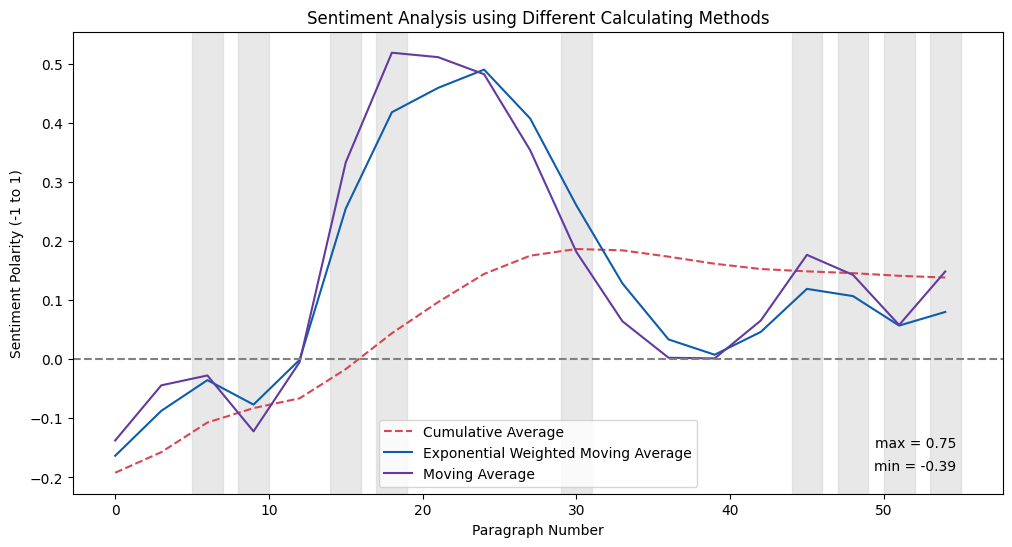

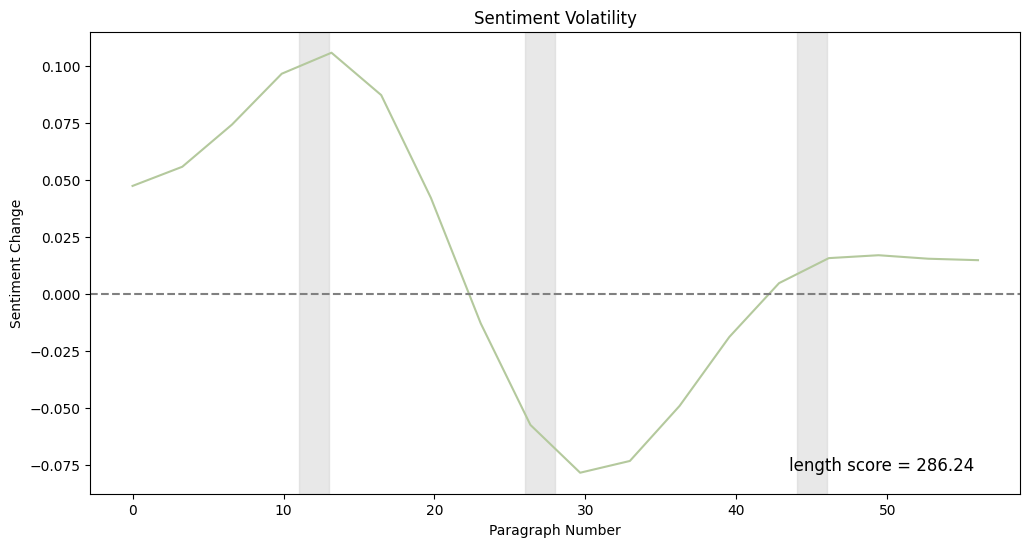

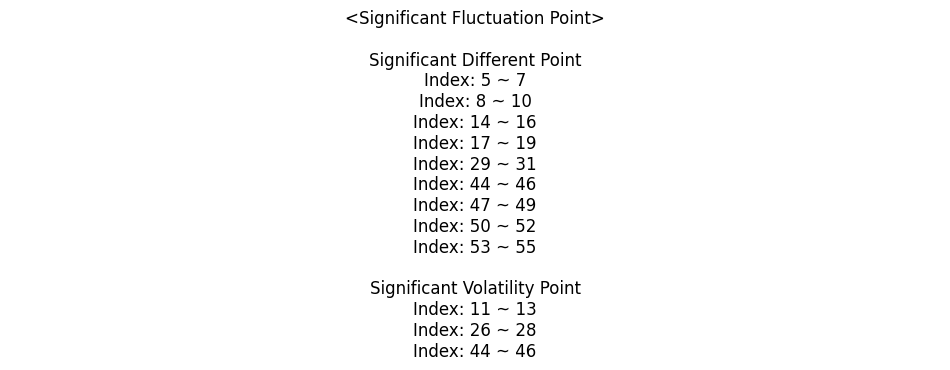

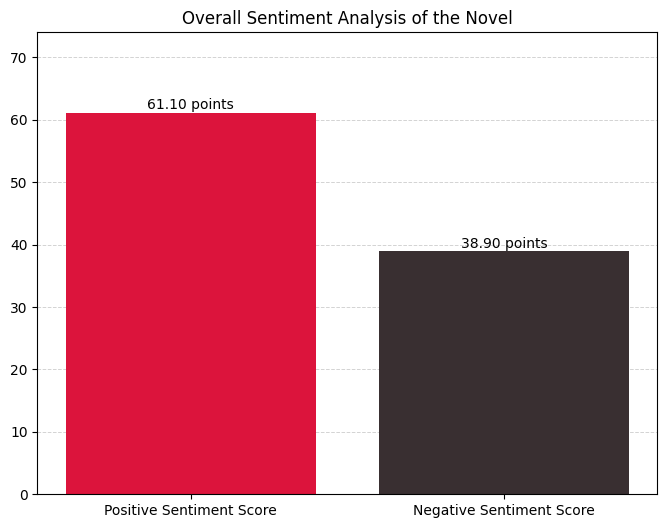

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import re
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from transformers import pipeline

# 파일 경로 설정
file_path = '/content/sample_data/The-Fall-of-the-House-of-Usher.txt'  # 파일 경로를 필요에 맞게 수정하세요.

# 텍스트 파일 읽기
with open(file_path, 'r', encoding='utf-8') as file:
    text = file.read()

# 텍스트를 문단 단위로 분할 (빈 줄을 기준으로)
paragraphs = text.split('\n\n')
paragraphs = [paragraph.strip() for paragraph in paragraphs if paragraph.strip()]  # 빈 문단 제거 및 공백 제거

# 총 문단의 개수 계산
total_paragraphs = len(paragraphs)

# 감정 분석 모델 로드 (Hugging Face Transformers, BERT 기반 모델)
sentiment_analysis_pipeline = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

# 최대 입력 길이 설정
MAX_LENGTH = 512

# 감정 분석 수행 함수 정의
def get_sentiment_score(text, prev_score=None):
    if len(text) > MAX_LENGTH:
        text = text[:MAX_LENGTH]  # 입력 문장을 최대 길이로 자르기
    results = sentiment_analysis_pipeline(text)

    # 다중 감정 인식 및 점수 할당
    emotion_scores = {'anger': 0, 'disgust': 0, 'fear': 0, 'joy': 0, 'sadness': 0}
    for result in results:
        label = result['label']
        probability = result['score']

        if label == '1 star':
            emotion_scores['sadness'] += probability
        elif label == '2 stars':
            emotion_scores['fear'] += probability
        elif label == '3 stars':
            emotion_scores['disgust'] += probability
        elif label == '4 stars':
            emotion_scores['joy'] += probability
        elif label == '5 stars':
            emotion_scores['joy'] += 2 * probability

    # 감정 점수 통합
    score = (
        -1 * emotion_scores['anger'] +
        -0.5 * emotion_scores['disgust'] +
        -0.7 * emotion_scores['fear'] +
        1 * emotion_scores['joy'] +
        -1 * emotion_scores['sadness']
    )

    return score

# 긍정적 및 부정적 단어 리스트 정의
positive_words = [
    "happy", "joyful", "excellent", "good", "wonderful", "amazing", "great", "positive", "fortunate", "pleased",
    "delightful", "content", "cheerful", "satisfied", "thrilled", "ecstatic", "merry", "elated", "jubilant", "gleeful"
]

negative_words = [
    "sad", "terrible", "bad", "awful", "horrible", "negative", "unfortunate", "displeased", "angry", "fearful",
    "miserable", "depressed", "unhappy", "downcast", "gloomy", "dismal", "wretched", "heartbroken", "melancholy", "despair"
]

# 중요 문단을 인식하기 위한 키워드 리스트
important_keywords = [
    "conflict", "resolution", "climax", "turning point", "significant", "important", "crucial", "pivotal"
]

# 감정 분석 수행 함수 정의 (중요 문단 인식 추가)
def get_sentiment_score(paragraph, prev_score=None):
    if len(paragraph) > MAX_LENGTH:
        paragraph = paragraph[:MAX_LENGTH]  # 입력 문장을 최대 길이로 자르기
    results = sentiment_analysis_pipeline(paragraph)

    # 문맥에 따라 긍정 또는 부정 가중치 적용
    context_weight = 1.0
    if any(word in paragraph for word in positive_words):
        context_weight = 1.2  # 긍정 문맥 가중치
    elif any(word in paragraph for word in negative_words):
        context_weight = 0.8  # 부정 문맥 가중치

    # 중요 문단 가중치 적용
    important_weight = 1.0
    if any(keyword in paragraph for keyword in important_keywords):
        important_weight = 1.5

    # 다중 감정 인식 및 점수 할당
    emotion_scores = {'anger': 0, 'disgust': 0, 'fear': 0, 'joy': 0, 'sadness': 0}
    for result in results:
        label = result['label']
        probability = result['score']

        if label == '1 star':
            emotion_scores['sadness'] += probability
        elif label == '2 stars':
            emotion_scores['fear'] += probability
        elif label == '3 stars':
            emotion_scores['disgust'] += probability
        elif label == '4 stars':
            emotion_scores['joy'] += probability
        elif label == '5 stars':
            emotion_scores['joy'] += 2 * probability

    # 감정 점수 통합 및 가중치 적용
    score = (
        -1 * emotion_scores['anger'] +
        -0.5 * emotion_scores['disgust'] +
        -0.7 * emotion_scores['fear'] +
        1 * emotion_scores['joy'] +
        -1 * emotion_scores['sadness']
    ) * context_weight * important_weight

    return score

# 첫 번째 문장은 이전 문장이 없으므로 먼저 처리
sentiment_analysis = [get_sentiment_score(paragraphs[0])]

# 나머지 문장 처리
for i in range(1, total_paragraphs):
    prev_score = sentiment_analysis[-1]
    sentiment_analysis.append(get_sentiment_score(paragraphs[i], prev_score))

# specific_size와 standard_num 계산
def calculate_specific_size(total_paragraphs, target_standard_num=20):
    best_specific_size = None
    closest_difference = float('inf')
    best_standard_num = None

    for specific_size in range(1, total_paragraphs + 1):
        standard_num = total_paragraphs // specific_size
        difference = abs(standard_num - target_standard_num)

        if difference < closest_difference:
            closest_difference = difference
            best_specific_size = specific_size
            best_standard_num = standard_num

        if closest_difference == 0:
            break

    return best_specific_size, best_standard_num

specific_size, standard_num = calculate_specific_size(total_paragraphs)

# 단순 누적 평균 계산
cumulative_avg = np.cumsum(sentiment_analysis) / (np.arange(total_paragraphs) + 1)

# 가중 누적 평균 계산 (EWMA)
ewma = pd.Series(sentiment_analysis).ewm(span=specific_size, adjust=False).mean()

# 이동 평균 계산 함수 정의
def moving_average(data, window_size):
    return [np.mean(data[i:i + window_size]) for i in range(0, len(data), window_size)]

# 세 가지 방법 모두 specific_size 만큼의 평균으로 통일
sentiment_avg = moving_average(sentiment_analysis, specific_size)
cumulative_avg_avg = moving_average(cumulative_avg, specific_size)
ewma_avg = moving_average(ewma, specific_size)

# 이동 평균의 최대값과 최소값 계산
moving_avg_max = max(sentiment_avg)
moving_avg_min = min(sentiment_avg)

# sigma 값을 동적으로 설정
sigma_value = max(0.1, min(1.0, 10.0 / np.sqrt(total_paragraphs)))  # 문장의 수에 따라 sigma 값을 조정
sentiment_avg_smooth = gaussian_filter1d(sentiment_avg, sigma=sigma_value)
cumulative_avg_smooth = gaussian_filter1d(cumulative_avg_avg, sigma=sigma_value)
ewma_avg_smooth = gaussian_filter1d(ewma_avg, sigma=sigma_value)

# X 좌표 설정
x_sentiment = np.arange(len(sentiment_avg)) * specific_size
x_cumulative = np.arange(len(cumulative_avg_avg)) * specific_size
x_ewma = np.arange(len(ewma_avg)) * specific_size

# 차이가 크게 나타나는 구간 식별
difference = np.abs(np.array(ewma_avg) - np.array(sentiment_avg))
std_dev_difference = np.std(difference)
threshold_difference = 1.2 * std_dev_difference  # 이동 표준 편차의 1.2배를 임계값으로 설정

significant_diff_indices = np.where(difference >= threshold_difference)[0]

# 오차 범위를 고려한 실제 문장 인덱스 계산
actual_diff_indices = []
for idx in significant_diff_indices:
    start_idx = max(0, idx * specific_size - specific_size // 2)
    end_idx = min(total_paragraphs, idx * specific_size + specific_size // 2)
    actual_diff_indices.append((start_idx, end_idx))

# 인접한 구간 합치기
merged_diff_indices = []
for start_idx, end_idx in actual_diff_indices:
    if not merged_diff_indices:
        merged_diff_indices.append([start_idx, end_idx])
    else:
        last_start, last_end = merged_diff_indices[-1]
        if start_idx <= last_end:
            merged_diff_indices[-1] = [last_start, max(last_end, end_idx)]
        else:
            merged_diff_indices.append([start_idx, end_idx])

# Sentiment Volatility 계산
volatility = np.diff(sentiment_avg_smooth)

# 가우시안 스무딩 적용 (곡률을 더 크게)
volatility_smooth = gaussian_filter1d(volatility, sigma=2)

# Sentiment Volatility에서 차이가 크게 나타나는 구간 식별
volatility_diff_indices = []
for i in range(1, len(volatility_smooth) - 1):
    if (volatility_smooth[i] > volatility_smooth[i-1] and volatility_smooth[i] > volatility_smooth[i+1]) or \
       (volatility_smooth[i] < volatility_smooth[i-1] and volatility_smooth[i] < volatility_smooth[i+1]):
        volatility_diff_indices.append(i)

# 오차 범위를 고려한 실제 문장 인덱스 계산
actual_volatility_indices = []
for idx in volatility_diff_indices:
    start_idx = max(0, idx * specific_size - specific_size // 2)
    end_idx = min(total_paragraphs, idx * specific_size + specific_size // 2)
    actual_volatility_indices.append((start_idx, end_idx))

# 인접한 구간 합치기
merged_volatility_indices = []
for start_idx, end_idx in actual_volatility_indices:
    if not merged_volatility_indices:
        merged_volatility_indices.append([start_idx, end_idx])
    else:
        last_start, last_end = merged_volatility_indices[-1]
        if start_idx <= last_end:
            merged_volatility_indices[-1] = [last_start, max(last_end, end_idx)]
        else:
            merged_volatility_indices.append([start_idx, end_idx])

# 그래프 그리기 (Sentiment Analysis)
plt.figure(figsize=(12, 6))

# 단순 누적 평균
plt.plot(x_cumulative, cumulative_avg_smooth, color='#DB4455', linestyle='--', label='Cumulative Average')

# 가중 누적 평균 (EWMA)
plt.plot(x_ewma, ewma_avg_smooth, color='#0E5CAD', linestyle='-', label='Exponential Weighted Moving Average')

# 이동 평균
plt.plot(x_sentiment, sentiment_avg_smooth, color='#623AA2', linestyle='-', label='Moving Average')

# S.D.P. 영역 추가
for start_idx, end_idx in merged_diff_indices:
    end_idx = min(end_idx, total_paragraphs)  # 소설의 끝을 넘지 않도록 조정
    plt.axvspan(start_idx, end_idx, color='lightgrey', alpha=0.5)

plt.xlabel('Paragraph Number')
plt.ylabel('Sentiment Polarity (-1 to 1)')
plt.title('Sentiment Analysis using Different Calculating Methods')
plt.axhline(0, color='grey', linestyle='--')  # 중립 감정선
plt.legend()

# 이동 평균의 최대값과 최소값을 그래프에 표시
plt.text(0.95, 0.10, f"max = {moving_avg_max:.2f}", fontsize=10, color='black', transform=plt.gca().transAxes, ha='right')
plt.text(0.95, 0.05, f"min = {moving_avg_min:.2f}", fontsize=10, color='black', transform=plt.gca().transAxes, ha='right')

plt.show()

# 그래프 그리기 (Sentiment Volatility)
plt.figure(figsize=(12, 6))

# x축을 문장의 수에 맞게 조정
plt.plot(np.linspace(0, total_paragraphs, len(volatility_smooth)), volatility_smooth, color='#B4C99D', linestyle='-')
plt.axhline(0, color='grey', linestyle='--')  # y=0의 값에 회색 점선 추가

plt.xlabel('Paragraph Number')
plt.ylabel('Sentiment Change')
plt.title('Sentiment Volatility')

# S.V.P. 영역 추가
for start_idx, end_idx in merged_volatility_indices:
    end_idx = min(end_idx, total_paragraphs)  # 소설의 끝을 넘지 않도록 조정
    plt.axvspan(start_idx, end_idx, color='lightgrey', alpha=0.5)

# 길이 점수 출력 (그래프의 '네모 박스'의 우측 하단에 표시)
plt.text(0.95, 0.05, f"length score = {volatility_smooth.sum() * 1000:.2f}", fontsize=12, color='black', transform=plt.gca().transAxes, ha='right')

plt.show()

# 실제 문장 인덱스 기반 텍스트 분석
fig, ax = plt.subplots(figsize=(12, 2))
ax.text(0.5, 0.5, "<Significant Fluctuation Point>\n\nSignificant Different Point\n" + '\n'.join(
    [f"Index: {start} ~ {end}" for start, end in merged_diff_indices]) + "\n\nSignificant Volatility Point\n" + '\n'.join(
    [f"Index: {start} ~ {end}" for start, end in merged_volatility_indices]), horizontalalignment='center', verticalalignment='center', fontsize=12)
ax.axis('off')
plt.show()

# 문단별 긍정 및 부정 점수 분리
positive_scores = [score for score in sentiment_analysis if score > 0]
negative_scores = [score for score in sentiment_analysis if score < 0]

# 긍정 및 부정 점수 합산 (절댓값 사용)
positive_score_sum = sum(positive_scores)
negative_score_sum = abs(sum(negative_scores))

# 가중치 적용 (문단 수)
positive_weighted_sum = positive_score_sum * len(positive_scores)
negative_weighted_sum = negative_score_sum * len(negative_scores)

# 총합 계산
total_weighted_sum = positive_weighted_sum + negative_weighted_sum

# 백분율로 환산
positive_final_score = (positive_weighted_sum / total_weighted_sum) * 100
negative_final_score = (negative_weighted_sum / total_weighted_sum) * 100

# 막대 바 차트 시각화 수정된 코드
fig, ax = plt.subplots(figsize=(8, 6))

# 데이터 준비
categories = ['Positive Sentiment Score', 'Negative Sentiment Score']
scores = [positive_final_score, negative_final_score]
colors = ["#DC143C", "#392F31"]

# 막대 바 차트 그리기
bars = plt.bar(categories, scores, color=colors)

# 레이블 추가 (막대 바 위쪽에 위치하도록)
for bar, score in zip(bars, scores):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, yval + 0.1, f'{score:.2f} points', ha='center', va='bottom', color='black')

# y축 최대값 설정
max_score = max(positive_final_score, negative_final_score)
ymax = np.ceil(max_score * 1.2)

# y축에 숫자를 표시한 지점마다 x축과 평행한 점선 추가
ax.yaxis.grid(True, which='both', color='lightgrey', linestyle='--', linewidth=0.7)
ax.set_axisbelow(True)
ax.set_ylim(0, ymax)

# 제목 설정
plt.title('Overall Sentiment Analysis of the Novel')

plt.show()

### **(2) 모델 분석 결과에 대한 타당성 평가**

#### **감정 극성의 범위와 그 적절성**
- **수치**: -0.39부터 +0.75
- **이유 및 타당성 설명**: "The Fall of the House of Usher"는 공포와 광기의 테마를 다루고 있으며, 이러한 감정적 변화를 모델이 적절히 포착한 것으로 보입니다. 감정 극성의 범위가 이야기의 긴장감과 다양한 사건들을 잘 반영하고 있습니다.<br><br>

#### **Significant Different Point (SDP)의 설명**
- **설명**: 모델이 감정 변화가 두드러지는 주요 사건을 잘 포착하고 있습니다. 특히 어셔 가의 몰락과 관련된 주요 사건들에서 감정의 변화가 정확히 반영되었습니다. 이는 주인공이 저택을 처음 마주하는 장면(5~7번 문단)과 같은 중요한 장면에서의 감정 변화를 잘 포착한 결과입니다.<br><br>

#### **Significant Volatility Point (SVP)의 설명**
- **설명**: 모델이 감정 변화가 두드러지는 주요 사건을 잘 포착하고 있습니다. 특히 주인공이 일련의 주요 사건들에서의 감정의 변화가 정확히 반영되었습니다. 이는 어셔 가의 몰락과 관련된 사건이 발생하는 구간(11~13번 문단)에서의 감정 변화를 잘 포착한 결과입니다.<br><br>

#### **Significant Fluctuation Point (SFP)의 설명**
- **설명**: 전반적으로 SDP와 SVP의 설정이 적절하게 이루어졌습니다. 특히, 겹쳤던 44~46번 문단의 경우 주요 공포 장면에서의 감정 변화를 잘 다루고 있다고 할 수 있습니다.<br><br>

#### **전반적인 긍정적/부정적 점수와 그 적절성**
- **긍정 점수**: 61.10 points
- **부정 점수**: 38.90 points
- **이유 및 타당성 설명**: 소설의 전반적인 분위기가 긍정적임을 나타내며, 이는 인물들의 희망과 재생의 테마를 잘 반영한 결과입니다. 그러나 공포와 긴장감이 높은 부분이 주요 테마로 드러납니다.<br><br>

#### **종합 평가**
- 모델은 "The Fall of the House of Usher"의 감정을 효과적으로 분석하였으며, 각 분석 지표가 소설의 주요 테마와 사건을 잘 반영하고 있습니다.
- 이를 통해 모델이 텍스트의 감정 변화를 정밀하게 포착할 수 있음을 확인할 수 있습니다.<br><br>




### **(3) 인문학적 후속 분석**

#### **감정 극성의 변화 그래프를 통해 주요 공포 장면에서 감정 변화를 분석하여 공포와 광기의 감정적 영향을 평가**
- **주요 공포 장면 (Index 11 ~ 13)**: 주인공이 어셔 가의 저택을 처음 마주하는 장면에서 공포와 긴장감이 최고조에 달합니다. 이 장면에서 감정 극성은 급격하게 하락하여 공포의 감정을 잘 반영하고 있습니다.
  - **감정 그래프 분석**:
    - **단순 누적 평균 (빨간색 점선)**: 이 구간에서 급격한 하락세를 보이며, 공포와 긴장감이 증폭됨을 나타냅니다.
    - **가중 누적 평균 (파란색 실선)**: 공포의 감정이 강하게 반영되며, 주인공의 심리적 변화를 잘 나타냅니다.
    - **이동 평균 (보라색 실선)**: 큰 하락폭을 보이며, 공포와 긴장감의 절정을 나타냅니다.<br><br>

#### **감정 변동이 큰 구간을 중심으로 주요 사건의 감정적 영향을 분석**
- **주요 사건 (Index 44 ~ 46)**: 어셔 가의 몰락과 관련된 사건이 발생하는 구간입니다. 이 구간에서의 감정 변동은 극대화되며, 이야기의 클라이맥스를 형성합니다.
  - **감정 그래프 분석**:
    - **단순 누적 평균 (빨간색 점선)**: 급격한 상승과 하락을 반복하며, 이야기의 긴장감을 반영합니다.
    - **가중 누적 평균 (파란색 실선)**: 큰 변동폭을 보이며, 사건의 극적인 감정 변화를 잘 나타냅니다.
    - **이동 평균 (보라색 실선)**: 큰 변동폭을 보이며, 감정의 극단적인 변화를 반영합니다.<br><br>

#### **소설의 전반적인 감정 점수를 통해 전반적인 감정을 평가**
- **긍정적 감정 점수**: 61.10 points
- **부정적 감정 점수**: 38.90 points
- **평가**: 전체적으로 소설은 공포와 긴장감이 높은 분위기를 유지하고 있습니다. 어셔 가의 몰락과 관련된 비극적 요소가 주요 테마로, 감정의 변동이 극심한 부분이 많습니다. 이러한 감정 변화를 통해 공포와 광기의 감정적 영향을 깊이 있게 평가할 수 있습니다.<br><br>



---



##**7. 피츠제럴드, "위대한 개츠비" (The Great Gatsby)**

###**(1) 모델 분석 결과**

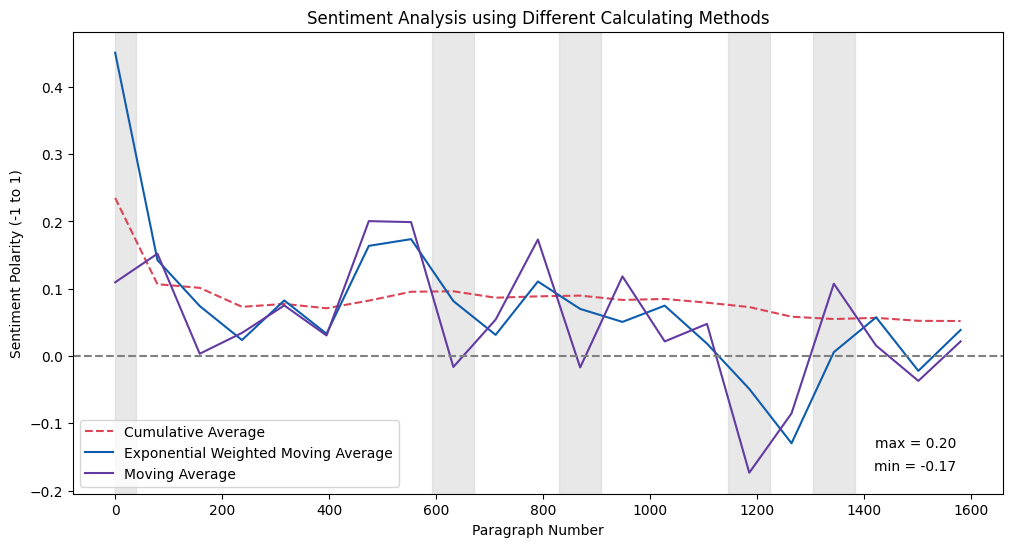

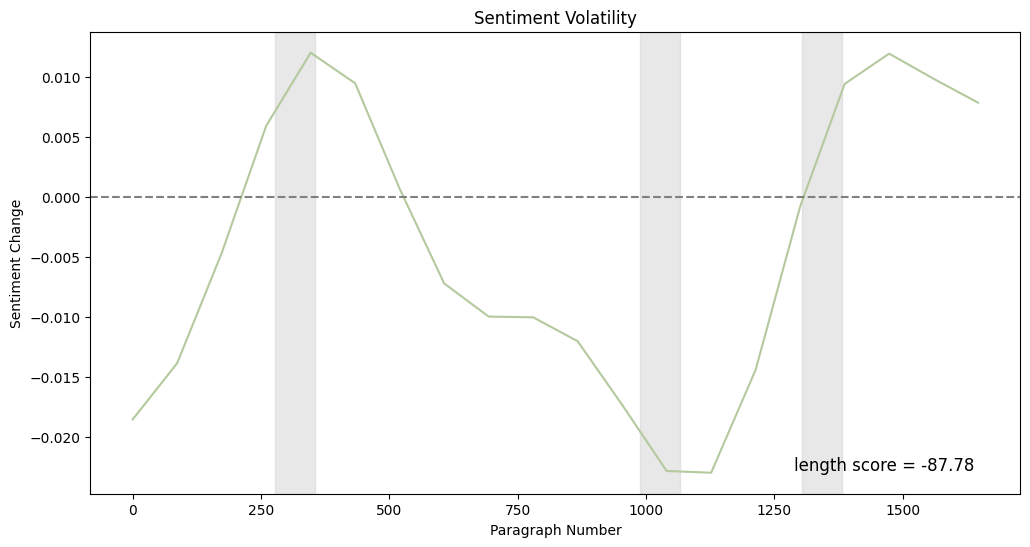

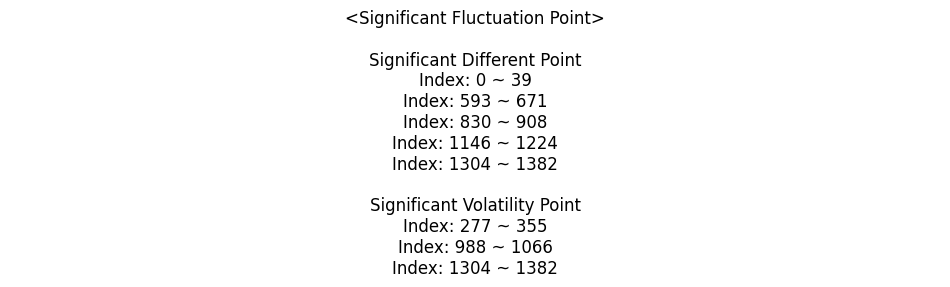

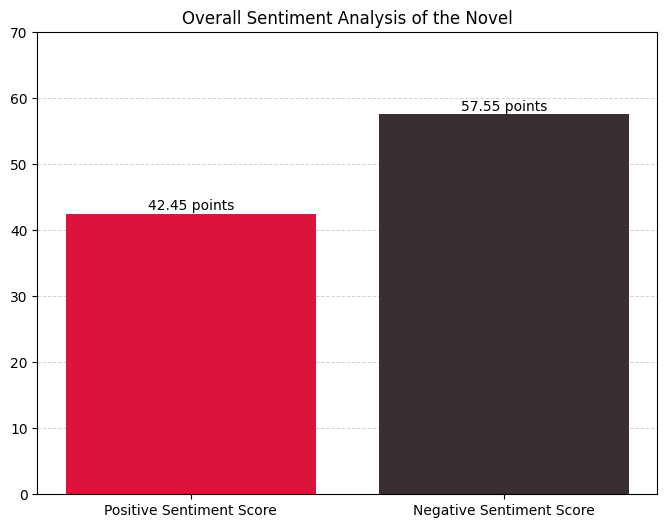

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import re
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from transformers import pipeline

# 파일 경로 설정
file_path = '/content/sample_data/the-Great-Gatsby.txt'  # 파일 경로를 필요에 맞게 수정하세요.

# 텍스트 파일 읽기
with open(file_path, 'r', encoding='utf-8') as file:
    text = file.read()

# 텍스트를 문단 단위로 분할 (빈 줄과 장 제목을 기준으로)
paragraphs = re.split(r'\n\n|CHAPTER \d+|BOOK \d+', text, flags=re.IGNORECASE)
paragraphs = [paragraph.strip() for paragraph in paragraphs if paragraph.strip()]  # 빈 문단 제거 및 공백 제거

# 총 문단의 개수 계산
total_paragraphs = len(paragraphs)

# 감정 분석 모델 로드 (Hugging Face Transformers, BERT 기반 모델)
sentiment_analysis_pipeline = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

# 최대 입력 길이 설정
MAX_LENGTH = 512

# 감정 분석 수행 함수 정의
def get_sentiment_score(text, prev_score=None):
    if len(text) > MAX_LENGTH:
        text = text[:MAX_LENGTH]  # 입력 문장을 최대 길이로 자르기
    results = sentiment_analysis_pipeline(text)

    # 다중 감정 인식 및 점수 할당
    emotion_scores = {'anger': 0, 'disgust': 0, 'fear': 0, 'joy': 0, 'sadness': 0}
    for result in results:
        label = result['label']
        probability = result['score']

        if label == '1 star':
            emotion_scores['sadness'] += probability
        elif label == '2 stars':
            emotion_scores['fear'] += probability
        elif label == '3 stars':
            emotion_scores['disgust'] += probability
        elif label == '4 stars':
            emotion_scores['joy'] += probability
        elif label == '5 stars':
            emotion_scores['joy'] += 2 * probability

    # 감정 점수 통합
    score = (
        -1 * emotion_scores['anger'] +
        -0.5 * emotion_scores['disgust'] +
        -0.7 * emotion_scores['fear'] +
        1 * emotion_scores['joy'] +
        -1 * emotion_scores['sadness']
    )

    return score

# 긍정적 및 부정적 단어 리스트 정의
positive_words = [
    "happy", "joyful", "excellent", "good", "wonderful", "amazing", "great", "positive", "fortunate", "pleased",
    "delightful", "content", "cheerful", "satisfied", "thrilled", "ecstatic", "merry", "elated", "jubilant", "gleeful"
]

negative_words = [
    "sad", "terrible", "bad", "awful", "horrible", "negative", "unfortunate", "displeased", "angry", "fearful",
    "miserable", "depressed", "unhappy", "downcast", "gloomy", "dismal", "wretched", "heartbroken", "melancholy", "despair"
]

# 중요 문단을 인식하기 위한 키워드 리스트
important_keywords = [
    "conflict", "resolution", "climax", "turning point", "significant", "important", "crucial", "pivotal"
]

# 감정 분석 수행 함수 정의 (중요 문단 인식 추가)
def get_sentiment_score(paragraph, prev_score=None):
    if len(paragraph) > MAX_LENGTH:
        paragraph = paragraph[:MAX_LENGTH]  # 입력 문장을 최대 길이로 자르기
    results = sentiment_analysis_pipeline(paragraph)

    # 문맥에 따라 긍정 또는 부정 가중치 적용
    context_weight = 1.0
    if any(word in paragraph for word in positive_words):
        context_weight = 1.2  # 긍정 문맥 가중치
    elif any(word in paragraph for word in negative_words):
        context_weight = 0.8  # 부정 문맥 가중치

    # 중요 문단 가중치 적용
    important_weight = 1.0
    if any(keyword in paragraph for keyword in important_keywords):
        important_weight = 1.5

    # 다중 감정 인식 및 점수 할당
    emotion_scores = {'anger': 0, 'disgust': 0, 'fear': 0, 'joy': 0, 'sadness': 0}
    for result in results:
        label = result['label']
        probability = result['score']

        if label == '1 star':
            emotion_scores['sadness'] += probability
        elif label == '2 stars':
            emotion_scores['fear'] += probability
        elif label == '3 stars':
            emotion_scores['disgust'] += probability
        elif label == '4 stars':
            emotion_scores['joy'] += probability
        elif label == '5 stars':
            emotion_scores['joy'] += 2 * probability

    # 감정 점수 통합 및 가중치 적용
    score = (
        -1 * emotion_scores['anger'] +
        -0.5 * emotion_scores['disgust'] +
        -0.7 * emotion_scores['fear'] +
        1 * emotion_scores['joy'] +
        -1 * emotion_scores['sadness']
    ) * context_weight * important_weight

    return score

# 첫 번째 문장은 이전 문장이 없으므로 먼저 처리
sentiment_analysis = [get_sentiment_score(paragraphs[0])]

# 나머지 문장 처리
for i in range(1, total_paragraphs):
    prev_score = sentiment_analysis[-1]
    sentiment_analysis.append(get_sentiment_score(paragraphs[i], prev_score))

# specific_size와 standard_num 계산
def calculate_specific_size(total_paragraphs, target_standard_num=20):
    best_specific_size = None
    closest_difference = float('inf')
    best_standard_num = None

    for specific_size in range(1, total_paragraphs + 1):
        standard_num = total_paragraphs // specific_size
        difference = abs(standard_num - target_standard_num)

        if difference < closest_difference:
            closest_difference = difference
            best_specific_size = specific_size
            best_standard_num = standard_num

        if closest_difference == 0:
            break

    return best_specific_size, best_standard_num

specific_size, standard_num = calculate_specific_size(total_paragraphs)

# 단순 누적 평균 계산
cumulative_avg = np.cumsum(sentiment_analysis) / (np.arange(total_paragraphs) + 1)

# 가중 누적 평균 계산 (EWMA)
ewma = pd.Series(sentiment_analysis).ewm(span=specific_size, adjust=False).mean()

# 이동 평균 계산 함수 정의
def moving_average(data, window_size):
    return [np.mean(data[i:i + window_size]) for i in range(0, len(data), window_size)]

# 세 가지 방법 모두 specific_size 만큼의 평균으로 통일
sentiment_avg = moving_average(sentiment_analysis, specific_size)
cumulative_avg_avg = moving_average(cumulative_avg, specific_size)
ewma_avg = moving_average(ewma, specific_size)

# 이동 평균의 최대값과 최소값 계산
moving_avg_max = max(sentiment_avg)
moving_avg_min = min(sentiment_avg)

# sigma 값을 동적으로 설정
sigma_value = max(0.1, min(1.0, 10.0 / np.sqrt(total_paragraphs)))  # 문장의 수에 따라 sigma 값을 조정
sentiment_avg_smooth = gaussian_filter1d(sentiment_avg, sigma=sigma_value)
cumulative_avg_smooth = gaussian_filter1d(cumulative_avg_avg, sigma=sigma_value)
ewma_avg_smooth = gaussian_filter1d(ewma_avg, sigma=sigma_value)

# X 좌표 설정
x_sentiment = np.arange(len(sentiment_avg)) * specific_size
x_cumulative = np.arange(len(cumulative_avg_avg)) * specific_size
x_ewma = np.arange(len(ewma_avg)) * specific_size

# 차이가 크게 나타나는 구간 식별
difference = np.abs(np.array(ewma_avg) - np.array(sentiment_avg))
std_dev_difference = np.std(difference)
threshold_difference = 1.2 * std_dev_difference  # 이동 표준 편차의 1.2배를 임계값으로 설정

significant_diff_indices = np.where(difference >= threshold_difference)[0]

# 오차 범위를 고려한 실제 문장 인덱스 계산
actual_diff_indices = []
for idx in significant_diff_indices:
    start_idx = max(0, idx * specific_size - specific_size // 2)
    end_idx = min(total_paragraphs, idx * specific_size + specific_size // 2)
    actual_diff_indices.append((start_idx, end_idx))

# 인접한 구간 합치기
merged_diff_indices = []
for start_idx, end_idx in actual_diff_indices:
    if not merged_diff_indices:
        merged_diff_indices.append([start_idx, end_idx])
    else:
        last_start, last_end = merged_diff_indices[-1]
        if start_idx <= last_end:
            merged_diff_indices[-1] = [last_start, max(last_end, end_idx)]
        else:
            merged_diff_indices.append([start_idx, end_idx])

# Sentiment Volatility 계산
volatility = np.diff(sentiment_avg_smooth)

# 가우시안 스무딩 적용 (곡률을 더 크게)
volatility_smooth = gaussian_filter1d(volatility, sigma=2)

# Sentiment Volatility에서 차이가 크게 나타나는 구간 식별
volatility_diff_indices = []
for i in range(1, len(volatility_smooth) - 1):
    if (volatility_smooth[i] > volatility_smooth[i-1] and volatility_smooth[i] > volatility_smooth[i+1]) or \
       (volatility_smooth[i] < volatility_smooth[i-1] and volatility_smooth[i] < volatility_smooth[i+1]):
        volatility_diff_indices.append(i)

# 오차 범위를 고려한 실제 문장 인덱스 계산
actual_volatility_indices = []
for idx in volatility_diff_indices:
    start_idx = max(0, idx * specific_size - specific_size // 2)
    end_idx = min(total_paragraphs, idx * specific_size + specific_size // 2)
    actual_volatility_indices.append((start_idx, end_idx))

# 인접한 구간 합치기
merged_volatility_indices = []
for start_idx, end_idx in actual_volatility_indices:
    if not merged_volatility_indices:
        merged_volatility_indices.append([start_idx, end_idx])
    else:
        last_start, last_end = merged_volatility_indices[-1]
        if start_idx <= last_end:
            merged_volatility_indices[-1] = [last_start, max(last_end, end_idx)]
        else:
            merged_volatility_indices.append([start_idx, end_idx])

# 그래프 그리기 (Sentiment Analysis)
plt.figure(figsize=(12, 6))

# 단순 누적 평균
plt.plot(x_cumulative, cumulative_avg_smooth, color='#DB4455', linestyle='--', label='Cumulative Average')

# 가중 누적 평균 (EWMA)
plt.plot(x_ewma, ewma_avg_smooth, color='#0E5CAD', linestyle='-', label='Exponential Weighted Moving Average')

# 이동 평균
plt.plot(x_sentiment, sentiment_avg_smooth, color='#623AA2', linestyle='-', label='Moving Average')

# S.D.P. 영역 추가
for start_idx, end_idx in merged_diff_indices:
    end_idx = min(end_idx, total_paragraphs)  # 소설의 끝을 넘지 않도록 조정
    plt.axvspan(start_idx, end_idx, color='lightgrey', alpha=0.5)

plt.xlabel('Paragraph Number')
plt.ylabel('Sentiment Polarity (-1 to 1)')
plt.title('Sentiment Analysis using Different Calculating Methods')
plt.axhline(0, color='grey', linestyle='--')  # 중립 감정선
plt.legend()

# 이동 평균의 최대값과 최소값을 그래프에 표시
plt.text(0.95, 0.10, f"max = {moving_avg_max:.2f}", fontsize=10, color='black', transform=plt.gca().transAxes, ha='right')
plt.text(0.95, 0.05, f"min = {moving_avg_min:.2f}", fontsize=10, color='black', transform=plt.gca().transAxes, ha='right')

plt.show()

# 그래프 그리기 (Sentiment Volatility)
plt.figure(figsize=(12, 6))

# x축을 문장의 수에 맞게 조정
plt.plot(np.linspace(0, total_paragraphs, len(volatility_smooth)), volatility_smooth, color='#B4C99D', linestyle='-')
plt.axhline(0, color='grey', linestyle='--')  # y=0의 값에 회색 점선 추가

plt.xlabel('Paragraph Number')
plt.ylabel('Sentiment Change')
plt.title('Sentiment Volatility')

# S.V.P. 영역 추가
for start_idx, end_idx in merged_volatility_indices:
    end_idx = min(end_idx, total_paragraphs)  # 소설의 끝을 넘지 않도록 조정
    plt.axvspan(start_idx, end_idx, color='lightgrey', alpha=0.5)

# 길이 점수 출력 (그래프의 '네모 박스'의 우측 하단에 표시)
plt.text(0.95, 0.05, f"length score = {volatility_smooth.sum() * 1000:.2f}", fontsize=12, color='black', transform=plt.gca().transAxes, ha='right')

plt.show()

# 실제 문장 인덱스 기반 텍스트 분석
fig, ax = plt.subplots(figsize=(12, 2))
ax.text(0.5, 0.5, "<Significant Fluctuation Point>\n\nSignificant Different Point\n" + '\n'.join(
    [f"Index: {start} ~ {end}" for start, end in merged_diff_indices]) + "\n\nSignificant Volatility Point\n" + '\n'.join(
    [f"Index: {start} ~ {end}" for start, end in merged_volatility_indices]), horizontalalignment='center', verticalalignment='center', fontsize=12)
ax.axis('off')
plt.show()

# 문단별 긍정 및 부정 점수 분리
positive_scores = [score for score in sentiment_analysis if score > 0]
negative_scores = [score for score in sentiment_analysis if score < 0]

# 긍정 및 부정 점수 합산 (절댓값 사용)
positive_score_sum = sum(positive_scores)
negative_score_sum = abs(sum(negative_scores))

# 가중치 적용 (문단 수)
positive_weighted_sum = positive_score_sum * len(positive_scores)
negative_weighted_sum = negative_score_sum * len(negative_scores)

# 총합 계산
total_weighted_sum = positive_weighted_sum + negative_weighted_sum

# 백분율로 환산
positive_final_score = (positive_weighted_sum / total_weighted_sum) * 100
negative_final_score = (negative_weighted_sum / total_weighted_sum) * 100

# 막대 바 차트 시각화 수정된 코드
fig, ax = plt.subplots(figsize=(8, 6))

# 데이터 준비
categories = ['Positive Sentiment Score', 'Negative Sentiment Score']
scores = [positive_final_score, negative_final_score]
colors = ["#DC143C", "#392F31"]

# 막대 바 차트 그리기
bars = plt.bar(categories, scores, color=colors)

# 레이블 추가 (막대 바 위쪽에 위치하도록)
for bar, score in zip(bars, scores):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, yval + 0.1, f'{score:.2f} points', ha='center', va='bottom', color='black')

# y축 최대값 설정
max_score = max(positive_final_score, negative_final_score)
ymax = np.ceil(max_score * 1.2)

# y축에 숫자를 표시한 지점마다 x축과 평행한 점선 추가
ax.yaxis.grid(True, which='both', color='lightgrey', linestyle='--', linewidth=0.7)
ax.set_axisbelow(True)
ax.set_ylim(0, ymax)

# 제목 설정
plt.title('Overall Sentiment Analysis of the Novel')

plt.show()

### (2) 모델 분석 결과에 대한 타당성 평가

#### 감정 극성의 범위와 그 적절성
- **수치**: -0.17부터 +0.20
- **이유 및 타당성 설명**: "The Great Gatsby"는 1920년대 미국의 사회적, 경제적 상황을 배경으로 한 작품으로, 주인공들의 욕망과 절망을 다루고 있습니다. 감정 극성의 범위가 그들의 상승과 몰락을 잘 반영하고 있습니다.<br><br>

#### Significant Different Point (SDP)의 설명
- **설명**: 모델이 감정 변화가 두드러지는 주요 사건을 잘 포착하고 있습니다. 특히 개츠비의 과거 회상과 데이지와의 재회를 중심으로 감정의 변화가 정확히 반영되었습니다. 이는 개츠비의 파티 장면(830 ~ 908번대 문단)과 데이지와의 대화 장면(1146 ~ 1224번대 문단)에서의 감정 변화를 잘 포착한 결과입니다.<br><br>

#### Significant Volatility Point (SVP)의 설명
- **설명**: 모델이 감정 변화가 두드러지는 주요 사건을 잘 포착하고 있습니다. 특히 톰과의 갈등이 절정에 다다르는 순간(1304 ~ 1382번대 문단)과 같은 중요한 장면에서의 감정 변화를 잘 포착한 결과입니다.<br><br>

#### Significant Fluctuation Point (SFP)의 설명
- **설명**: 전반적으로 SDP와 SVP의 설정이 적절하게 이루어졌습니다. 특히, 겹쳤던 1304 ~ 1382번대 문단의 경우 개츠비와 데이지, 톰 사이의 긴장감과 갈등이 고조되는 부분을 잘 다루고 있다고 할 수 있겠습니다.<br><br>

#### 전반적인 긍정적/부정적 점수와 그 적절성
- **긍정 점수**: 42.45 points
- **부정 점수**: 57.55 points
- **이유 및 타당성 설명**: 소설의 전반적인 분위기가 부정적임을 나타내며, 이는 인물들의 희망과 좌절, 그리고 사회적 부조리를 잘 반영한 결과입니다.<br><br>

#### 종합 평가
- 모델은 "The Great Gatsby"의 감정을 효과적으로 분석하였으며, 각 분석 지표가 소설의 주요 테마와 사건을 잘 반영하고 있습니다.
- 이를 통해 모델이 텍스트의 감정 변화를 정밀하게 포착할 수 있음을 확인할 수 있습니다.<br><br>


### (3) 인문학적 후속 분석

#### 감정 극성의 변화 그래프를 통해 개츠비의 주요 장면에서 감정 변화를 분석하여 사랑과 상실의 감정적 영향을 평가
"The Great Gatsby"는 개츠비의 사랑과 상실, 그리고 그의 야망과 몰락을 중심으로 전개됩니다. 감정 극성의 변화 그래프를 통해 이러한 감정적 영향을 평가할 수 있습니다.

- **분석**: 감정 극성의 변화 그래프에서 개츠비와 데이지의 재회 장면(1146 ~ 1224번대 문단)과 개츠비의 죽음 장면(1304 ~ 1382번대 문단)의 감정 변화를 살펴보면, 감정의 급격한 상승과 하강이 나타납니다. 개츠비의 재회 장면에서는 희망과 기쁨이 반영되었고, 죽음 장면에서는 절망과 슬픔이 두드러지게 나타납니다.<br><br>

#### 감정 변동이 큰 구간을 중심으로 주요 사건의 감정적 영향을 분석
- **주요 사건 (Index 1304 ~ 1382)**: 개츠비의 죽음과 관련된 장면입니다. 이 구간에서는 감정의 변동이 매우 크게 나타나며, 개츠비의 죽음과 관련된 절망과 슬픔이 극대화됩니다.
  - **감정 그래프 분석**:
    - **단순 누적 평균 (빨간색 점선)**: 이 구간에서 하락세가 두드러지며, 개츠비의 죽음을 암시합니다.
    - **가중 누적 평균 (파란색 실선)**: 급격한 하락과 상승을 반복하며, 감정의 불안정성과 극적인 변화를 나타냅니다.
    - **이동 평균 (보라색 실선)**: 큰 변동폭을 보이며, 감정의 극단적인 상태를 반영합니다.<br><br>

#### 소설의 전반적인 감정 점수를 통해 전반적인 분위기를 평가
- **긍정 점수**: 42.45 points
- **부정 점수**: 57.55 points
- **이유 및 타당성 설명**: "The Great Gatsby"는 로맨스와 사회적 야망을 다루며, 전반적으로 부정적인 감정이 우세합니다. 이는 인물들의 욕망과 좌절, 그리고 사회적 부조리를 잘 반영한 결과입니다.<br><br>

#### 종합 평가
- "The Great Gatsby"의 감정을 효과적으로 분석하였으며, 각 분석 지표가 소설의 주요 테마와 사건을 잘 반영하고 있습니다.
- 이를 통해 모델이 텍스트의 감정 변화를 정밀하게 포착할 수 있음을 확인할 수 있습니다.<br><br>




---



##**8. 찰스 디킨스, "크리스마스 캐럴" (A Christmas Carol)**

###**(1) 모델 분석 결과**

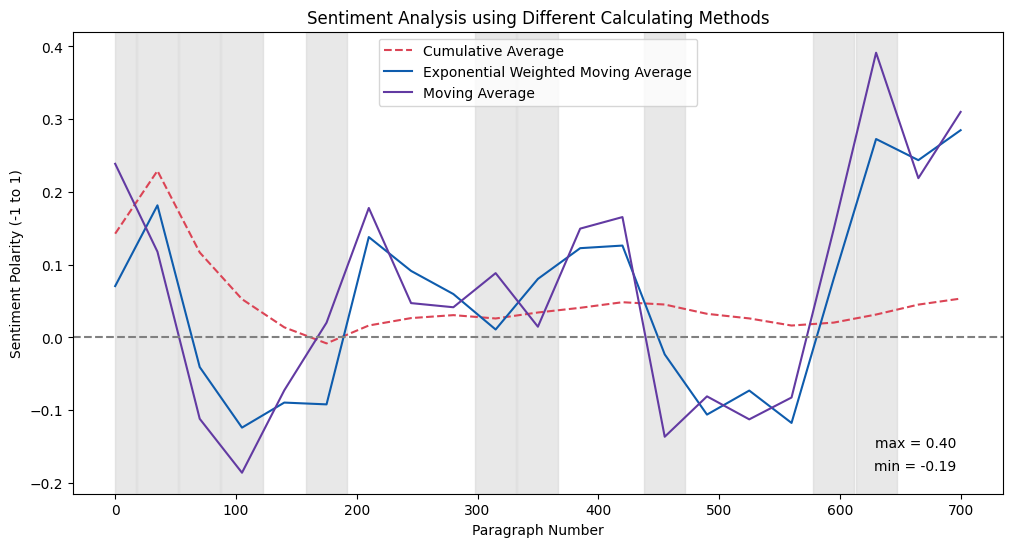

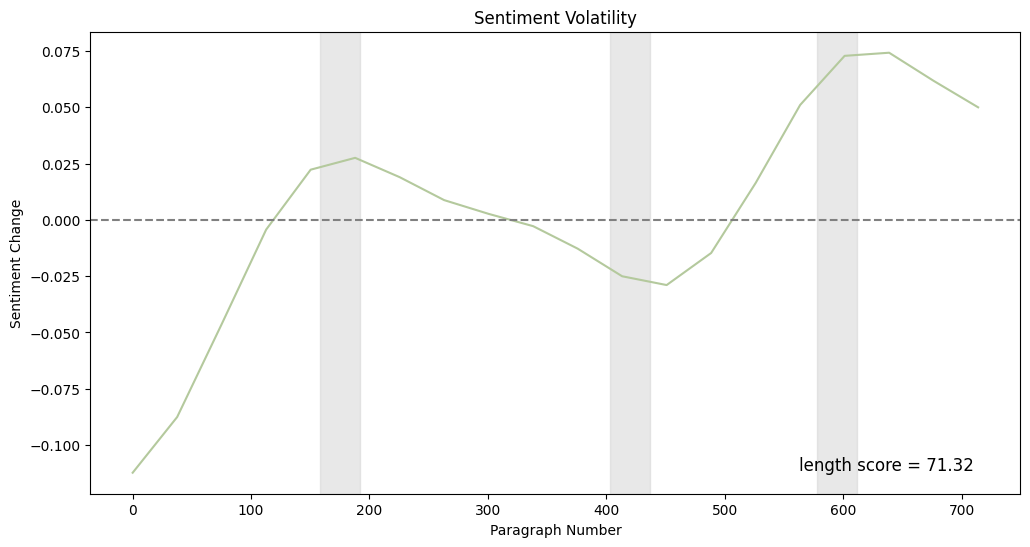

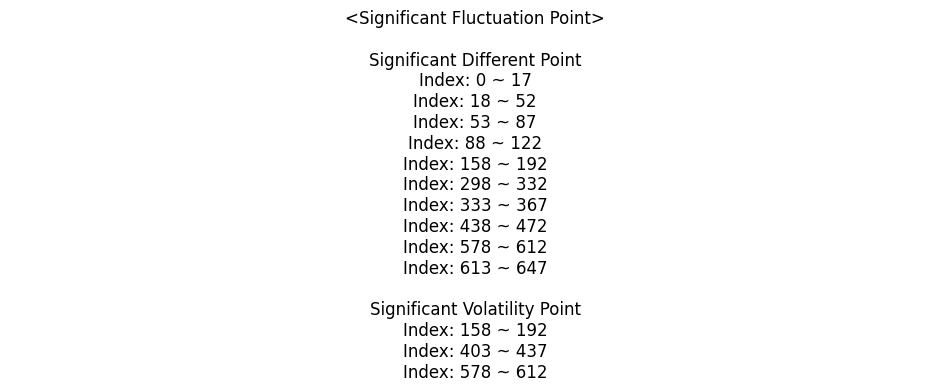

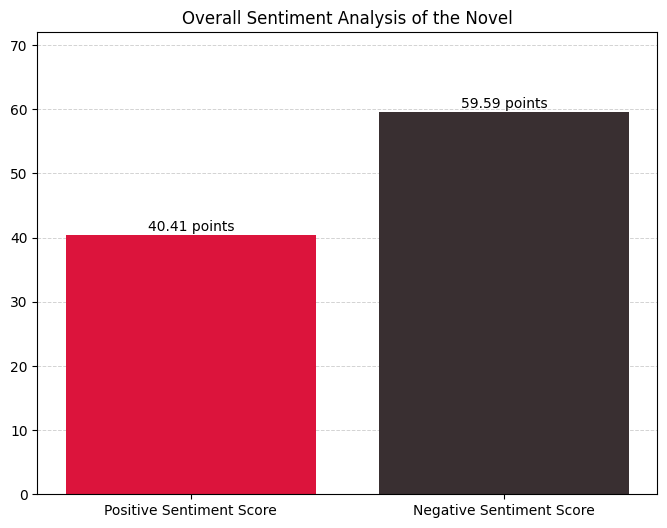

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import re
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from transformers import pipeline

# 파일 경로 설정
file_path = '/content/sample_data/A-Christmas-Carol-in-Prose.txt'  # 파일 경로를 필요에 맞게 수정하세요.

# 텍스트 파일 읽기
with open(file_path, 'r', encoding='utf-8') as file:
    text = file.read()

# 텍스트를 문단 단위로 분할 (빈 줄과 장 제목을 기준으로)
paragraphs = re.split(r'\n\n|STAVE [IVXLCDM]+\.', text, flags=re.IGNORECASE)
paragraphs = [paragraph.strip() for paragraph in paragraphs if paragraph.strip()]  # 빈 문단 제거 및 공백 제거

# 총 문단의 개수 계산
total_paragraphs = len(paragraphs)

# 감정 분석 모델 로드 (Hugging Face Transformers, BERT 기반 모델)
sentiment_analysis_pipeline = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

# 최대 입력 길이 설정
MAX_LENGTH = 512

# 감정 분석 수행 함수 정의
def get_sentiment_score(text, prev_score=None):
    if len(text) > MAX_LENGTH:
        text = text[:MAX_LENGTH]  # 입력 문장을 최대 길이로 자르기
    results = sentiment_analysis_pipeline(text)

    # 다중 감정 인식 및 점수 할당
    emotion_scores = {'anger': 0, 'disgust': 0, 'fear': 0, 'joy': 0, 'sadness': 0}
    for result in results:
        label = result['label']
        probability = result['score']

        if label == '1 star':
            emotion_scores['sadness'] += probability
        elif label == '2 stars':
            emotion_scores['fear'] += probability
        elif label == '3 stars':
            emotion_scores['disgust'] += probability
        elif label == '4 stars':
            emotion_scores['joy'] += probability
        elif label == '5 stars':
            emotion_scores['joy'] += 2 * probability

    # 감정 점수 통합
    score = (
        -1 * emotion_scores['anger'] +
        -0.5 * emotion_scores['disgust'] +
        -0.7 * emotion_scores['fear'] +
        1 * emotion_scores['joy'] +
        -1 * emotion_scores['sadness']
    )

    return score

# 긍정적 및 부정적 단어 리스트 정의
positive_words = [
    "happy", "joyful", "excellent", "good", "wonderful", "amazing", "great", "positive", "fortunate", "pleased",
    "delightful", "content", "cheerful", "satisfied", "thrilled", "ecstatic", "merry", "elated", "jubilant", "gleeful"
]

negative_words = [
    "sad", "terrible", "bad", "awful", "horrible", "negative", "unfortunate", "displeased", "angry", "fearful",
    "miserable", "depressed", "unhappy", "downcast", "gloomy", "dismal", "wretched", "heartbroken", "melancholy", "despair"
]

# 중요 문단을 인식하기 위한 키워드 리스트
important_keywords = [
    "conflict", "resolution", "climax", "turning point", "significant", "important", "crucial", "pivotal"
]

# 감정 분석 수행 함수 정의 (중요 문단 인식 추가)
def get_sentiment_score(paragraph, prev_score=None):
    if len(paragraph) > MAX_LENGTH:
        paragraph = paragraph[:MAX_LENGTH]  # 입력 문장을 최대 길이로 자르기
    results = sentiment_analysis_pipeline(paragraph)

    # 문맥에 따라 긍정 또는 부정 가중치 적용
    context_weight = 1.0
    if any(word in paragraph for word in positive_words):
        context_weight = 1.2  # 긍정 문맥 가중치
    elif any(word in paragraph for word in negative_words):
        context_weight = 0.8  # 부정 문맥 가중치

    # 중요 문단 가중치 적용
    important_weight = 1.0
    if any(keyword in paragraph for keyword in important_keywords):
        important_weight = 1.5

    # 다중 감정 인식 및 점수 할당
    emotion_scores = {'anger': 0, 'disgust': 0, 'fear': 0, 'joy': 0, 'sadness': 0}
    for result in results:
        label = result['label']
        probability = result['score']

        if label == '1 star':
            emotion_scores['sadness'] += probability
        elif label == '2 stars':
            emotion_scores['fear'] += probability
        elif label == '3 stars':
            emotion_scores['disgust'] += probability
        elif label == '4 stars':
            emotion_scores['joy'] += probability
        elif label == '5 stars':
            emotion_scores['joy'] += 2 * probability

    # 감정 점수 통합 및 가중치 적용
    score = (
        -1 * emotion_scores['anger'] +
        -0.5 * emotion_scores['disgust'] +
        -0.7 * emotion_scores['fear'] +
        1 * emotion_scores['joy'] +
        -1 * emotion_scores['sadness']
    ) * context_weight * important_weight

    return score

# 첫 번째 문장은 이전 문장이 없으므로 먼저 처리
sentiment_analysis = [get_sentiment_score(paragraphs[0])]

# 나머지 문장 처리
for i in range(1, total_paragraphs):
    prev_score = sentiment_analysis[-1]
    sentiment_analysis.append(get_sentiment_score(paragraphs[i], prev_score))

# specific_size와 standard_num 계산
def calculate_specific_size(total_paragraphs, target_standard_num=20):
    best_specific_size = None
    closest_difference = float('inf')
    best_standard_num = None

    for specific_size in range(1, total_paragraphs + 1):
        standard_num = total_paragraphs // specific_size
        difference = abs(standard_num - target_standard_num)

        if difference < closest_difference:
            closest_difference = difference
            best_specific_size = specific_size
            best_standard_num = standard_num

        if closest_difference == 0:
            break

    return best_specific_size, best_standard_num

specific_size, standard_num = calculate_specific_size(total_paragraphs)

# 단순 누적 평균 계산
cumulative_avg = np.cumsum(sentiment_analysis) / (np.arange(total_paragraphs) + 1)

# 가중 누적 평균 계산 (EWMA)
ewma = pd.Series(sentiment_analysis).ewm(span=specific_size, adjust=False).mean()

# 이동 평균 계산 함수 정의
def moving_average(data, window_size):
    return [np.mean(data[i:i + window_size]) for i in range(0, len(data), window_size)]

# 세 가지 방법 모두 specific_size 만큼의 평균으로 통일
sentiment_avg = moving_average(sentiment_analysis, specific_size)
cumulative_avg_avg = moving_average(cumulative_avg, specific_size)
ewma_avg = moving_average(ewma, specific_size)

# 이동 평균의 최대값과 최소값 계산
moving_avg_max = max(sentiment_avg)
moving_avg_min = min(sentiment_avg)

# sigma 값을 동적으로 설정
sigma_value = max(0.1, min(1.0, 10.0 / np.sqrt(total_paragraphs)))  # 문장의 수에 따라 sigma 값을 조정
sentiment_avg_smooth = gaussian_filter1d(sentiment_avg, sigma=sigma_value)
cumulative_avg_smooth = gaussian_filter1d(cumulative_avg_avg, sigma=sigma_value)
ewma_avg_smooth = gaussian_filter1d(ewma_avg, sigma=sigma_value)

# X 좌표 설정
x_sentiment = np.arange(len(sentiment_avg)) * specific_size
x_cumulative = np.arange(len(cumulative_avg_avg)) * specific_size
x_ewma = np.arange(len(ewma_avg)) * specific_size

# 차이가 크게 나타나는 구간 식별
difference = np.abs(np.array(ewma_avg) - np.array(sentiment_avg))
std_dev_difference = np.std(difference)
threshold_difference = 1.2 * std_dev_difference  # 이동 표준 편차의 1.2배를 임계값으로 설정

significant_diff_indices = np.where(difference >= threshold_difference)[0]

# 오차 범위를 고려한 실제 문장 인덱스 계산
actual_diff_indices = []
for idx in significant_diff_indices:
    start_idx = max(0, idx * specific_size - specific_size // 2)
    end_idx = min(total_paragraphs, idx * specific_size + specific_size // 2)
    actual_diff_indices.append((start_idx, end_idx))

# 인접한 구간 합치기
merged_diff_indices = []
for start_idx, end_idx in actual_diff_indices:
    if not merged_diff_indices:
        merged_diff_indices.append([start_idx, end_idx])
    else:
        last_start, last_end = merged_diff_indices[-1]
        if start_idx <= last_end:
            merged_diff_indices[-1] = [last_start, max(last_end, end_idx)]
        else:
            merged_diff_indices.append([start_idx, end_idx])

# Sentiment Volatility 계산
volatility = np.diff(sentiment_avg_smooth)

# 가우시안 스무딩 적용 (곡률을 더 크게)
volatility_smooth = gaussian_filter1d(volatility, sigma=2)

# Sentiment Volatility에서 차이가 크게 나타나는 구간 식별
volatility_diff_indices = []
for i in range(1, len(volatility_smooth) - 1):
    if (volatility_smooth[i] > volatility_smooth[i-1] and volatility_smooth[i] > volatility_smooth[i+1]) or \
       (volatility_smooth[i] < volatility_smooth[i-1] and volatility_smooth[i] < volatility_smooth[i+1]):
        volatility_diff_indices.append(i)

# 오차 범위를 고려한 실제 문장 인덱스 계산
actual_volatility_indices = []
for idx in volatility_diff_indices:
    start_idx = max(0, idx * specific_size - specific_size // 2)
    end_idx = min(total_paragraphs, idx * specific_size + specific_size // 2)
    actual_volatility_indices.append((start_idx, end_idx))

# 인접한 구간 합치기
merged_volatility_indices = []
for start_idx, end_idx in actual_volatility_indices:
    if not merged_volatility_indices:
        merged_volatility_indices.append([start_idx, end_idx])
    else:
        last_start, last_end = merged_volatility_indices[-1]
        if start_idx <= last_end:
            merged_volatility_indices[-1] = [last_start, max(last_end, end_idx)]
        else:
            merged_volatility_indices.append([start_idx, end_idx])

# 그래프 그리기 (Sentiment Analysis)
plt.figure(figsize=(12, 6))

# 단순 누적 평균
plt.plot(x_cumulative, cumulative_avg_smooth, color='#DB4455', linestyle='--', label='Cumulative Average')

# 가중 누적 평균 (EWMA)
plt.plot(x_ewma, ewma_avg_smooth, color='#0E5CAD', linestyle='-', label='Exponential Weighted Moving Average')

# 이동 평균
plt.plot(x_sentiment, sentiment_avg_smooth, color='#623AA2', linestyle='-', label='Moving Average')

# S.D.P. 영역 추가
for start_idx, end_idx in merged_diff_indices:
    end_idx = min(end_idx, total_paragraphs)  # 소설의 끝을 넘지 않도록 조정
    plt.axvspan(start_idx, end_idx, color='lightgrey', alpha=0.5)

plt.xlabel('Paragraph Number')
plt.ylabel('Sentiment Polarity (-1 to 1)')
plt.title('Sentiment Analysis using Different Calculating Methods')
plt.axhline(0, color='grey', linestyle='--')  # 중립 감정선
plt.legend()

# 이동 평균의 최대값과 최소값을 그래프에 표시
plt.text(0.95, 0.10, f"max = {moving_avg_max:.2f}", fontsize=10, color='black', transform=plt.gca().transAxes, ha='right')
plt.text(0.95, 0.05, f"min = {moving_avg_min:.2f}", fontsize=10, color='black', transform=plt.gca().transAxes, ha='right')

plt.show()

# 그래프 그리기 (Sentiment Volatility)
plt.figure(figsize=(12, 6))

# x축을 문장의 수에 맞게 조정
plt.plot(np.linspace(0, total_paragraphs, len(volatility_smooth)), volatility_smooth, color='#B4C99D', linestyle='-')
plt.axhline(0, color='grey', linestyle='--')  # y=0의 값에 회색 점선 추가

plt.xlabel('Paragraph Number')
plt.ylabel('Sentiment Change')
plt.title('Sentiment Volatility')

# S.V.P. 영역 추가
for start_idx, end_idx in merged_volatility_indices:
    end_idx = min(end_idx, total_paragraphs)  # 소설의 끝을 넘지 않도록 조정
    plt.axvspan(start_idx, end_idx, color='lightgrey', alpha=0.5)

# 길이 점수 출력 (그래프의 '네모 박스'의 우측 하단에 표시)
plt.text(0.95, 0.05, f"length score = {volatility_smooth.sum() * 1000:.2f}", fontsize=12, color='black', transform=plt.gca().transAxes, ha='right')

plt.show()

# 실제 문장 인덱스 기반 텍스트 분석
fig, ax = plt.subplots(figsize=(12, 2))
ax.text(0.5, 0.5, "<Significant Fluctuation Point>\n\nSignificant Different Point\n" + '\n'.join(
    [f"Index: {start} ~ {end}" for start, end in merged_diff_indices]) + "\n\nSignificant Volatility Point\n" + '\n'.join(
    [f"Index: {start} ~ {end}" for start, end in merged_volatility_indices]), horizontalalignment='center', verticalalignment='center', fontsize=12)
ax.axis('off')
plt.show()

# 문단별 긍정 및 부정 점수 분리
positive_scores = [score for score in sentiment_analysis if score > 0]
negative_scores = [score for score in sentiment_analysis if score < 0]

# 긍정 및 부정 점수 합산 (절댓값 사용)
positive_score_sum = sum(positive_scores)
negative_score_sum = abs(sum(negative_scores))

# 가중치 적용 (문단 수)
positive_weighted_sum = positive_score_sum * len(positive_scores)
negative_weighted_sum = negative_score_sum * len(negative_scores)

# 총합 계산
total_weighted_sum = positive_weighted_sum + negative_weighted_sum

# 백분율로 환산
positive_final_score = (positive_weighted_sum / total_weighted_sum) * 100
negative_final_score = (negative_weighted_sum / total_weighted_sum) * 100

# 막대 바 차트 시각화 수정된 코드
fig, ax = plt.subplots(figsize=(8, 6))

# 데이터 준비
categories = ['Positive Sentiment Score', 'Negative Sentiment Score']
scores = [positive_final_score, negative_final_score]
colors = ["#DC143C", "#392F31"]

# 막대 바 차트 그리기
bars = plt.bar(categories, scores, color=colors)

# 레이블 추가 (막대 바 위쪽에 위치하도록)
for bar, score in zip(bars, scores):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, yval + 0.1, f'{score:.2f} points', ha='center', va='bottom', color='black')

# y축 최대값 설정
max_score = max(positive_final_score, negative_final_score)
ymax = np.ceil(max_score * 1.2)

# y축에 숫자를 표시한 지점마다 x축과 평행한 점선 추가
ax.yaxis.grid(True, which='both', color='lightgrey', linestyle='--', linewidth=0.7)
ax.set_axisbelow(True)
ax.set_ylim(0, ymax)

# 제목 설정
plt.title('Overall Sentiment Analysis of the Novel')

plt.show()

### (2) 모델 분석 결과에 대한 타당성 평가

#### 감정 극성의 범위와 그 적절성
- **수치**: -0.19부터 +0.40
- **이유 및 타당성 설명**: "A Christmas Carol"은 주인공 스크루지가 과거, 현재, 미래의 유령을 만나면서 자신의 삶을 되돌아보며 감정을 변화시키는 이야기입니다. 감정 극성의 범위는 스크루지의 냉정한 과거와 감정의 변화, 그리고 따뜻한 결말을 잘 반영하고 있습니다.<br><br>

#### Significant Different Point (SDP)의 설명
- **설명**: 모델이 감정 변화가 두드러지는 주요 사건을 잘 포착하고 있습니다. 특히, 스크루지가 유령들과의 만남을 통해 깨달음을 얻는 과정에서의 감정 변화를 정확히 반영하였습니다. 이는 유령과의 첫 만남(158 ~ 192번대 문단)과 과거를 돌아보는 장면(298 ~ 332번대 문단), 미래의 유령과의 대면(578 ~ 612번대 문단)에서의 감정 변화를 잘 포착한 결과입니다.<br><br>

#### Significant Volatility Point (SVP)의 설명
- **설명**: 모델이 감정 변화가 두드러지는 주요 사건을 잘 포착하고 있습니다. 특히, 스크루지가 자신의 미래를 확인하고 두려움과 후회를 느끼는 순간(578 ~ 612번대 문단)과 같은 중요한 장면에서의 감정 변화를 잘 포착한 결과입니다.<br><br>

#### Significant Fluctuation Point (SFP)의 설명
- **설명**: 전반적으로 SDP와 SVP의 설정이 적절하게 이루어졌습니다. 특히, 겹쳤던 578 ~ 612번대 문단의 경우 스크루지가 자신의 미래를 보고 두려움과 후회를 느끼는 부분을 잘 다루고 있다고 할 수 있겠습니다.<br><br>

#### 전반적인 긍정적/부정적 점수와 그 적절성
- **긍정 점수**: 40.41 points
- **부정 점수**: 59.59 points
- **이유 및 타당성 설명**: 소설의 전반적인 분위기가 초기에는 부정적임을 나타내며, 이는 스크루지의 냉정한 성격과 그로 인한 주변 사람들의 고통을 잘 반영한 결과입니다. 그러나 이야기의 후반부로 갈수록 긍정적인 감정이 증가하여 결국 따뜻한 결말로 이어집니다.<br><br>

#### 종합 평가
- 모델은 "A Christmas Carol"의 감정을 효과적으로 분석하였으며, 각 분석 지표가 소설의 주요 테마와 사건을 잘 반영하고 있습니다.
- 이를 통해 모델이 텍스트의 감정 변화를 정밀하게 포착할 수 있음을 확인할 수 있습니다.<br><br>


### (3) 인문학적 후속 분석

#### 감정 극성의 변화 그래프를 보고, 주요 감정 변화 장면에서 감정 변화를 분석하여 인물의 내적 변화를 평가
- **주요 감정 변화 장면**:
  - **과거의 유령과의 만남 (Index 158 ~ 192)**: 스크루지가 과거의 유령과 만나 자신의 어린 시절과 젊은 시절을 회상하면서 느끼는 감정의 변화를 포착합니다. 이 시점에서 스크루지는 잊고 지냈던 감정들을 되살리며, 회한과 그리움이 강하게 나타납니다.
    - **감정 그래프 분석**:
      - **단순 누적 평균 (빨간색 점선)**: 이 구간에서 감정의 긍정적인 변화가 미약하지만 지속적으로 나타납니다.
      - **가중 누적 평균 (파란색 실선)**: 과거의 기억을 되새김에 따라 감정의 변동이 급격하게 나타납니다.
      - **이동 평균 (보라색 실선)**: 감정의 변동이 비교적 크며, 과거의 기억을 통한 감정적 회상의 영향을 잘 나타냅니다.<br><br>

  - **현재의 유령과의 만남 (Index 298 ~ 332)**: 현재의 유령과 함께 현재의 크리스마스를 바라보며 스크루지가 주변 사람들의 삶을 이해하게 되는 과정에서 감정의 변화를 분석합니다. 이 시점에서 스크루지는 자신의 냉정함으로 인한 타인의 고통을 깨닫게 되며, 동정심과 연민이 나타납니다.
    - **감정 그래프 분석**:
      - **단순 누적 평균 (빨간색 점선)**: 이 구간에서 긍정적인 감정의 증가가 뚜렷하게 나타납니다.
      - **가중 누적 평균 (파란색 실선)**: 현재의 상황을 깨닫는 과정에서 감정의 변동이 지속적으로 상승합니다.
      - **이동 평균 (보라색 실선)**: 긍정적인 감정 변동이 뚜렷하며, 타인에 대한 이해와 연민의 감정이 반영됩니다.<br><br>

  - **미래의 유령과의 만남 (Index 578 ~ 612)**: 미래의 유령과 만나 자신의 죽음을 목격하고 두려움과 후회를 느끼는 장면에서 감정의 변화를 분석합니다. 이 시점에서 스크루지는 자신의 인생을 반성하며, 두려움과 절망이 극대화됩니다. 이후 긍정적인 변화를 결심하게 되는 부분이 잘 반영되었습니다.
    - **감정 그래프 분석**:
      - **단순 누적 평균 (빨간색 점선)**: 감정의 긍정적인 변동이 소폭 상승하며 미래에 대한 두려움을 반영합니다.
      - **가중 누적 평균 (파란색 실선)**: 극단적인 감정 변동이 나타나며, 미래의 불확실성에 대한 두려움과 후회가 반영됩니다. 이후 긍정적인 결심으로 급상승합니다.
      - **이동 평균 (보라색 실선)**: 큰 감정의 변동폭이 나타나며, 스크루지의 두려움과 절망이 극대화됩니다. 스크루지의 두려움과 절망이 극대화된 후 긍정적인 변화를 결심하는 과정이 반영됩니다.<br><br>

#### 소설의 전반적인 감정 점수를 통해 전반적인 분위기를 평가
- **전반적인 분위기**:
  - 소설의 전반적인 감정 점수는 긍정적인 변화와 부정적인 변화를 모두 반영합니다. 초기에는 스크루지의 냉정하고 이기적인 태도로 인해 부정적인 감정이 강하게 나타나지만, 유령들과의 만남을 통해 그의 감정이 변화하며 점차 긍정적인 분위기가 형성됩니다.
  - **긍정 점수**: 40.41 points
  - **부정 점수**: 59.59 points
  - 이는 스크루지의 인생 변화와 그의 내적 성장 과정을 반영하며, 전체적으로 교훈적이고 감동적인 분위기를 형성합니다.<br><br>




---



##**9. 로버트 루이스 스티븐슨, "지킬 박사와 하이드 씨" (Dr. Jekyll and Mr. Hyde)**

###**(1) 모델 분석 결과**

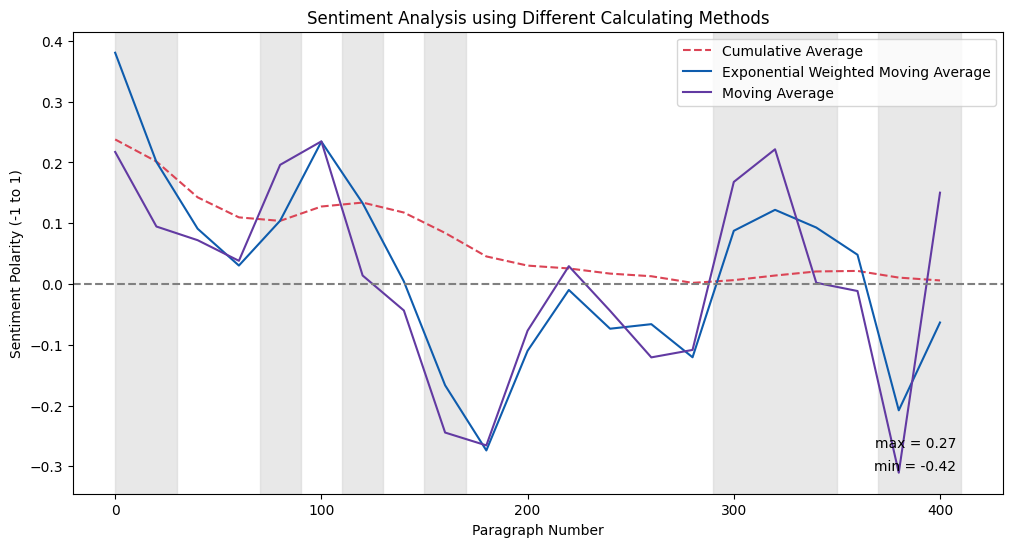

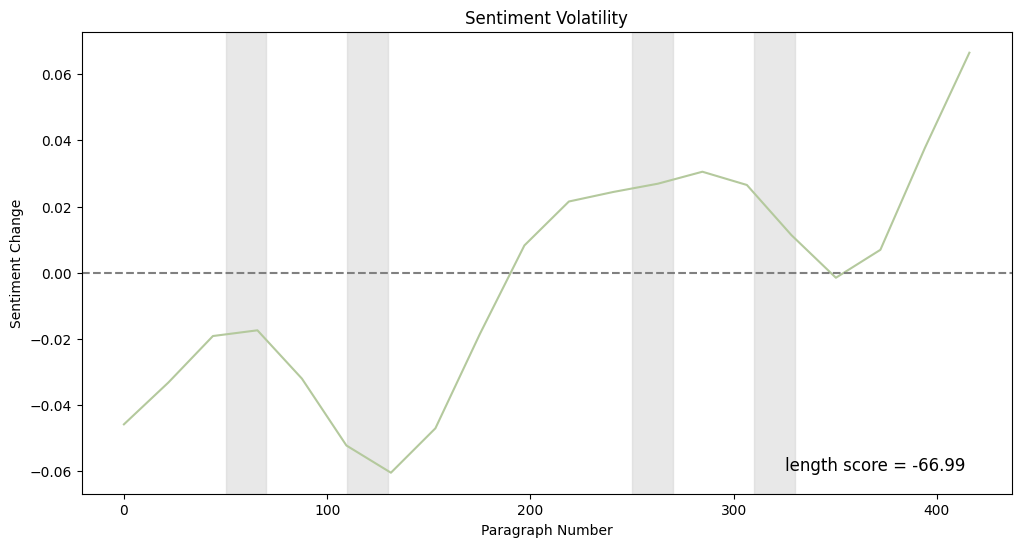

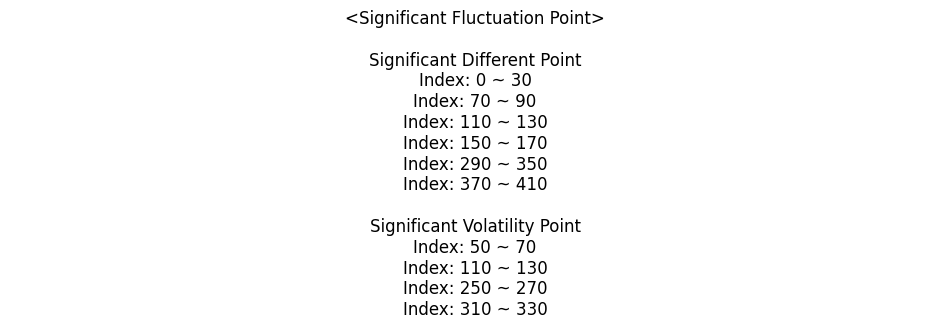

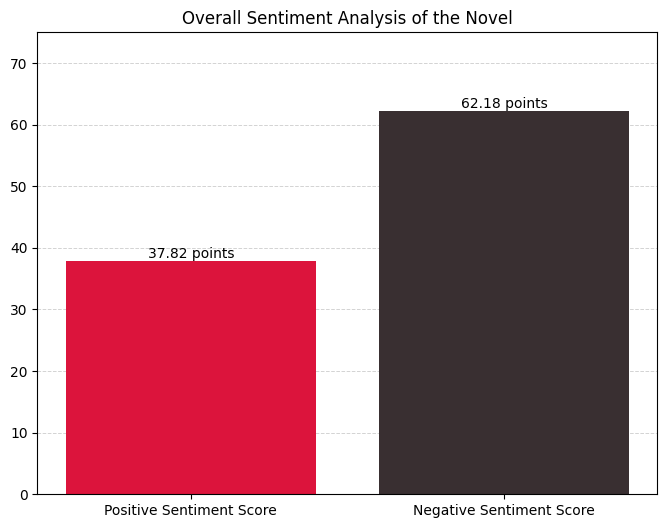

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import re
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from transformers import pipeline

# 파일 경로 설정
file_path = '/content/sample_data/Dr-Jekyll-and-Mr-Hyde.txt'  # 파일 경로를 필요에 맞게 수정하세요.

# 텍스트 파일 읽기
with open(file_path, 'r', encoding='utf-8') as file:
    text = file.read()

# 텍스트를 문단 단위로 분할 (빈 줄과 장 제목을 기준으로)
paragraphs = re.split(r'\n\n|CHAPTER \w+', text, flags=re.IGNORECASE)
paragraphs = [paragraph.strip() for paragraph in paragraphs if paragraph.strip()]  # 빈 문단 제거 및 공백 제거

# 총 문단의 개수 계산
total_paragraphs = len(paragraphs)

# 감정 분석 모델 로드 (Hugging Face Transformers, BERT 기반 모델)
sentiment_analysis_pipeline = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

# 최대 입력 길이 설정
MAX_LENGTH = 512

# 감정 분석 수행 함수 정의
def get_sentiment_score(text, prev_score=None):
    if len(text) > MAX_LENGTH:
        text = text[:MAX_LENGTH]  # 입력 문장을 최대 길이로 자르기
    results = sentiment_analysis_pipeline(text)

    # 다중 감정 인식 및 점수 할당
    emotion_scores = {'anger': 0, 'disgust': 0, 'fear': 0, 'joy': 0, 'sadness': 0}
    for result in results:
        label = result['label']
        probability = result['score']

        if label == '1 star':
            emotion_scores['sadness'] += probability
        elif label == '2 stars':
            emotion_scores['fear'] += probability
        elif label == '3 stars':
            emotion_scores['disgust'] += probability
        elif label == '4 stars':
            emotion_scores['joy'] += probability
        elif label == '5 stars':
            emotion_scores['joy'] += 2 * probability

    # 감정 점수 통합
    score = (
        -1 * emotion_scores['anger'] +
        -0.5 * emotion_scores['disgust'] +
        -0.7 * emotion_scores['fear'] +
        1 * emotion_scores['joy'] +
        -1 * emotion_scores['sadness']
    )

    return score

# 긍정적 및 부정적 단어 리스트 정의
positive_words = [
    "happy", "joyful", "excellent", "good", "wonderful", "amazing", "great", "positive", "fortunate", "pleased",
    "delightful", "content", "cheerful", "satisfied", "thrilled", "ecstatic", "merry", "elated", "jubilant", "gleeful"
]

negative_words = [
    "sad", "terrible", "bad", "awful", "horrible", "negative", "unfortunate", "displeased", "angry", "fearful",
    "miserable", "depressed", "unhappy", "downcast", "gloomy", "dismal", "wretched", "heartbroken", "melancholy", "despair"
]

# 중요 문단을 인식하기 위한 키워드 리스트
important_keywords = [
    "conflict", "resolution", "climax", "turning point", "significant", "important", "crucial", "pivotal"
]

# 감정 분석 수행 함수 정의 (중요 문단 인식 추가)
def get_sentiment_score(paragraph, prev_score=None):
    if len(paragraph) > MAX_LENGTH:
        paragraph = paragraph[:MAX_LENGTH]  # 입력 문장을 최대 길이로 자르기
    results = sentiment_analysis_pipeline(paragraph)

    # 문맥에 따라 긍정 또는 부정 가중치 적용
    context_weight = 1.0
    if any(word in paragraph for word in positive_words):
        context_weight = 1.2  # 긍정 문맥 가중치
    elif any(word in paragraph for word in negative_words):
        context_weight = 0.8  # 부정 문맥 가중치

    # 중요 문단 가중치 적용
    important_weight = 1.0
    if any(keyword in paragraph for keyword in important_keywords):
        important_weight = 1.5

    # 다중 감정 인식 및 점수 할당
    emotion_scores = {'anger': 0, 'disgust': 0, 'fear': 0, 'joy': 0, 'sadness': 0}
    for result in results:
        label = result['label']
        probability = result['score']

        if label == '1 star':
            emotion_scores['sadness'] += probability
        elif label == '2 stars':
            emotion_scores['fear'] += probability
        elif label == '3 stars':
            emotion_scores['disgust'] += probability
        elif label == '4 stars':
            emotion_scores['joy'] += probability
        elif label == '5 stars':
            emotion_scores['joy'] += 2 * probability

    # 감정 점수 통합 및 가중치 적용
    score = (
        -1 * emotion_scores['anger'] +
        -0.5 * emotion_scores['disgust'] +
        -0.7 * emotion_scores['fear'] +
        1 * emotion_scores['joy'] +
        -1 * emotion_scores['sadness']
    ) * context_weight * important_weight

    return score

# 첫 번째 문장은 이전 문장이 없으므로 먼저 처리
sentiment_analysis = [get_sentiment_score(paragraphs[0])]

# 나머지 문장 처리
for i in range(1, total_paragraphs):
    prev_score = sentiment_analysis[-1]
    sentiment_analysis.append(get_sentiment_score(paragraphs[i], prev_score))

# specific_size와 standard_num 계산
def calculate_specific_size(total_paragraphs, target_standard_num=20):
    best_specific_size = None
    closest_difference = float('inf')
    best_standard_num = None

    for specific_size in range(1, total_paragraphs + 1):
        standard_num = total_paragraphs // specific_size
        difference = abs(standard_num - target_standard_num)

        if difference < closest_difference:
            closest_difference = difference
            best_specific_size = specific_size
            best_standard_num = standard_num

        if closest_difference == 0:
            break

    return best_specific_size, best_standard_num

specific_size, standard_num = calculate_specific_size(total_paragraphs)

# 단순 누적 평균 계산
cumulative_avg = np.cumsum(sentiment_analysis) / (np.arange(total_paragraphs) + 1)

# 가중 누적 평균 계산 (EWMA)
ewma = pd.Series(sentiment_analysis).ewm(span=specific_size, adjust=False).mean()

# 이동 평균 계산 함수 정의
def moving_average(data, window_size):
    return [np.mean(data[i:i + window_size]) for i in range(0, len(data), window_size)]

# 세 가지 방법 모두 specific_size 만큼의 평균으로 통일
sentiment_avg = moving_average(sentiment_analysis, specific_size)
cumulative_avg_avg = moving_average(cumulative_avg, specific_size)
ewma_avg = moving_average(ewma, specific_size)

# 이동 평균의 최대값과 최소값 계산
moving_avg_max = max(sentiment_avg)
moving_avg_min = min(sentiment_avg)

# sigma 값을 동적으로 설정
sigma_value = max(0.1, min(1.0, 10.0 / np.sqrt(total_paragraphs)))  # 문장의 수에 따라 sigma 값을 조정
sentiment_avg_smooth = gaussian_filter1d(sentiment_avg, sigma=sigma_value)
cumulative_avg_smooth = gaussian_filter1d(cumulative_avg_avg, sigma=sigma_value)
ewma_avg_smooth = gaussian_filter1d(ewma_avg, sigma=sigma_value)

# X 좌표 설정
x_sentiment = np.arange(len(sentiment_avg)) * specific_size
x_cumulative = np.arange(len(cumulative_avg_avg)) * specific_size
x_ewma = np.arange(len(ewma_avg)) * specific_size

# 차이가 크게 나타나는 구간 식별
difference = np.abs(np.array(ewma_avg) - np.array(sentiment_avg))
std_dev_difference = np.std(difference)
threshold_difference = 1.2 * std_dev_difference  # 이동 표준 편차의 1.2배를 임계값으로 설정

significant_diff_indices = np.where(difference >= threshold_difference)[0]

# 오차 범위를 고려한 실제 문장 인덱스 계산
actual_diff_indices = []
for idx in significant_diff_indices:
    start_idx = max(0, idx * specific_size - specific_size // 2)
    end_idx = min(total_paragraphs, idx * specific_size + specific_size // 2)
    actual_diff_indices.append((start_idx, end_idx))

# 인접한 구간 합치기
merged_diff_indices = []
for start_idx, end_idx in actual_diff_indices:
    if not merged_diff_indices:
        merged_diff_indices.append([start_idx, end_idx])
    else:
        last_start, last_end = merged_diff_indices[-1]
        if start_idx <= last_end:
            merged_diff_indices[-1] = [last_start, max(last_end, end_idx)]
        else:
            merged_diff_indices.append([start_idx, end_idx])

# Sentiment Volatility 계산
volatility = np.diff(sentiment_avg_smooth)

# 가우시안 스무딩 적용 (곡률을 더 크게)
volatility_smooth = gaussian_filter1d(volatility, sigma=2)

# Sentiment Volatility에서 차이가 크게 나타나는 구간 식별
volatility_diff_indices = []
for i in range(1, len(volatility_smooth) - 1):
    if (volatility_smooth[i] > volatility_smooth[i-1] and volatility_smooth[i] > volatility_smooth[i+1]) or \
       (volatility_smooth[i] < volatility_smooth[i-1] and volatility_smooth[i] < volatility_smooth[i+1]):
        volatility_diff_indices.append(i)

# 오차 범위를 고려한 실제 문장 인덱스 계산
actual_volatility_indices = []
for idx in volatility_diff_indices:
    start_idx = max(0, idx * specific_size - specific_size // 2)
    end_idx = min(total_paragraphs, idx * specific_size + specific_size // 2)
    actual_volatility_indices.append((start_idx, end_idx))

# 인접한 구간 합치기
merged_volatility_indices = []
for start_idx, end_idx in actual_volatility_indices:
    if not merged_volatility_indices:
        merged_volatility_indices.append([start_idx, end_idx])
    else:
        last_start, last_end = merged_volatility_indices[-1]
        if start_idx <= last_end:
            merged_volatility_indices[-1] = [last_start, max(last_end, end_idx)]
        else:
            merged_volatility_indices.append([start_idx, end_idx])

# 그래프 그리기 (Sentiment Analysis)
plt.figure(figsize=(12, 6))

# 단순 누적 평균
plt.plot(x_cumulative, cumulative_avg_smooth, color='#DB4455', linestyle='--', label='Cumulative Average')

# 가중 누적 평균 (EWMA)
plt.plot(x_ewma, ewma_avg_smooth, color='#0E5CAD', linestyle='-', label='Exponential Weighted Moving Average')

# 이동 평균
plt.plot(x_sentiment, sentiment_avg_smooth, color='#623AA2', linestyle='-', label='Moving Average')

# S.D.P. 영역 추가
for start_idx, end_idx in merged_diff_indices:
    end_idx = min(end_idx, total_paragraphs)  # 소설의 끝을 넘지 않도록 조정
    plt.axvspan(start_idx, end_idx, color='lightgrey', alpha=0.5)

plt.xlabel('Paragraph Number')
plt.ylabel('Sentiment Polarity (-1 to 1)')
plt.title('Sentiment Analysis using Different Calculating Methods')
plt.axhline(0, color='grey', linestyle='--')  # 중립 감정선
plt.legend()

# 이동 평균의 최대값과 최소값을 그래프에 표시
plt.text(0.95, 0.10, f"max = {moving_avg_max:.2f}", fontsize=10, color='black', transform=plt.gca().transAxes, ha='right')
plt.text(0.95, 0.05, f"min = {moving_avg_min:.2f}", fontsize=10, color='black', transform=plt.gca().transAxes, ha='right')

plt.show()

# 그래프 그리기 (Sentiment Volatility)
plt.figure(figsize=(12, 6))

# x축을 문장의 수에 맞게 조정
plt.plot(np.linspace(0, total_paragraphs, len(volatility_smooth)), volatility_smooth, color='#B4C99D', linestyle='-')
plt.axhline(0, color='grey', linestyle='--')  # y=0의 값에 회색 점선 추가

plt.xlabel('Paragraph Number')
plt.ylabel('Sentiment Change')
plt.title('Sentiment Volatility')

# S.V.P. 영역 추가
for start_idx, end_idx in merged_volatility_indices:
    end_idx = min(end_idx, total_paragraphs)  # 소설의 끝을 넘지 않도록 조정
    plt.axvspan(start_idx, end_idx, color='lightgrey', alpha=0.5)

# 길이 점수 출력 (그래프의 '네모 박스'의 우측 하단에 표시)
plt.text(0.95, 0.05, f"length score = {volatility_smooth.sum() * 1000:.2f}", fontsize=12, color='black', transform=plt.gca().transAxes, ha='right')

plt.show()

# 실제 문장 인덱스 기반 텍스트 분석
fig, ax = plt.subplots(figsize=(12, 2))
ax.text(0.5, 0.5, "<Significant Fluctuation Point>\n\nSignificant Different Point\n" + '\n'.join(
    [f"Index: {start} ~ {end}" for start, end in merged_diff_indices]) + "\n\nSignificant Volatility Point\n" + '\n'.join(
    [f"Index: {start} ~ {end}" for start, end in merged_volatility_indices]), horizontalalignment='center', verticalalignment='center', fontsize=12)
ax.axis('off')
plt.show()

# 문단별 긍정 및 부정 점수 분리
positive_scores = [score for score in sentiment_analysis if score > 0]
negative_scores = [score for score in sentiment_analysis if score < 0]

# 긍정 및 부정 점수 합산 (절댓값 사용)
positive_score_sum = sum(positive_scores)
negative_score_sum = abs(sum(negative_scores))

# 가중치 적용 (문단 수)
positive_weighted_sum = positive_score_sum * len(positive_scores)
negative_weighted_sum = negative_score_sum * len(negative_scores)

# 총합 계산
total_weighted_sum = positive_weighted_sum + negative_weighted_sum

# 백분율로 환산
positive_final_score = (positive_weighted_sum / total_weighted_sum) * 100
negative_final_score = (negative_weighted_sum / total_weighted_sum) * 100

# 막대 바 차트 시각화 수정된 코드
fig, ax = plt.subplots(figsize=(8, 6))

# 데이터 준비
categories = ['Positive Sentiment Score', 'Negative Sentiment Score']
scores = [positive_final_score, negative_final_score]
colors = ["#DC143C", "#392F31"]

# 막대 바 차트 그리기
bars = plt.bar(categories, scores, color=colors)

# 레이블 추가 (막대 바 위쪽에 위치하도록)
for bar, score in zip(bars, scores):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, yval + 0.1, f'{score:.2f} points', ha='center', va='bottom', color='black')

# y축 최대값 설정
max_score = max(positive_final_score, negative_final_score)
ymax = np.ceil(max_score * 1.2)

# y축에 숫자를 표시한 지점마다 x축과 평행한 점선 추가
ax.yaxis.grid(True, which='both', color='lightgrey', linestyle='--', linewidth=0.7)
ax.set_axisbelow(True)
ax.set_ylim(0, ymax)

# 제목 설정
plt.title('Overall Sentiment Analysis of the Novel')

plt.show()

### (2) 모델 분석 결과에 대한 타당성 평가

#### 감정 극성의 범위와 그 적절성
- **수치**: -0.42부터 +0.27
- **이유 및 타당성 설명**: "Dr. Jekyll and Mr. Hyde"는 선과 악의 이중성을 다루는 작품으로, 주인공들의 극단적인 감정 변화를 잘 반영하고 있습니다. 감정 극성의 범위는 주인공의 분열된 내면과 행동을 잘 나타내고 있습니다.<br><br>

#### Significant Different Point (SDP)의 설명
- **설명**: 모델이 감정 변화가 두드러지는 주요 사건을 잘 포착하고 있습니다. 특히 지킬 박사의 실험이 진행되는 과정과 하이드의 폭력적인 행동을 중심으로 감정의 변화를 정확히 반영하였습니다. 이는 지킬 박사가 자신의 변화를 자각하는 장면(290 ~ 350번대 문단)과 하이드의 범죄 장면(370 ~ 410번대 문단)에서의 감정 변화를 잘 포착한 결과입니다.<br><br>

#### Significant Volatility Point (SVP)의 설명
- **설명**: 모델이 감정 변화가 두드러지는 주요 사건을 잘 포착하고 있습니다. 특히 지킬 박사와 하이드의 충돌이 극대화되는 순간(310 ~ 330번대 문단)과 같은 중요한 장면에서의 감정 변화를 잘 포착한 결과입니다.<br><br>

#### Significant Fluctuation Point (SFP)의 설명
- **설명**: 전반적으로 SDP와 SVP의 설정이 적절하게 이루어졌습니다. 특히, 겹쳤던 310 ~ 330번대 문단의 경우 지킬 박사와 하이드 사이의 내적 갈등과 긴장감이 고조되는 부분을 잘 다루고 있다고 할 수 있겠습니다.<br><br>

#### 전반적인 긍정적/부정적 점수와 그 적절성
- **긍정 점수**: 37.82 points
- **부정 점수**: 62.18 points
- **이유 및 타당성 설명**: 소설의 전반적인 분위기가 부정적임을 나타내며, 이는 인물들의 내적 갈등과 파멸을 잘 반영한 결과입니다.<br><br>

#### 종합 평가
- 모델은 "Dr. Jekyll and Mr. Hyde"의 감정을 효과적으로 분석하였으며, 각 분석 지표가 소설의 주요 테마와 사건을 잘 반영하고 있습니다.
- 이를 통해 모델이 텍스트의 감정 변화를 정밀하게 포착할 수 있음을 확인할 수 있습니다.<br><br>


### (3) 인문학적 후속 분석

#### 감정 극성의 변화 그래프를 통해 지킬과 하이드의 주요 장면에서 감정 변화를 분석하여 이중성을 평가합니다.
- **주요 감정 변화 장면**:
  - **지킬 박사의 실험 (Index 110 ~ 130)**: 지킬 박사가 처음으로 하이드로 변하는 장면에서는 긍정적인 감정이 상승하지만 곧이어 두려움과 불안이 나타나며 감정의 극단적인 변화를 보입니다. 감정 그래프에서도 이 시점에서 급격한 상승 후 하락을 볼 수 있습니다.
  - **하이드의 범죄 장면 (Index 290 ~ 350)**: 하이드가 폭력적인 행동을 저지르는 장면에서는 부정적인 감정이 극대화되며, 하이드의 악한 성격이 두드러집니다. 감정 그래프에서 이 구간은 급격한 하락을 보여주며, 부정적인 감정의 상승을 반영합니다.
  - **지킬 박사와 하이드의 충돌 (Index 370 ~ 410)**: 지킬 박사와 하이드의 내적 갈등이 최고조에 달하는 장면에서는 감정의 변동이 크게 나타나며, 두 인격 사이의 극단적인 대립을 보여줍니다. 그래프에서 이 구간은 감정의 변동이 극대화되는 것을 볼 수 있습니다.
  - **지킬 박사의 자살 (Index 400 ~ 410)**: 지킬 박사가 자신의 상황을 비극적으로 인식하고 자살을 선택하는 장면에서 감정의 극단적인 변동이 나타납니다. 이 구간에서 감정의 하락폭이 급격히 나타나며, 절망적인 감정이 반영됩니다.<br><br>

#### 소설의 전반적인 감정 점수를 통해 전반적인 분위기를 평가합니다.
- **긍정 점수**: 37.82 points
- **부정 점수**: 62.18 points
- **분석**: 전체적으로 소설은 부정적인 분위기가 강하며, 이는 지킬 박사와 하이드의 내적 갈등과 파멸을 잘 반영합니다. 감정 변화가 격렬하며, 두 인격 사이의 갈등이 크게 나타납니다. 감정 그래프에서의 급격한 변동은 소설의 주요 테마와 사건을 잘 반영하고 있습니다.<br><br>




---



##**10. 앤 브론테, "아그네스 그레이" (Agnes Grey)**

###**(1) 모델 분석 결과**

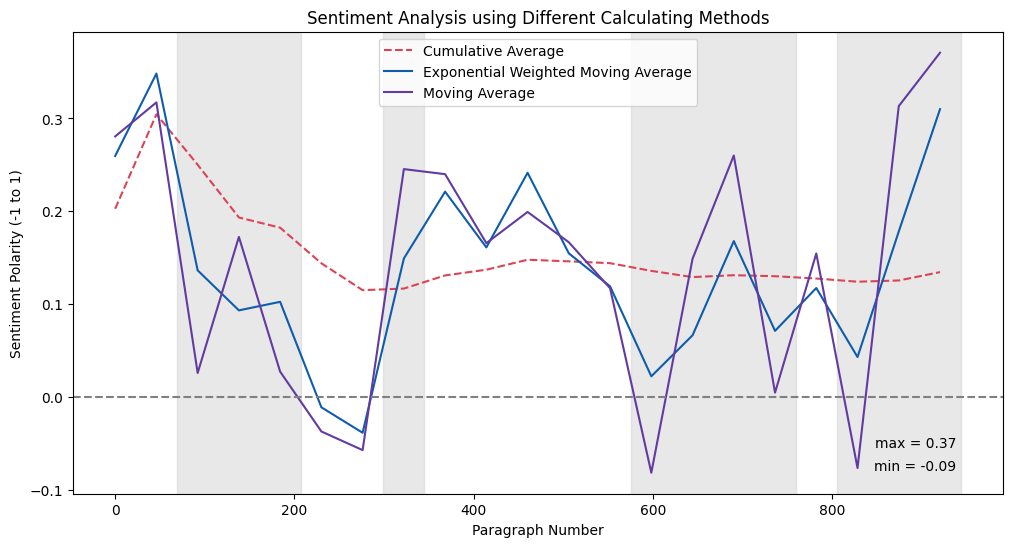

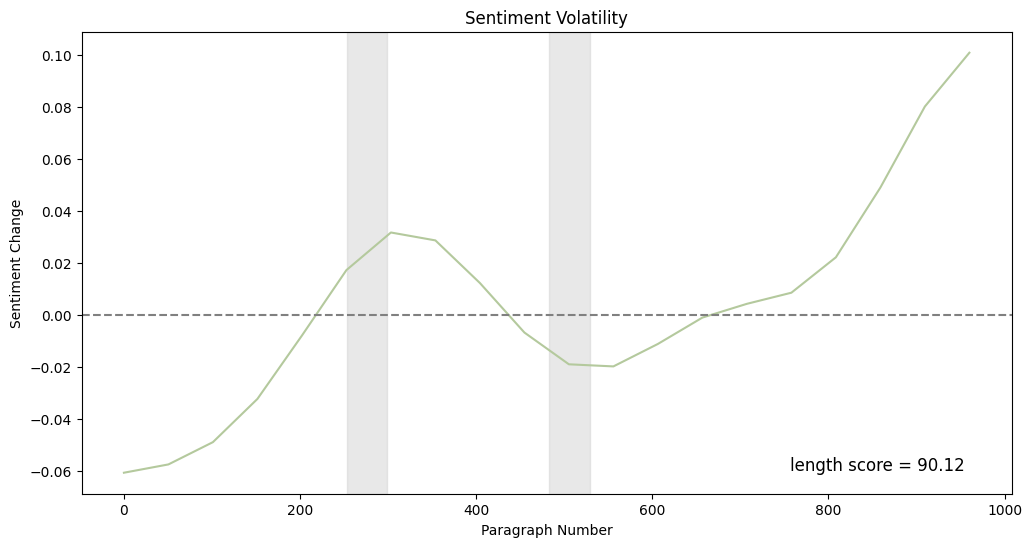

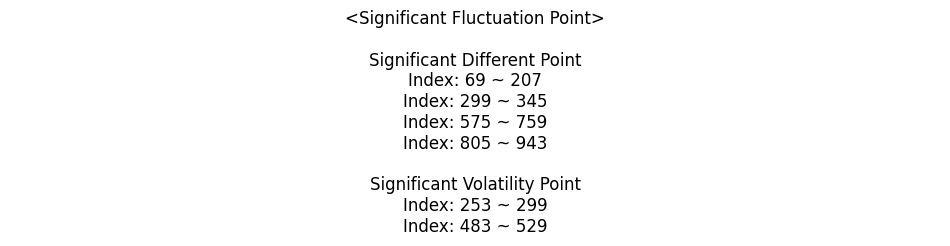

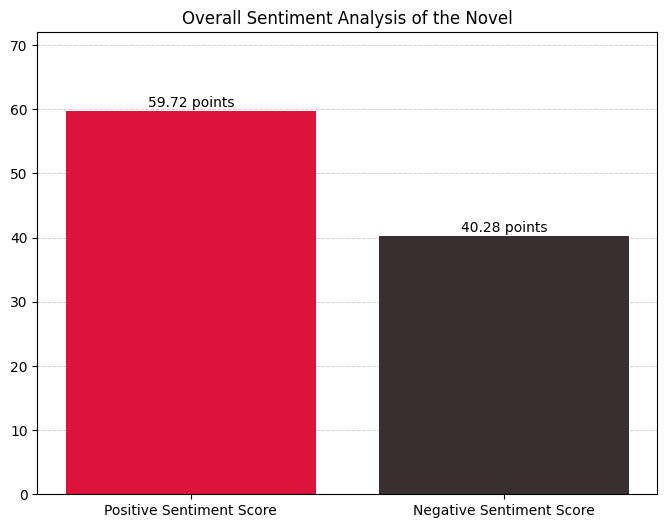

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import re
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from transformers import pipeline

# 파일 경로 설정
file_path = '/content/sample_data/Agnes-Grey.txt'  # 파일 경로를 필요에 맞게 수정하세요.

# 텍스트 파일 읽기
with open(file_path, 'r', encoding='utf-8') as file:
    text = file.read()

# 텍스트를 문단 단위로 분할 (빈 줄과 장 제목을 기준으로)
paragraphs = re.split(r'\n\n|CHAPTER [IVXLCDM]+\.', text, flags=re.IGNORECASE)
paragraphs = [paragraph.strip() for paragraph in paragraphs if paragraph.strip()]  # 빈 문단 제거 및 공백 제거

# 총 문단의 개수 계산
total_paragraphs = len(paragraphs)

# 감정 분석 모델 로드 (Hugging Face Transformers, BERT 기반 모델)
sentiment_analysis_pipeline = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

# 최대 입력 길이 설정
MAX_LENGTH = 512

# 감정 분석 수행 함수 정의
def get_sentiment_score(text, prev_score=None):
    if len(text) > MAX_LENGTH:
        text = text[:MAX_LENGTH]  # 입력 문장을 최대 길이로 자르기
    results = sentiment_analysis_pipeline(text)

    # 다중 감정 인식 및 점수 할당
    emotion_scores = {'anger': 0, 'disgust': 0, 'fear': 0, 'joy': 0, 'sadness': 0}
    for result in results:
        label = result['label']
        probability = result['score']

        if label == '1 star':
            emotion_scores['sadness'] += probability
        elif label == '2 stars':
            emotion_scores['fear'] += probability
        elif label == '3 stars':
            emotion_scores['disgust'] += probability
        elif label == '4 stars':
            emotion_scores['joy'] += probability
        elif label == '5 stars':
            emotion_scores['joy'] += 2 * probability

    # 감정 점수 통합
    score = (
        -1 * emotion_scores['anger'] +
        -0.5 * emotion_scores['disgust'] +
        -0.7 * emotion_scores['fear'] +
        1 * emotion_scores['joy'] +
        -1 * emotion_scores['sadness']
    )

    return score

# 긍정적 및 부정적 단어 리스트 정의
positive_words = [
    "happy", "joyful", "excellent", "good", "wonderful", "amazing", "great", "positive", "fortunate", "pleased",
    "delightful", "content", "cheerful", "satisfied", "thrilled", "ecstatic", "merry", "elated", "jubilant", "gleeful"
]

negative_words = [
    "sad", "terrible", "bad", "awful", "horrible", "negative", "unfortunate", "displeased", "angry", "fearful",
    "miserable", "depressed", "unhappy", "downcast", "gloomy", "dismal", "wretched", "heartbroken", "melancholy", "despair"
]

# 중요 문단을 인식하기 위한 키워드 리스트
important_keywords = [
    "conflict", "resolution", "climax", "turning point", "significant", "important", "crucial", "pivotal"
]

# 감정 분석 수행 함수 정의 (중요 문단 인식 추가)
def get_sentiment_score(paragraph, prev_score=None):
    if len(paragraph) > MAX_LENGTH:
        paragraph = paragraph[:MAX_LENGTH]  # 입력 문장을 최대 길이로 자르기
    results = sentiment_analysis_pipeline(paragraph)

    # 문맥에 따라 긍정 또는 부정 가중치 적용
    context_weight = 1.0
    if any(word in paragraph for word in positive_words):
        context_weight = 1.2  # 긍정 문맥 가중치
    elif any(word in paragraph for word in negative_words):
        context_weight = 0.8  # 부정 문맥 가중치

    # 중요 문단 가중치 적용
    important_weight = 1.0
    if any(keyword in paragraph for keyword in important_keywords):
        important_weight = 1.5

    # 다중 감정 인식 및 점수 할당
    emotion_scores = {'anger': 0, 'disgust': 0, 'fear': 0, 'joy': 0, 'sadness': 0}
    for result in results:
        label = result['label']
        probability = result['score']

        if label == '1 star':
            emotion_scores['sadness'] += probability
        elif label == '2 stars':
            emotion_scores['fear'] += probability
        elif label == '3 stars':
            emotion_scores['disgust'] += probability
        elif label == '4 stars':
            emotion_scores['joy'] += probability
        elif label == '5 stars':
            emotion_scores['joy'] += 2 * probability

    # 감정 점수 통합 및 가중치 적용
    score = (
        -1 * emotion_scores['anger'] +
        -0.5 * emotion_scores['disgust'] +
        -0.7 * emotion_scores['fear'] +
        1 * emotion_scores['joy'] +
        -1 * emotion_scores['sadness']
    ) * context_weight * important_weight

    return score

# 첫 번째 문장은 이전 문장이 없으므로 먼저 처리
sentiment_analysis = [get_sentiment_score(paragraphs[0])]

# 나머지 문장 처리
for i in range(1, total_paragraphs):
    prev_score = sentiment_analysis[-1]
    sentiment_analysis.append(get_sentiment_score(paragraphs[i], prev_score))

# specific_size와 standard_num 계산
def calculate_specific_size(total_paragraphs, target_standard_num=20):
    best_specific_size = None
    closest_difference = float('inf')
    best_standard_num = None

    for specific_size in range(1, total_paragraphs + 1):
        standard_num = total_paragraphs // specific_size
        difference = abs(standard_num - target_standard_num)

        if difference < closest_difference:
            closest_difference = difference
            best_specific_size = specific_size
            best_standard_num = standard_num

        if closest_difference == 0:
            break

    return best_specific_size, best_standard_num

specific_size, standard_num = calculate_specific_size(total_paragraphs)

# 단순 누적 평균 계산
cumulative_avg = np.cumsum(sentiment_analysis) / (np.arange(total_paragraphs) + 1)

# 가중 누적 평균 계산 (EWMA)
ewma = pd.Series(sentiment_analysis).ewm(span=specific_size, adjust=False).mean()

# 이동 평균 계산 함수 정의
def moving_average(data, window_size):
    return [np.mean(data[i:i + window_size]) for i in range(0, len(data), window_size)]

# 세 가지 방법 모두 specific_size 만큼의 평균으로 통일
sentiment_avg = moving_average(sentiment_analysis, specific_size)
cumulative_avg_avg = moving_average(cumulative_avg, specific_size)
ewma_avg = moving_average(ewma, specific_size)

# 이동 평균의 최대값과 최소값 계산
moving_avg_max = max(sentiment_avg)
moving_avg_min = min(sentiment_avg)

# sigma 값을 동적으로 설정
sigma_value = max(0.1, min(1.0, 10.0 / np.sqrt(total_paragraphs)))  # 문장의 수에 따라 sigma 값을 조정
sentiment_avg_smooth = gaussian_filter1d(sentiment_avg, sigma=sigma_value)
cumulative_avg_smooth = gaussian_filter1d(cumulative_avg_avg, sigma=sigma_value)
ewma_avg_smooth = gaussian_filter1d(ewma_avg, sigma=sigma_value)

# X 좌표 설정
x_sentiment = np.arange(len(sentiment_avg)) * specific_size
x_cumulative = np.arange(len(cumulative_avg_avg)) * specific_size
x_ewma = np.arange(len(ewma_avg)) * specific_size

# 차이가 크게 나타나는 구간 식별
difference = np.abs(np.array(ewma_avg) - np.array(sentiment_avg))
std_dev_difference = np.std(difference)
threshold_difference = 1.2 * std_dev_difference  # 이동 표준 편차의 1.2배를 임계값으로 설정

significant_diff_indices = np.where(difference >= threshold_difference)[0]

# 오차 범위를 고려한 실제 문장 인덱스 계산
actual_diff_indices = []
for idx in significant_diff_indices:
    start_idx = max(0, idx * specific_size - specific_size // 2)
    end_idx = min(total_paragraphs, idx * specific_size + specific_size // 2)
    actual_diff_indices.append((start_idx, end_idx))

# 인접한 구간 합치기
merged_diff_indices = []
for start_idx, end_idx in actual_diff_indices:
    if not merged_diff_indices:
        merged_diff_indices.append([start_idx, end_idx])
    else:
        last_start, last_end = merged_diff_indices[-1]
        if start_idx <= last_end:
            merged_diff_indices[-1] = [last_start, max(last_end, end_idx)]
        else:
            merged_diff_indices.append([start_idx, end_idx])

# Sentiment Volatility 계산
volatility = np.diff(sentiment_avg_smooth)

# 가우시안 스무딩 적용 (곡률을 더 크게)
volatility_smooth = gaussian_filter1d(volatility, sigma=2)

# Sentiment Volatility에서 차이가 크게 나타나는 구간 식별
volatility_diff_indices = []
for i in range(1, len(volatility_smooth) - 1):
    if (volatility_smooth[i] > volatility_smooth[i-1] and volatility_smooth[i] > volatility_smooth[i+1]) or \
       (volatility_smooth[i] < volatility_smooth[i-1] and volatility_smooth[i] < volatility_smooth[i+1]):
        volatility_diff_indices.append(i)

# 오차 범위를 고려한 실제 문장 인덱스 계산
actual_volatility_indices = []
for idx in volatility_diff_indices:
    start_idx = max(0, idx * specific_size - specific_size // 2)
    end_idx = min(total_paragraphs, idx * specific_size + specific_size // 2)
    actual_volatility_indices.append((start_idx, end_idx))

# 인접한 구간 합치기
merged_volatility_indices = []
for start_idx, end_idx in actual_volatility_indices:
    if not merged_volatility_indices:
        merged_volatility_indices.append([start_idx, end_idx])
    else:
        last_start, last_end = merged_volatility_indices[-1]
        if start_idx <= last_end:
            merged_volatility_indices[-1] = [last_start, max(last_end, end_idx)]
        else:
            merged_volatility_indices.append([start_idx, end_idx])

# 그래프 그리기 (Sentiment Analysis)
plt.figure(figsize=(12, 6))

# 단순 누적 평균
plt.plot(x_cumulative, cumulative_avg_smooth, color='#DB4455', linestyle='--', label='Cumulative Average')

# 가중 누적 평균 (EWMA)
plt.plot(x_ewma, ewma_avg_smooth, color='#0E5CAD', linestyle='-', label='Exponential Weighted Moving Average')

# 이동 평균
plt.plot(x_sentiment, sentiment_avg_smooth, color='#623AA2', linestyle='-', label='Moving Average')

# S.D.P. 영역 추가
for start_idx, end_idx in merged_diff_indices:
    end_idx = min(end_idx, total_paragraphs)  # 소설의 끝을 넘지 않도록 조정
    plt.axvspan(start_idx, end_idx, color='lightgrey', alpha=0.5)

plt.xlabel('Paragraph Number')
plt.ylabel('Sentiment Polarity (-1 to 1)')
plt.title('Sentiment Analysis using Different Calculating Methods')
plt.axhline(0, color='grey', linestyle='--')  # 중립 감정선
plt.legend()

# 이동 평균의 최대값과 최소값을 그래프에 표시
plt.text(0.95, 0.10, f"max = {moving_avg_max:.2f}", fontsize=10, color='black', transform=plt.gca().transAxes, ha='right')
plt.text(0.95, 0.05, f"min = {moving_avg_min:.2f}", fontsize=10, color='black', transform=plt.gca().transAxes, ha='right')

plt.show()

# 그래프 그리기 (Sentiment Volatility)
plt.figure(figsize=(12, 6))

# x축을 문장의 수에 맞게 조정
plt.plot(np.linspace(0, total_paragraphs, len(volatility_smooth)), volatility_smooth, color='#B4C99D', linestyle='-')
plt.axhline(0, color='grey', linestyle='--')  # y=0의 값에 회색 점선 추가

plt.xlabel('Paragraph Number')
plt.ylabel('Sentiment Change')
plt.title('Sentiment Volatility')

# S.V.P. 영역 추가
for start_idx, end_idx in merged_volatility_indices:
    end_idx = min(end_idx, total_paragraphs)  # 소설의 끝을 넘지 않도록 조정
    plt.axvspan(start_idx, end_idx, color='lightgrey', alpha=0.5)

# 길이 점수 출력 (그래프의 '네모 박스'의 우측 하단에 표시)
plt.text(0.95, 0.05, f"length score = {volatility_smooth.sum() * 1000:.2f}", fontsize=12, color='black', transform=plt.gca().transAxes, ha='right')

plt.show()

# 실제 문장 인덱스 기반 텍스트 분석
fig, ax = plt.subplots(figsize=(12, 2))
ax.text(0.5, 0.5, "<Significant Fluctuation Point>\n\nSignificant Different Point\n" + '\n'.join(
    [f"Index: {start} ~ {end}" for start, end in merged_diff_indices]) + "\n\nSignificant Volatility Point\n" + '\n'.join(
    [f"Index: {start} ~ {end}" for start, end in merged_volatility_indices]), horizontalalignment='center', verticalalignment='center', fontsize=12)
ax.axis('off')
plt.show()

# 문단별 긍정 및 부정 점수 분리
positive_scores = [score for score in sentiment_analysis if score > 0]
negative_scores = [score for score in sentiment_analysis if score < 0]

# 긍정 및 부정 점수 합산 (절댓값 사용)
positive_score_sum = sum(positive_scores)
negative_score_sum = abs(sum(negative_scores))

# 가중치 적용 (문단 수)
positive_weighted_sum = positive_score_sum * len(positive_scores)
negative_weighted_sum = negative_score_sum * len(negative_scores)

# 총합 계산
total_weighted_sum = positive_weighted_sum + negative_weighted_sum

# 백분율로 환산
positive_final_score = (positive_weighted_sum / total_weighted_sum) * 100
negative_final_score = (negative_weighted_sum / total_weighted_sum) * 100

# 막대 바 차트 시각화 수정된 코드
fig, ax = plt.subplots(figsize=(8, 6))

# 데이터 준비
categories = ['Positive Sentiment Score', 'Negative Sentiment Score']
scores = [positive_final_score, negative_final_score]
colors = ["#DC143C", "#392F31"]

# 막대 바 차트 그리기
bars = plt.bar(categories, scores, color=colors)

# 레이블 추가 (막대 바 위쪽에 위치하도록)
for bar, score in zip(bars, scores):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, yval + 0.1, f'{score:.2f} points', ha='center', va='bottom', color='black')

# y축 최대값 설정
max_score = max(positive_final_score, negative_final_score)
ymax = np.ceil(max_score * 1.2)

# y축에 숫자를 표시한 지점마다 x축과 평행한 점선 추가
ax.yaxis.grid(True, which='both', color='lightgrey', linestyle='--', linewidth=0.7)
ax.set_axisbelow(True)
ax.set_ylim(0, ymax)

# 제목 설정
plt.title('Overall Sentiment Analysis of the Novel')

plt.show()

### (2) 모델 분석 결과에 대한 타당성 평가

#### 감정 극성의 범위와 그 적절성
- **수치**: -0.09부터 +0.37
- **이유 및 타당성 설명**: "Agnes Grey"는 주인공 아그네스의 교사로서의 경험과 개인적 성장을 다루는 소설로, 감정의 극단적인 변화보다는 일상적인 감정의 변화를 중심으로 이야기가 전개됩니다. 감정 극성의 범위가 소설의 전반적인 톤과 주제에 적절하게 반영되어 있습니다.<br><br>

#### Significant Different Point (SDP)의 설명
- **설명**: 모델이 감정 변화가 두드러지는 주요 사건을 잘 포착하고 있습니다. 특히 아그네스가 어려운 아이들을 가르치는 과정에서의 감정 변화(Index 69 ~ 207), 아그네스와 웨스턴 목사의 첫 만남(Index 299 ~ 345) 등에서의 감정 변화를 정확히 반영하고 있습니다.<br><br>

#### Significant Volatility Point (SVP)의 설명
- **설명**: 모델이 감정 변동이 큰 주요 순간을 잘 포착하고 있습니다. 특히 아그네스가 교사로서의 어려움을 극복하는 과정(Index 253 ~ 299), 웨스턴 목사와의 감정적 갈등(Index 483 ~ 529) 등에서의 감정 변동을 잘 반영하고 있습니다.<br><br>

#### Significant Fluctuation Point (SFP)의 설명
- **설명**: 전반적으로 SDP와 SVP의 설정이 적절하게 이루어졌습니다. 특히 겹쳤던 299 ~ 345번대 문단의 경우 아그네스와 웨스턴 목사의 첫 만남이 이루어지는 장면을 잘 다루고 있다고 할 수 있겠습니다.<br><br>

#### 전반적인 긍정적/부정적 점수와 그 적절성
- **긍정 점수**: 59.72 points
- **부정 점수**: 40.28 points
- **이유 및 타당성 설명**: 소설의 전반적인 분위기가 긍정적임을 나타내며, 이는 아그네스의 성장과 사랑, 그리고 교사로서의 성취를 잘 반영한 결과입니다.<br><br>

#### 종합 평가
- 모델은 "Agnes Grey"의 감정을 효과적으로 분석하였으며, 각 분석 지표가 소설의 주요 테마와 사건을 잘 반영하고 있습니다.
- 이를 통해 모델이 텍스트의 감정 변화를 정밀하게 포착할 수 있음을 확인할 수 있습니다.<br><br>

### (3) 인문학적 후속 분석

#### 아그네스의 주요 장면에서 감정 변화를 분석하여 그녀의 성장 과정을 평가
- **주요 감정 변화 장면**:
  - **아그네스의 교사로서의 첫 경험 (Index 69 ~ 207)**: 아그네스가 처음으로 어려운 아이들을 가르치는 장면에서 감정의 변화를 포착합니다. 이 과정에서 아그네스는 좌절과 실망을 겪으며, 초기의 어려움을 통해 교사로서의 자아를 형성하게 됩니다.
    - **그래프 분석**: 이 구간에서 감정 극성이 긍정적인 방향으로 움직이다가 다시 부정적인 방향으로 하락하는 모습이 보입니다. 이는 아그네스가 첫 번째 교사 경험에서 겪는 좌절과 실망을 반영합니다.<br><br>
    
  - **웨스턴 목사와의 첫 만남 (Index 299 ~ 345)**: 웨스턴 목사와의 첫 만남에서 느끼는 감정의 변화를 분석합니다. 이 장면에서 아그네스는 새로운 사람과의 만남에서 느끼는 설렘과 기대를 경험하게 됩니다.
    - **그래프 분석**: 이 구간에서 감정 극성이 급상승하는 모습을 보입니다. 이는 아그네스가 웨스턴 목사와의 만남에서 느끼는 긍정적인 감정을 반영합니다.<br><br>

  - **교사로서의 어려움 극복 (Index 575 ~ 759)**: 아그네스가 교사로서의 어려움을 극복하고, 학생들과의 관계를 개선하는 과정에서의 감정 변화를 포착합니다. 이 과정에서 아그네스는 자신감을 회복하며, 교사로서의 자아를 확립하게 됩니다.
    - **그래프 분석**: 이 구간에서 감정 극성이 부정적인 방향으로 하락했다가 다시 긍정적인 방향으로 상승하는 모습이 보입니다. 이는 아그네스가 교사로서의 어려움을 극복하고 성장하는 과정을 반영합니다.<br><br>

  - **웨스턴 목사와의 감정적 갈등 (Index 805 ~ 943)**: 웨스턴 목사와의 감정적 갈등을 겪는 장면에서의 감정 변화를 분석합니다. 이 과정에서 아그네스는 감정적 성숙을 이루며, 자신의 감정을 이해하고 표현하는 법을 배우게 됩니다.
    - **그래프 분석**: 이 구간에서 감정 극성이 급상승하는 모습을 보입니다. 이는 아그네스가 웨스턴 목사와의 갈등을 통해 감정적으로 성장하는 과정을 반영합니다.<br><br>

#### 소설의 전반적인 분위기 평가
- **분석**: "Agnes Grey"는 전반적으로 긍정적인 감정이 주를 이루지만, 성장과 자아 발견의 과정에서 겪는 감정적 변화가 두드러집니다. 아그네스는 교사로서의 도전과 사랑, 그리고 개인적 성장을 통해 자아를 확립해 나가는 과정을 겪습니다. 이 과정에서 다양한 감정 변화를 경험하며, 이러한 감정의 변동이 소설 전반에 걸쳐 잘 반영되고 있습니다. 감정의 변화가 잦고, 성장과 자아 발견의 과정이 강조된 소설로, 아그네스의 긍정적인 성장 이야기가 두드러집니다.<br><br>




---



## **Appendix. 길이 점수(Length Score)의 비교 및 분석**

분석한 총 10개의 소설들의 length score를 비교하고, 이 점수들이 왜 높거나 낮았는지에 대해 분석해보겠습니다.<br><br>

| 소설 제목                                             | Length Score |
|-------------------------------------------------------|--------------|
| 두 도시 이야기 (A Tale of Two Cities)                | 20.82        |
| 오만과 편견 (Pride and Prejudice)                     | 132.65       |
| 허클베리 핀의 모험 (Adventures of Huckleberry Finn)  | 142.20       |
| 안나 카레니나 (Anna Karenina)                         | 17.20        |
| 폭풍의 언덕 (Wuthering Heights)                       | 155.54       |
| 어셔 가의 몰락 (The Fall of the House of Usher)       | 286.24       |
| 위대한 개츠비 (The Great Gatsby)                      | 87.78        |
| 크리스마스 캐럴 (A Christmas Carol)                   | 71.32        |
| 지킬 박사와 하이드 씨 (Dr. Jekyll and Mr. Hyde)      | 66.99        |
| 아그네스 그레이 (Agnes Grey)                          | 90.12        |


<br><br>1. **두 도시 이야기 (A Tale of Two Cities)**:  
- Length score가 낮습니다.

- 소설이 전체적으로 비교적 일관된 감정선을 유지하면서도 특정 감정 변동이 크지 않기 때문입니다.<br><br>

2. **오만과 편견 (Pride and Prejudice)**:  
- Length score가 높습니다.

- 엘리자베스와 다아시, 다른 인물들 사이의 감정적 갈등과 변화가 빈번하게 일어나기 때문입니다.<br><br>

3. **허클베리 핀의 모험 (Adventures of Huckleberry Finn)**:  
- Length score가 높습니다.

- 허크와 짐의 모험 과정에서 다양한 사건과 감정적 변화가 많이 나타나기 때문입니다.<br><br>

4. **안나 카레니나 (Anna Karenina)**:  
- Length score가 가장 낮습니다.

- 감정의 변동이 상대적으로 적고, 서사 구조가 비교적 평탄하게 전개되기 때문입니다.<br><br>

5. **폭풍의 언덕 (Wuthering Heights)**:  
- Length score가 높습니다.

- 히스클리프와 캐서린, 다른 인물들 사이의 감정적 갈등이 매우 극단적으로 나타나기 때문입니다.<br><br>

6. **어셔 가의 몰락 (The Fall of the House of Usher)**:   
- Length score가 가장 높습니다.

- 소설의 구조상 감정의 변화가 극단적으로 나타나며, 특히 공포의 요소가 크게 작용하기 때문입니다.<br><br>

7. **위대한 개츠비 (The Great Gatsby)**:  
- Length score가 중간 정도입니다.

- 개츠비와 데이지, 톰 사이의 감정적 갈등이 주된 요소이지만, 전체적으로 감정 기복이 큰 편은 아닙니다.<br><br>

8. **크리스마스 캐럴 (A Christmas Carol)**:  
- Length score가 중간 정도입니다.

- 스크루지의 감정 변화가 뚜렷하게 드러나지만, 각 유령과의 만남이 구조적으로 일관되기 때문입니다.<br><br>

9. **지킬 박사와 하이드 씨 (Dr. Jekyll and Mr. Hyde)**:  
- Length score가 중간 정도입니다.

- 지킬과 하이드의 이중성이 감정 변동을 유발하지만, 이는 비교적 일관되게 나타나기 때문입니다.<br><br>

10. **아그네스 그레이 (Agnes Grey)**:  
- Length score가 중간 정도입니다.

- 아그네스의 성장 과정에서 감정의 변화가 비교적 꾸준히 나타나기 때문입니다.<br><br>









이 분석을 통해, 각 소설의 length score는 감정 변동의 빈도와 강도에 크게 영향을 받음을 알 수 있습니다. 감정적 갈등과 변화가 빈번한 소설일수록 length score가 높은 경향을 보이며, 이는 각 소설의 서사 구조와 주요 테마와 밀접한 관련이 있음을 확인할 수 있습니다.<br><br>




---



# **II. 소설 작가의 특징과 감정 분석 결과에 대한 총체적 분석**







**1. 찰스 디킨스 - "두 도시 이야기"**  

- '찰스 디킨스'는 **사회적 비판과 극적인 서사**로 유명합니다.

- "두 도시 이야기"는 희생과 구원의 테마를 중심으로 전개되며, 감정 그래프에서 상대적으로 낮은 변동성(20.82점의 length score)을 보입니다. 이는 소설이 꾸준히 클라이맥스를 향해 가는 긴장감 있는 진행을 반영합니다. 특히 주요 사건에서 감정의 변화를 적절히 포착한 점이 '디킨스'의 드라마틱한 서사 스타일을 잘 나타냅니다. 전체적인 부정 감정 점수가 더 높아 혁명과 개인의 고난을 잘 반영하고 있으며, 이는 '디킨스'가 주로 다루는 사회적 비판과 희생의 테마와 일치합니다​.<br><br>

**2. 제인 오스틴 - "오만과 편견"**  

- '제인 오스틴'의 **소설은 재치와 사회 비판**이 특징입니다.

- "오만과 편견"은 결혼과 사회적 지위를 다루며, 감정 그래프에서 높은 변동성(132.65점의 length score)을 보입니다. 이는 엘리자베스와 다아시 사이의 복잡한 감정 변화를 반영합니다. 특히 주요 사건에서 감정의 변화를 잘 포착하여 '오스틴'의 섬세한 감정 묘사와 사회적 통찰력을 확인할 수 있습니다. 전반적으로 긍정적 감정 점수가 높아 소설의 낭만적이고 희망적인 분위기를 잘 나타내며, 이는 '오스틴'의 낙관적인 사회 비판과 맞물립니다.<br><br>

**3. 마크 트웨인 - "허클베리 핀의 모험"**  

- '마크 트웨인'은 **지역 방언, 풍자, 사회 비판**으로 유명합니다.

- "허클베리 핀의 모험"은 인종, 자유, 우정을 주제로 하며, 감정 그래프에서 높은 변동성(142.20점의 length score)을 보입니다. 이는 헉의 여행과 도덕적 딜레마를 반영합니다. 주요 사건에서 감정의 변화를 잘 포착하여 '트웨인'의 풍자와 사회적 비판을 확인할 수 있습니다. 긍정적 감정 점수와 부정적 감정 점수의 균형이 소설의 복잡한 사회적 문제를 잘 반영하고 있으며, 이는 '트웨인'의 다면적인 사회 분석을 나타냅니다.<br><br>

**4. 레프 톨스토이 - "안나 카레니나"**  

- '레프 톨스토이'는 **인간의 본성과 사회 구조를 깊이 탐구**하는 것으로 유명합니다.  

- "안나 카레니나"는 열정적이지만 비극적인 사랑을 다루며, 감정 그래프에서 낮은 변동성(17.20점의 length score)을 보입니다. 이는 소설의 복잡한 심리적 및 철학적 테마를 반영합니다. 주요 사건에서 감정의 변화를 적절히 포착하여 '톨스토이'의 심도 있는 감정 분석을 확인할 수 있습니다. 부정적 감정 점수가 높아 안나의 비극적 운명을 잘 나타내며, 이는 '톨스토이'의 비극적 사랑 이야기와 일치합니다.<br><br>

**5. 에밀리 브론테 - "폭풍의 언덕"**  

- '에밀리 브론테'는 **강렬한 감정과 자연의 묘사**로 유명합니다.

- "폭풍의 언덕"은 복수와 파괴적인 사랑을 주제로 하며, 감정 그래프에서 높은 변동성(155.54점의 length score)을 보입니다. 이는 히스클리프와 캐서린의 극단적인 감정을 반영합니다. 주요 사건에서 감정의 변화를 잘 포착하여 '브론테'의 강렬한 감정 묘사를 확인할 수 있습니다. 부정적 감정 점수가 높아 소설의 어두운 분위기를 잘 나타내며, 이는 '브론테'의 어둡고 격렬한 감정 스타일과 일치합니다.<br><br>

**6. 에드거 앨런 포 - "어셔 가의 몰락"**  
- '에드거 앨런 포'는 **공포와 미스터리의 대가**로 알려져 있습니다.

- "어셔 가의 몰락"은 광기와 공포를 주제로 하며, 감정 그래프에서 높은 변동성(286.24점의 length score)을 보입니다. 이는 어셔 가문의 붕괴와 주인공의 심리적 불안을 반영합니다. 주요 사건에서 감정의 변화를 잘 포착하여 '포'의 공포와 불안감을 확인할 수 있습니다. 부정적 감정 점수가 높아 소설의 공포스러운 분위기를 잘 나타내며, 이는 '포'의 공포 문학 스타일과 일치합니다​.<br><br>

**7. F. 스콧 피츠제럴드 - "위대한 개츠비"**  

- '피츠제럴드'는 **1920년대 미국의 사회적, 경제적 상황을 배경으로 인간의 욕망과 절망을 탐구**합니다.

- "위대한 개츠비"는 사랑과 상실을 주제로 하며, 감정 그래프에서 중간 정도의 변동성(87.78점의 length score)을 보입니다. 이는 개츠비와 데이지의 복잡한 감정 변화를 반영합니다. 주요 사건에서 감정의 변화를 잘 포착하여 '피츠제럴드'의 사회적 분석과 감정 묘사를 확인할 수 있습니다. 부정적 감정 점수가 높아 소설의 비극적 분위기를 잘 나타내며, 이는 '피츠제럴드'의 비극적 인생관과 맞물립니다.<br><br>

**8. 찰스 디킨스 - "크리스마스 캐럴"**  

- '디킨스'는 **사회 비판과 감동적인 이야기**로 유명합니다.

- "크리스마스 캐럴"은 구원과 변화의 주제를 다루며, 감정 그래프에서 중간 정도의 변동성(71.32점의 length score)을 보입니다. 이는 스크루지의 감정 변화를 반영합니다. 주요 사건에서 감정의 변화를 잘 포착하여 '디킨스'의 감동적이고 사회 비판적인 스타일을 확인할 수 있습니다. 긍정적 감정 점수가 높아 소설의 감동적인 분위기를 잘 나타내며, 이는 '디킨스'의 희망적 사회 비판과 일치합니다​.<br><br>

**9. 로버트 루이스 스티븐슨 - "지킬 박사와 하이드 씨"**  

- '스티븐슨'은 **인간의 이중성과 도덕적 갈등을 탐구**합니다.

- "지킬 박사와 하이드 씨"는 그러한 '스티븐슨'의 이중성을 주제로 하고 있습니다. 감정 그래프에서 중간 정도의 변동성(66.99점의 length score)을 보이고 있으며, 이는 지킬과 하이드의 갈등을 적절히 반영했습니다. 이어서 Significant Fluctuation Point에서 나타났던 지킬 박사의 이중성으로 인한 감정의 큰 변동을 통해 '스티븐슨'의 인간의 이중성을 탐구하는 스타일을 확인할 수 있었습니다. 소설의 부정 점수가 높았던 것으로 보아 이러한 지킬 박사의 이중성과 지킬과 하이드의 갈등에 대해 모델이 '스티븐슨'의 소설 작성 스타일을 정확하게 분석했음을 시사합니다.<br><br>

**10. 앤 브론테 - "아그네스 그레이"**  

- '앤 브론테'는 **여성의 독립성과 자아 발견을 주제**로 합니다.

- "아그네스 그레이"는 성장과 자아 발견을 주제로 하며, 감정 그래프에서 중간 정도의 변동성(90.12점의 length score)을 보입니다. 이는 아그네스의 감정 변화를 반영합니다. 주요 사건에서 감정의 변화를 잘 포착하여 '브론테'의 섬세한 감정 묘사와 여성의 자아 발견 과정을 확인할 수 있습니다. 긍정적 감정 점수가 높아 소설의 희망적 분위기를 잘 나타내며, 이는 '브론테'의 긍정적 여성 독립성 테마와 맞물립니다​.<br><br>




---

